# **Fraud Detection - GCODER**

Anggota Team:


1. Andry Syva Maldini
2. Denisa Septalian Alhamda
3. Galih Dwi Santiko




# 1. Introduction



<p>Fraud detection is the process of identifying and preventing unauthorized or fraudulent activities across various systems, such as banking, e-commerce, and insurance. It involves key components like data collection, feature engineering, model training, real-time monitoring, anomaly detection, and response and prevention. Techniques used in fraud detection include rule-based systems, machine learning, deep learning, and network analysis. These methods help in distinguishing between legitimate and fraudulent transactions. Challenges in fraud detection include dealing with false positives, evolving threats, and ensuring data privacy. By leveraging these techniques, organizations can more effectively detect and prevent fraud, protect their assets, and maintain customer trust.</p>

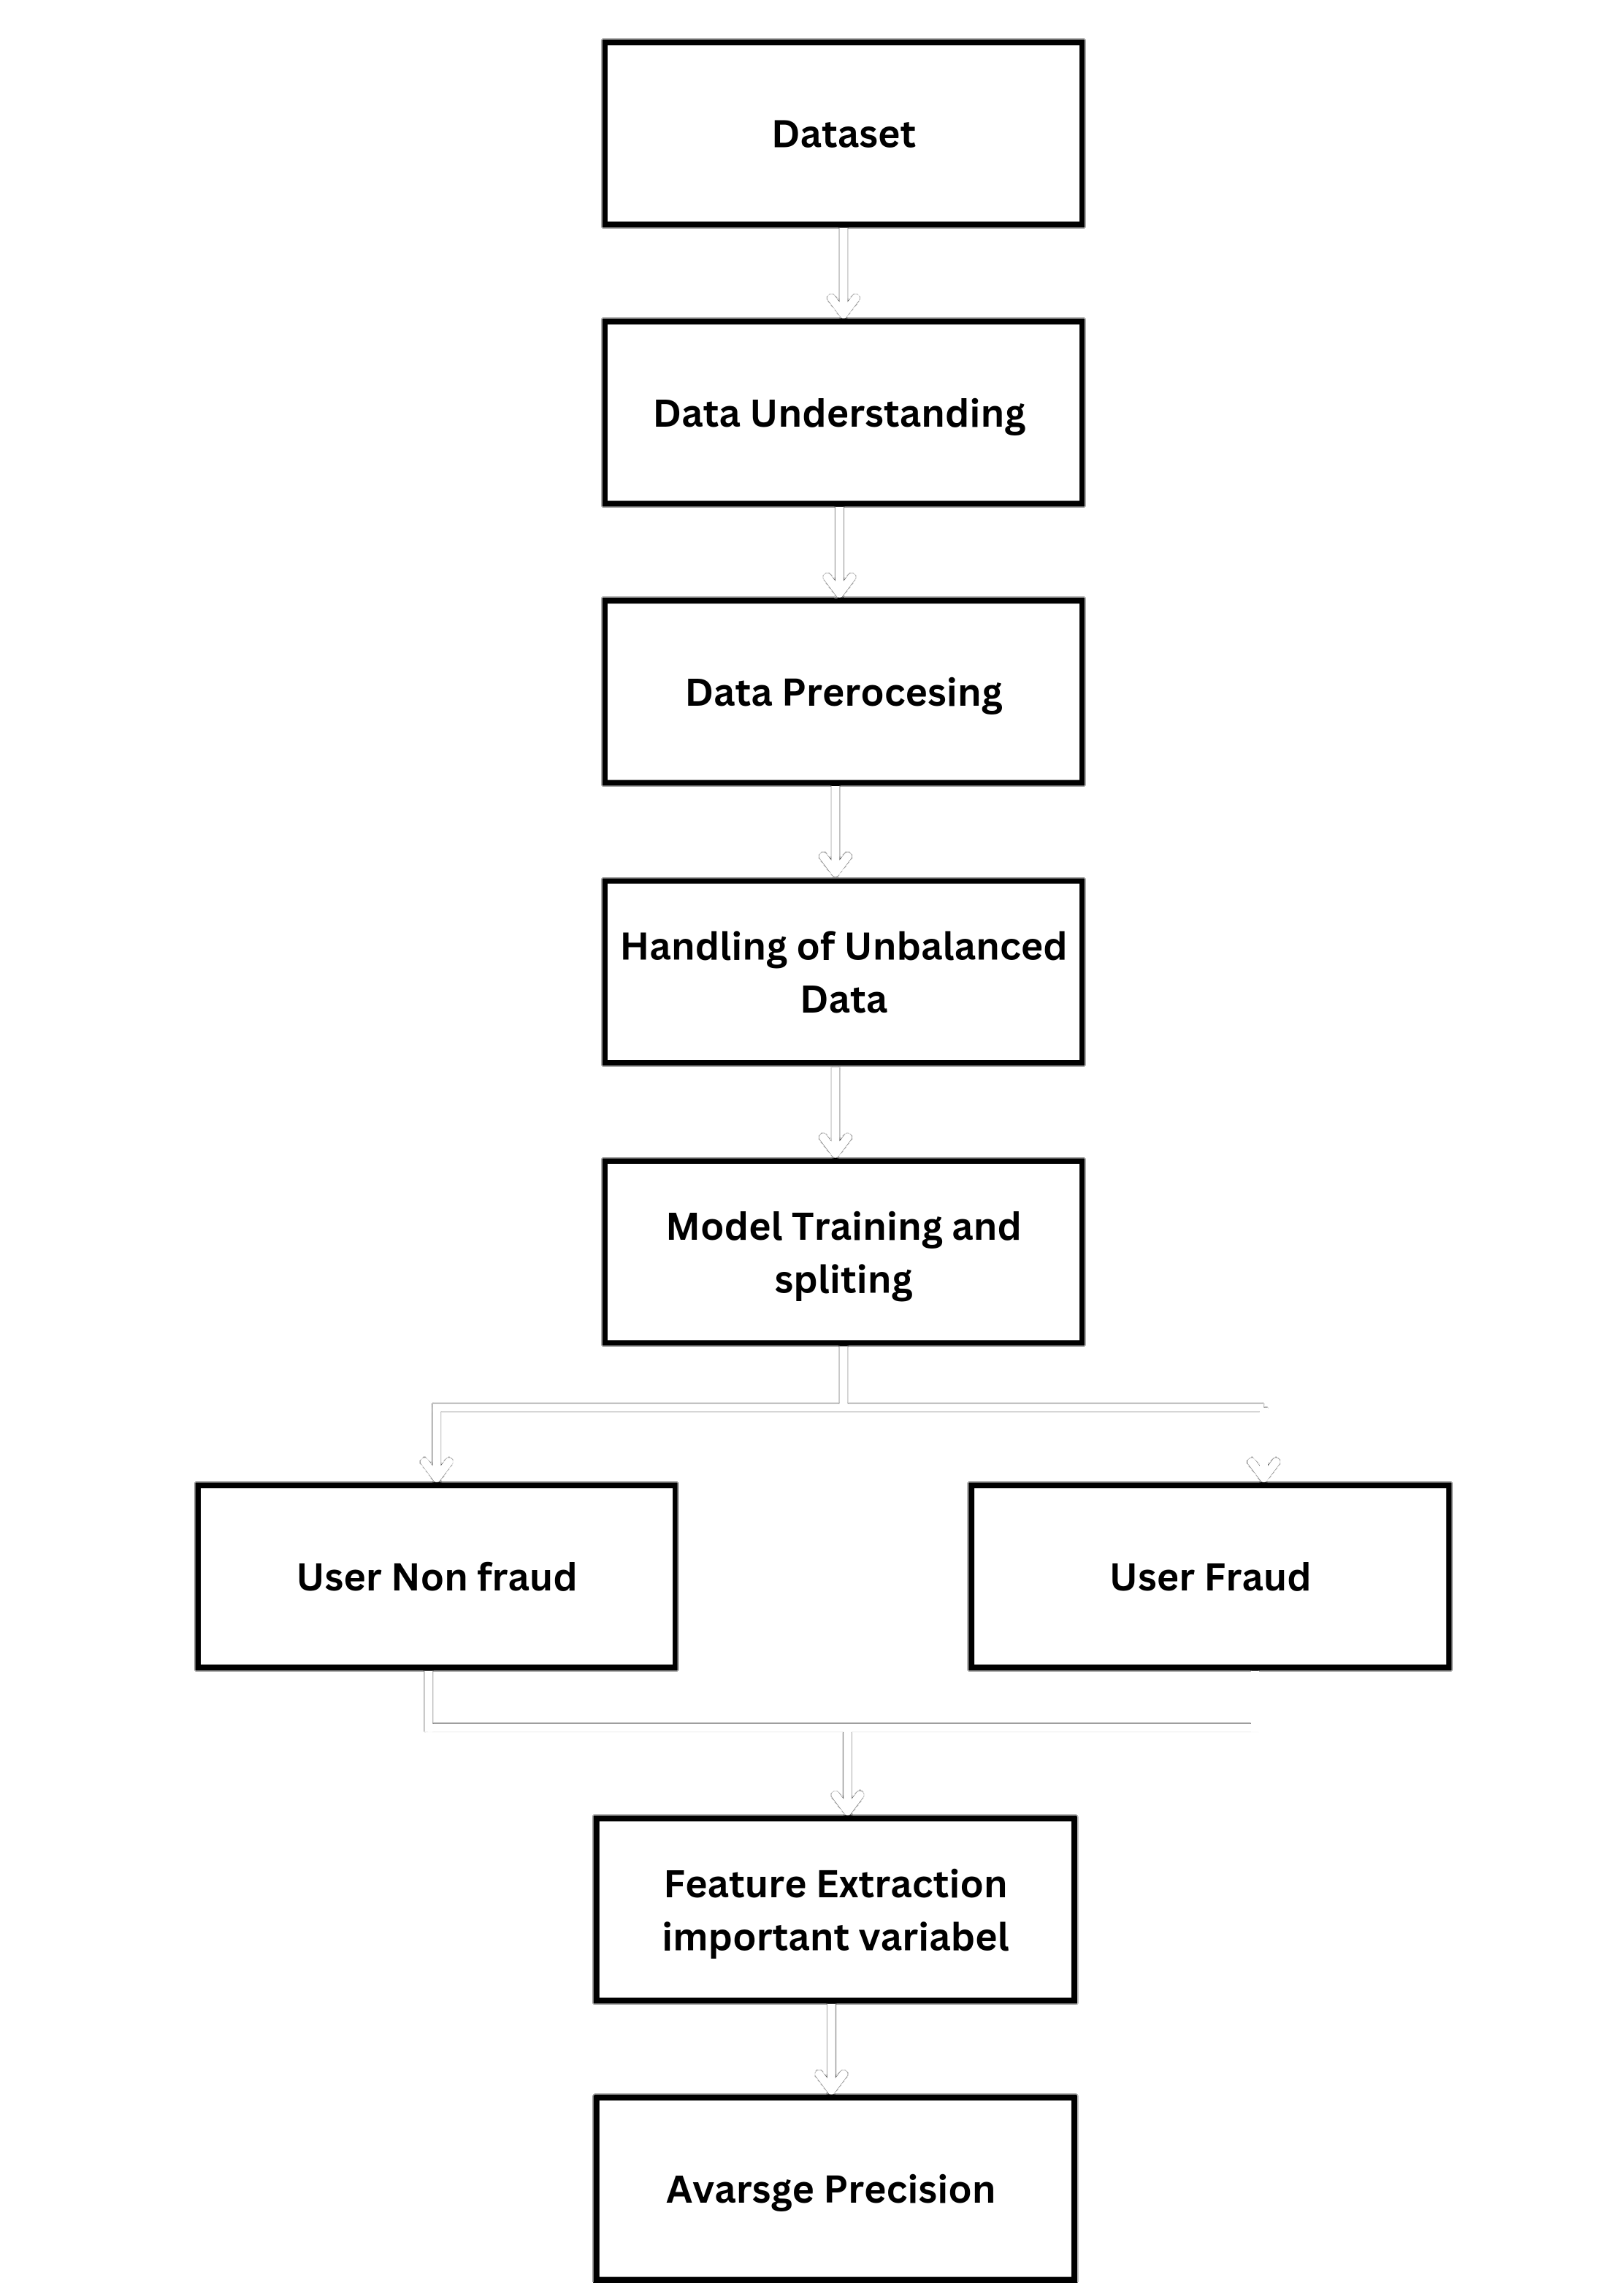

## Imbalance Dataset

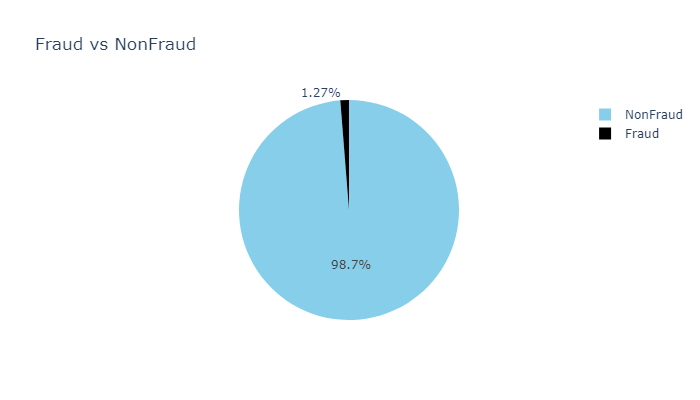

Imbalanced data is a situation in machine learning where there is a disproportionate distribution of data classes. That is, the amount of data in one class (majority class) is much more than the amount of data in another class (minority class).

The pie chart presented illustrates the distribution of fraudulent and non-fraudulent data, with a clear disparity between the two categories. The overwhelming majority, encompassing 98.73%, falls under the non-fraudulent category, while a mere 1.27% represents fraudulent data.

# 2. Matrics For Imbalanced Data

## 2.1 Failure of Accuracy for Imbalanced Label

Imagine you're training a system to spot fraud in financial transactions. Accuracy tells you how many transactions it classified correctly, fraudulent or legitimate. It's like a score based on hitting the right button every time.

The problem? Fraud is rare compared to normal transactions. The system could just label everything "normal" and get a super high accuracy, like 99%. But that's useless! It misses all the actual fraud.

Accuracy can be misleading for fraud detection. We need better ways to measure how well we catch the real crooks, even if it means letting a few legitimate transactions slide by.

## 2.2 metrics to address Imbalanced data sets

The most common metrics to use for imbalanced datasets are:


* AUC score (AUC ROC)
* Average precision score (AP)

It is good practice to track multiple metrics when developing a machine learning model as each highlights different aspects of model performance.

# 3. Set-up

In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
!pip install torch-geometric

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

## 3.1 Import library

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from scipy.sparse import coo_matrix
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality, closeness_centrality

## 3.2 Load Data

In [ ]:
!pip install gdown

import os
import gdown
import zipfile
import logging
from genericpath import isdir

def download_data(url, filename, dir_name: str = "data") -> None:
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
    os.chdir(dir_name)
    logging.info("Downloading data....")
    gdown.download(
        url, quiet=False
    )
    logging.info("Extracting zip file....")
    with zipfile.ZipFile(f"{filename}.zip", 'r') as zip_ref:
        zip_ref.extractall(filename)
    os.remove(f"{filename}.zip")
    os.chdir("..")

download_data(url="https://drive.google.com/uc?&id=1joOspf-LvEBdKLw48S2WeBno_l5J1DPj",
              filename="ristek-datathon-2024",
              dir_name="datathon-2024")

Downloading...
From (original): https://drive.google.com/uc?&id=1joOspf-LvEBdKLw48S2WeBno_l5J1DPj
From (redirected): https://drive.google.com/uc?id=1joOspf-LvEBdKLw48S2WeBno_l5J1DPj&confirm=t&uuid=4aa49372-e244-4520-b6b5-a2c8b7536dd1
To: /content/datathon-2024/ristek-datathon-2024.zip
100%|██████████| 113M/113M [00:00<00:00, 148MB/s]


In [ ]:
# Path to the directory containing the data
data_dir = "/content/datathon-2024/ristek-datathon-2024/ristek-datathon-2024" # Removed the extra ristek-datathon-2024

# Load all CSV files into pandas DataFrames
loan_activities = pd.read_csv(os.path.join(data_dir, "loan_activities.csv"))
non_borrower_user = pd.read_csv(os.path.join(data_dir, "non_borrower_user.csv"))
train = pd.read_csv(os.path.join(data_dir, "train.csv"))
test = pd.read_csv(os.path.join(data_dir, "test.csv"))

# Data Undestanding

## Dataset loan_activities

In [ ]:
#analisis Dataframe Loan_activity
loan_activities.head()

,user_id,reference_contact,loan_type,ts
0,2223129,903716,1,671
1,1380939,484583,1,89
2,2724411,1185034,1,230
3,2401751,1369254,1,120
4,1982168,21797,1,57


In [ ]:
loan_activities.shape

(4300999, 4)

In [ ]:
loan_activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300999 entries, 0 to 4300998
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   user_id            int64
 1   reference_contact  int64
 2   loan_type          int64
 3   ts                 int64
dtypes: int64(4)
memory usage: 131.3 MB


In [ ]:
loan_activities.describe()

,user_id,reference_contact,loan_type,ts
count,4.300999e+06,4.300999e+06,4.300999e+06,4.300999e+06
mean,1.850565e+06,1.849301e+06,5.104953e+00,4.093275e+02
std,1.068463e+06,1.068566e+06,2.205495e+00,2.222010e+02
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,9.249810e+05,9.229035e+05,4.000000e+00,2.260000e+02
50%,1.849778e+06,1.849514e+06,5.000000e+00,4.120000e+02
75%,2.776584e+06,2.775052e+06,6.000000e+00,5.820000e+02
max,3.700548e+06,3.700549e+06,1.100000e+01,8.210000e+02


## Dataset non_borrower_user

In [ ]:
non_borrower_user.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,0,1,5,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
1,1,0,8,0.63,0.565,0.896825,0.6,2.298,0.21,2.284,0.993908,1,0.103175,0.006092,0.053097,1.0,0.007937,0.166667
2,2,-1,-1,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
3,6,0,1,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
4,7,1,6,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000


In [ ]:
non_borrower_user.shape

(1048575, 18)

In [ ]:
non_borrower_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   user_id  1048575 non-null  int64  
 1   pc0      1048575 non-null  int64  
 2   pc1      1048575 non-null  int64  
 3   pc2      1048575 non-null  float64
 4   pc3      1048575 non-null  float64
 5   pc4      1048575 non-null  float64
 6   pc5      1048575 non-null  float64
 7   pc6      1048575 non-null  float64
 8   pc7      1048575 non-null  float64
 9   pc8      1048575 non-null  float64
 10  pc9      1048575 non-null  float64
 11  pc10     1048575 non-null  int64  
 12  pc11     1048575 non-null  float64
 13  pc12     1048575 non-null  float64
 14  pc13     1048575 non-null  float64
 15  pc14     1048575 non-null  float64
 16  pc15     1048575 non-null  float64
 17  pc16     1048575 non-null  float64
dtypes: float64(14), int64(4)
memory usage: 144.0 MB


In [ ]:
non_borrower_user.describe()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,7.845509e+05,3.887829e-01,2.764622e+00,-4.025661e-01,-4.321563e-01,-3.165213e-01,-4.604148e-01,-3.464219e-01,-6.442732e-01,-3.551684e-01,-2.855068e-01,4.385094e-01,-6.227477e-01,-6.537622e-01,-6.519266e-01,-4.526044e-01,-7.981312e-01,-7.348920e-01
std,4.526281e+05,8.221746e-01,2.870280e+00,9.388054e-01,8.878405e-01,9.028309e-01,9.240246e-01,1.042326e+00,5.216804e-01,1.027156e+00,9.418125e-01,1.587725e+00,5.432509e-01,4.967269e-01,5.023275e-01,8.340102e-01,4.069985e-01,5.439490e-01
min,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.925625e+05,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
50%,7.851340e+05,1.000000e+00,3.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
75%,1.176676e+06,1.000000e+00,5.000000e+00,2.500000e-01,2.150000e-01,8.413886e-01,2.000000e-01,2.330000e-01,7.000000e-03,2.200000e-01,9.568528e-01,0.000000e+00,5.882353e-02,1.142857e-02,3.571429e-02,5.714286e-01,-1.000000e+00,-1.000000e+00
max,1.568298e+06,1.000000e+00,8.000000e+00,5.176500e+01,5.091500e+01,1.000000e+00,9.180000e+01,3.430200e+01,7.132000e+00,3.406400e+01,1.000000e+00,4.560000e+02,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00


### Dataset train

In [ ]:
train.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label
0,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.750000,0.018182,0.250000,0
1,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,0.985634,1.0,0.151163,0.014366,0.054795,0.500000,0.011628,0.250000,0
2,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,0.951782,1.0,0.372624,0.048218,0.054545,0.777778,0.003802,0.111111,0
3,10,0.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,17,1.0,1.0,0.235,0.160,0.680851,0.1,0.120,0.002,0.104,0.866667,0.0,0.319149,0.133333,0.031250,-1.000000,-1.000000,-1.000000,0


In [ ]:
train.shape

(857899, 19)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857899 entries, 0 to 857898
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  857899 non-null  int64  
 1   pc0      857899 non-null  float64
 2   pc1      857899 non-null  float64
 3   pc2      857899 non-null  float64
 4   pc3      857899 non-null  float64
 5   pc4      857899 non-null  float64
 6   pc5      857899 non-null  float64
 7   pc6      857899 non-null  float64
 8   pc7      857899 non-null  float64
 9   pc8      857899 non-null  float64
 10  pc9      857899 non-null  float64
 11  pc10     857899 non-null  float64
 12  pc11     857899 non-null  float64
 13  pc12     857899 non-null  float64
 14  pc13     857899 non-null  float64
 15  pc14     857899 non-null  float64
 16  pc15     857899 non-null  float64
 17  pc16     857899 non-null  float64
 18  label    857899 non-null  int64  
dtypes: float64(17), int64(2)
memory usage: 124.4 MB


In [ ]:
train.describe()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label
count,8.578990e+05,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.00000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000
mean,1.851235e+06,0.746870,3.709053,0.545364,0.391718,0.175067,0.315356,0.961431,-0.245161,0.91576,0.251290,1.336002,-0.282764,-0.358987,-0.351351,0.030651,-0.555226,-0.440967,0.012655
std,1.069052e+06,0.439532,1.934880,1.941448,1.766663,0.880198,1.790893,2.766861,0.696857,2.71027,0.932444,3.565165,0.589381,0.522695,0.518399,0.875284,0.503602,0.644649,0.111782
min,3.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,9.251405e+05,0.000000,2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,1.851614e+06,1.000000,4.000000,0.365000,0.295000,0.738007,0.300000,0.312000,0.011000,0.28700,0.922936,0.000000,0.068966,0.011834,0.029297,0.500000,-1.000000,-1.000000,0.000000
75%,2.778174e+06,1.000000,5.000000,1.150000,0.915000,0.884120,0.900000,1.501000,0.114000,1.43400,0.977522,2.000000,0.187500,0.044816,0.057143,0.800000,0.008230,0.200000,0.000000
max,3.700548e+06,1.000000,8.000000,111.815000,111.475000,1.000000,456.300000,64.119000,12.338000,63.41600,1.000000,1313.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000


## Dataset test

In [ ]:
test.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,4,1.0,2.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,13,1.0,5.0,0.445,0.420,0.943820,0.8,0.783,0.234,0.778,0.993614,2.0,0.056180,0.006386,0.095238,0.750000,0.022472,0.250000
2,37,1.0,6.0,1.680,1.080,0.642857,0.6,1.167,0.046,1.007,0.862896,1.0,0.357143,0.137104,0.027778,0.500000,0.002976,0.166667
3,61,0.0,3.0,1.505,0.875,0.581395,0.9,0.425,0.012,0.286,0.672941,1.0,0.418605,0.327059,0.051429,0.333333,0.003322,0.111111
4,66,1.0,5.0,2.210,1.075,0.486425,1.0,1.349,0.087,1.015,0.752409,2.0,0.513575,0.247591,0.046512,0.800000,0.004525,0.200000


In [ ]:
test.shape

(367702, 18)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367702 entries, 0 to 367701
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  367702 non-null  int64  
 1   pc0      367702 non-null  float64
 2   pc1      367702 non-null  float64
 3   pc2      367702 non-null  float64
 4   pc3      367702 non-null  float64
 5   pc4      367702 non-null  float64
 6   pc5      367702 non-null  float64
 7   pc6      367702 non-null  float64
 8   pc7      367702 non-null  float64
 9   pc8      367702 non-null  float64
 10  pc9      367702 non-null  float64
 11  pc10     367702 non-null  float64
 12  pc11     367702 non-null  float64
 13  pc12     367702 non-null  float64
 14  pc13     367702 non-null  float64
 15  pc14     367702 non-null  float64
 16  pc15     367702 non-null  float64
 17  pc16     367702 non-null  float64
dtypes: float64(17), int64(1)
memory usage: 50.5 MB


In [ ]:
test.describe()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
count,3.677020e+05,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000
mean,1.846733e+06,0.746082,3.707519,0.548174,0.393795,0.172392,0.317049,0.966813,-0.246681,0.920817,0.248578,1.346014,-0.283819,-0.360005,-0.353226,0.028216,-0.554844,-0.440620
std,1.068780e+06,0.439969,1.935365,1.948030,1.772834,0.880674,1.738704,2.791356,0.699443,2.734626,0.933026,3.514389,0.590000,0.523162,0.518760,0.875934,0.503653,0.644444
min,4.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,9.194445e+05,0.000000,2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,1.844812e+06,1.000000,4.000000,0.360000,0.290000,0.736264,0.300000,0.309000,0.011000,0.284000,0.922222,0.000000,0.068582,0.011779,0.029091,0.500000,-1.000000,-1.000000
75%,2.773638e+06,1.000000,5.000000,1.150000,0.920000,0.883721,0.900000,1.505000,0.114000,1.437000,0.977305,2.000000,0.187500,0.044960,0.057143,0.800000,0.008230,0.200000
max,3.700544e+06,1.000000,8.000000,90.390000,90.160000,1.000000,120.200000,68.646000,12.679000,68.027000,1.000000,534.000000,1.000000,1.000000,1.000000,2.500000,1.000000,1.000000


# 5. Data Preprocesing

In [ ]:
# Check missing values in each dataset expect (-1)
print("Missing values in loan_activities:\n", loan_activities.isnull().sum())
print("\nMissing values in non_borrower_user:\n", non_borrower_user.isnull().sum())
print("\nMissing values in train:\n", train.isnull().sum())
print("\nMissing values in test:\n", test.isnull().sum())


Missing values in loan_activities:
 user_id              0
reference_contact    0
loan_type            0
ts                   0
dtype: int64

Missing values in non_borrower_user:
 user_id    0
pc0        0
pc1        0
pc2        0
pc3        0
pc4        0
pc5        0
pc6        0
pc7        0
pc8        0
pc9        0
pc10       0
pc11       0
pc12       0
pc13       0
pc14       0
pc15       0
pc16       0
dtype: int64

Missing values in train:
 user_id    0
pc0        0
pc1        0
pc2        0
pc3        0
pc4        0
pc5        0
pc6        0
pc7        0
pc8        0
pc9        0
pc10       0
pc11       0
pc12       0
pc13       0
pc14       0
pc15       0
pc16       0
label      0
dtype: int64

Missing values in test:
 user_id    0
pc0        0
pc1        0
pc2        0
pc3        0
pc4        0
pc5        0
pc6        0
pc7        0
pc8        0
pc9        0
pc10       0
pc11       0
pc12       0
pc13       0
pc14       0
pc15       0
pc16       0
dtype: int64


In [ ]:
# Check missing values in each dataset indicated by -1
print("Missing values in loan_activities:\n", (loan_activities == -1).sum())
print("\nMissing values in non_borrower_user:\n", (non_borrower_user == -1).sum())
print("\nMissing values in train:\n", (train == -1).sum())
print("\nMissing values in test:\n", (test == -1).sum())


Missing values in loan_activities:
 user_id              0
reference_contact    0
loan_type            0
ts                   0
dtype: int64

Missing values in non_borrower_user:
 user_id         0
pc0        229816
pc1        230573
pc2        664670
pc3        665034
pc4        665034
pc5        707412
pc6        664670
pc7        707412
pc8        665034
pc9        665034
pc10            0
pc11       703765
pc12       703765
pc13       707414
pc14       728312
pc15       841369
pc16       841369
dtype: int64

Missing values in train:
 user_id         0
pc0          1773
pc1          1774
pc2        305125
pc3        305477
pc4        305477
pc5        333227
pc6        305125
pc7        333227
pc8        305477
pc9        305477
pc10            0
pc11       339690
pc12       339690
pc13       333228
pc14       352482
pc15       481773
pc16       481773
label           0
dtype: int64

Missing values in test:
 user_id         0
pc0           759
pc1           759
pc2        131255
pc3

In [ ]:
# Check for duplicates in the 'user_id' column of loan_activities
duplicate_user_ids = loan_activities['user_id'].duplicated().sum()
print("Duplicate user_id in loan_activities:", duplicate_user_ids)


Duplicate user_id in loan_activities: 2110337


In [ ]:
# Check for duplicates in each dataset
print("Duplicate rows in loan_activities:", loan_activities.duplicated().sum())
print("Duplicate rows in non_borrower_user:", non_borrower_user.duplicated().sum())
print("Duplicate rows in train:", train.duplicated().sum())
print("Duplicate rows in test:", test.duplicated().sum())


Duplicate rows in loan_activities: 0
Duplicate rows in non_borrower_user: 0
Duplicate rows in train: 0
Duplicate rows in test: 0


In [ ]:
import pandas as pd
import numpy as np
df = pd.DataFrame(train)
train.replace(-1.000000, np.nan, inplace=True)
test.replace(-1.000000, np.nan, inplace=True)
non_borrower_user.replace(-1.000000, np.nan, inplace=True)
loan_activities.replace(-1.000000, np.nan, inplace=True)

Outliers in loan_activities - loan_type:
          user_id  reference_contact  loan_type   ts
3950810  1152830            3452802         10    2
3950811  3598472            1889638         10   11
3950812  2527037            1688268         10   21
3950813  3172548            2045439         10  807
3950814   901273            1251581         10  363
...          ...                ...        ...  ...
4300994   468400            2004356         11  493
4300995  2844279            1657495         11  609
4300996  1071963            2316823         11    1
4300997  2803447            3513529         11  367
4300998  3342102             522089         11  427

[350189 rows x 4 columns]


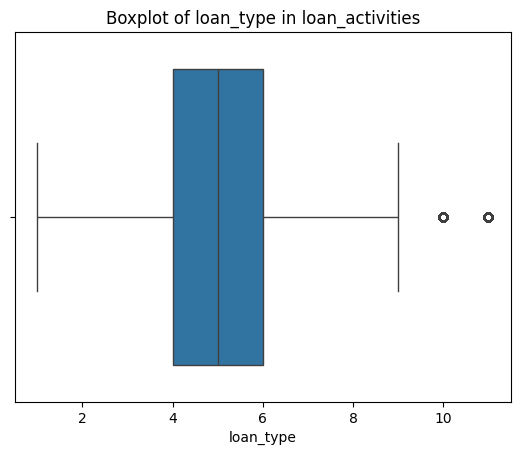

Outliers in non_borrower_user - pc0:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
1              1  0.0  8.0  0.630  0.565  0.896825  0.6  2.298  0.210  2.284   
3              6  0.0  1.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
5              8  0.0  8.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
15            24  0.0  8.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
28            40  0.0  8.0  0.040  0.040  1.000000  NaN  0.024    NaN  0.024   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048543  1568248  0.0  4.0  0.540  0.525  0.972222  1.4  0.680  0.171  0.677   
1048547  1568255  0.0  2.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
1048554  1568267  0.0  8.0  0.215  0.210  0.976744  0.1  0.259  0.055  0.258   
1048562  1568280  0.0  4.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
1048571  1568292  0.0  6.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   

 

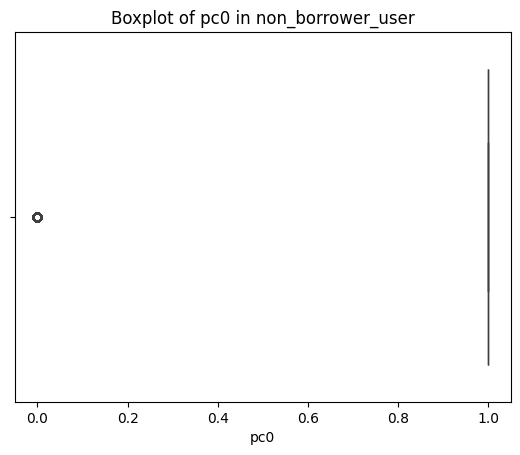

Outliers in non_borrower_user - pc2:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
14            23  1.0  7.0  1.960  1.955  0.997449  3.2  1.559  0.097  1.558   
49            67  1.0  3.0  2.575  1.625  0.631068  0.8  2.941  0.417  2.709   
88           130  1.0  0.0  3.995  3.665  0.917397  2.0  1.338  0.029  1.263   
98           141  1.0  1.0  1.770  1.615  0.912429  1.5  2.577  0.248  2.540   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048238  1567807  NaN  NaN  2.565  2.350  0.916179  0.6  2.424  0.051  2.331   
1048243  1567815  NaN  NaN  2.625  2.415  0.920000  2.1  4.294  0.358  4.118   
1048306  1567902  1.0  7.0  2.125  2.080  0.978824  2.3  2.214  0.213  2.156   
1048435  1568093  1.0  7.0  4.140  4.110  0.992754  4.9  2.378  0.601  2.372   
1048472  1568147  1.0  7.0  3.240  3.170  0.978395  1.2  1.494  0.065  1.477   

 

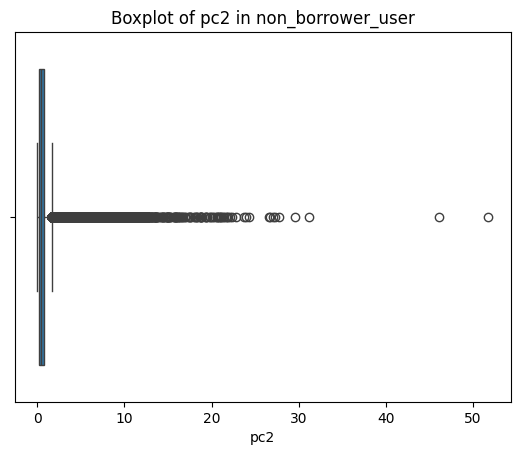

Outliers in non_borrower_user - pc3:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
14            23  1.0  7.0  1.960  1.955  0.997449  3.2  1.559  0.097  1.558   
49            67  1.0  3.0  2.575  1.625  0.631068  0.8  2.941  0.417  2.709   
88           130  1.0  0.0  3.995  3.665  0.917397  2.0  1.338  0.029  1.263   
98           141  1.0  1.0  1.770  1.615  0.912429  1.5  2.577  0.248  2.540   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048243  1567815  NaN  NaN  2.625  2.415  0.920000  2.1  4.294  0.358  4.118   
1048306  1567902  1.0  7.0  2.125  2.080  0.978824  2.3  2.214  0.213  2.156   
1048435  1568093  1.0  7.0  4.140  4.110  0.992754  4.9  2.378  0.601  2.372   
1048472  1568147  1.0  7.0  3.240  3.170  0.978395  1.2  1.494  0.065  1.477   
1048520  1568216  1.0  1.0  1.605  1.505  0.937695  0.4  0.627  0.005  0.566   

 

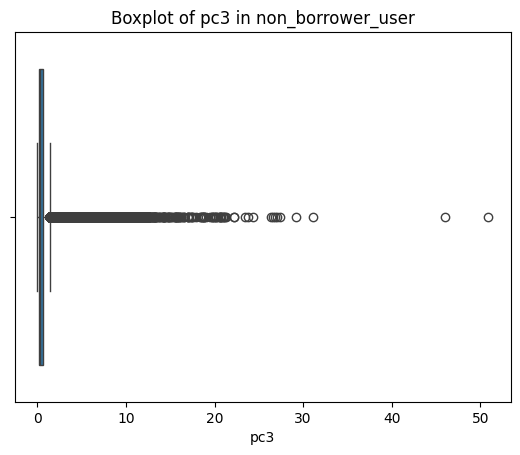

Outliers in non_borrower_user - pc4:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
84           123  1.0  8.0  1.050  0.575  0.547619  0.3  0.563  0.006  0.427   
193          266  1.0  1.0  0.265  0.150  0.566038  0.2  0.124  0.002  0.101   
199          275  1.0  5.0  0.885  0.525  0.593220  0.3  0.874  0.026  0.736   
292          433  1.0  5.0  0.205  0.095  0.463415  NaN  0.068    NaN  0.043   
361          540  1.0  5.0  0.275  0.150  0.545455  0.2  0.142  0.013  0.117   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048218  1567771  1.0  2.0  0.300  0.160  0.533333  0.3  0.137  0.009  0.104   
1048240  1567811  1.0  2.0  0.410  0.195  0.475610  0.1  0.170  0.010  0.114   
1048446  1568114  1.0  3.0  1.000  0.405  0.405000  0.1  0.376  0.001  0.246   
1048560  1568276  1.0  1.0  0.080  0.035  0.437500  0.2  0.040  0.003  0.031   
1048574  1568298  1.0  3.0  0.190  0.110  0.578947  0.1  0.070  0.004  0.054   

 

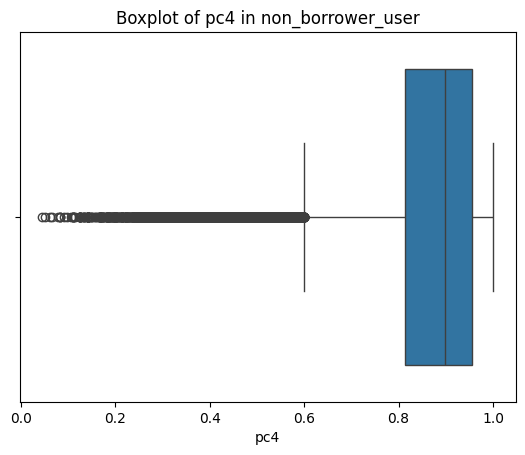

Outliers in non_borrower_user - pc5:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
14            23  1.0  7.0  1.960  1.955  0.997449  3.2  1.559  0.097  1.558   
51            70  1.0  6.0  1.100  1.080  0.981818  1.8  0.984  0.087  0.976   
88           130  1.0  0.0  3.995  3.665  0.917397  2.0  1.338  0.029  1.263   
139          192  1.0  5.0  2.290  2.050  0.895197  3.2  3.924  0.388  3.861   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048306  1567902  1.0  7.0  2.125  2.080  0.978824  2.3  2.214  0.213  2.156   
1048435  1568093  1.0  7.0  4.140  4.110  0.992754  4.9  2.378  0.601  2.372   
1048482  1568159  1.0  5.0  1.320  1.235  0.935606  1.9  2.771  0.606  2.743   
1048513  1568206  1.0  5.0  1.415  1.400  0.989399  3.2  3.442  0.537  3.439   
1048569  1568289  1.0  7.0  1.585  1.195  0.753943  2.2  2.402  0.350  2.291   

 

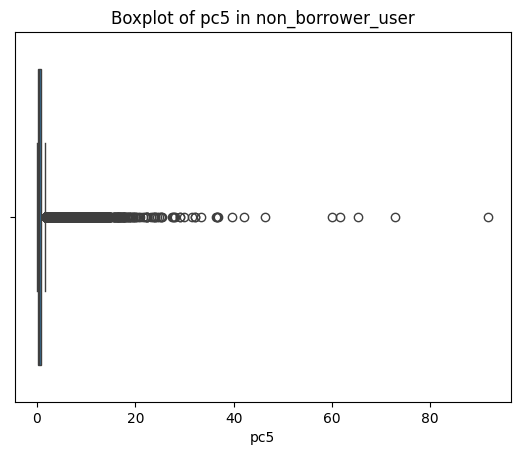

Outliers in non_borrower_user - pc6:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
7             12  1.0  5.0  0.830  0.810  0.975904  0.3  8.549  0.045  8.545   
49            67  1.0  3.0  2.575  1.625  0.631068  0.8  2.941  0.417  2.709   
98           141  1.0  1.0  1.770  1.615  0.912429  1.5  2.577  0.248  2.540   
136          189  0.0  5.0  0.820  0.790  0.963415  0.8  2.871  1.042  2.859   
139          192  1.0  5.0  2.290  2.050  0.895197  3.2  3.924  0.388  3.861   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048201  1567747  1.0  8.0  7.625  7.310  0.958689  1.5  4.695  0.038  4.622   
1048243  1567815  NaN  NaN  2.625  2.415  0.920000  2.1  4.294  0.358  4.118   
1048430  1568088  1.0  3.0  0.905  0.660  0.729282  0.4  3.419  0.981  3.365   
1048482  1568159  1.0  5.0  1.320  1.235  0.935606  1.9  2.771  0.606  2.743   
1048513  1568206  1.0  5.0  1.415  1.400  0.989399  3.2  3.442  0.537  3.439   

 

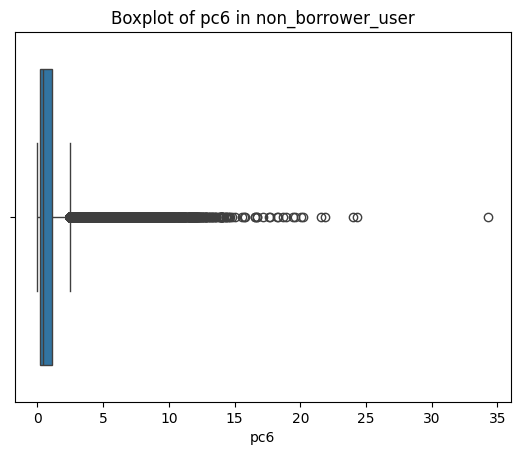

Outliers in non_borrower_user - pc7:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
37            52  1.0  4.0  1.055  0.900  0.853081  1.7  2.138  0.377  2.103   
39            55  1.0  2.0  0.515  0.445  0.864078  1.0  2.414  0.690  2.319   
49            67  1.0  3.0  2.575  1.625  0.631068  0.8  2.941  0.417  2.709   
62            84  1.0  3.0  0.540  0.510  0.944444  1.1  1.975  0.255  1.969   
125          174  1.0  1.0  0.575  0.510  0.886957  0.8  1.244  0.252  1.228   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048487  1568167  1.0  2.0  0.685  0.610  0.890511  1.2  1.568  0.287  1.547   
1048513  1568206  1.0  5.0  1.415  1.400  0.989399  3.2  3.442  0.537  3.439   
1048550  1568259  1.0  5.0  0.345  0.315  0.913043  0.3  1.011  0.654  1.005   
1048555  1568268  1.0  5.0  0.960  0.785  0.817708  0.8  1.318  0.422  1.267   
1048569  1568289  1.0  7.0  1.585  1.195  0.753943  2.2  2.402  0.350  2.291   

 

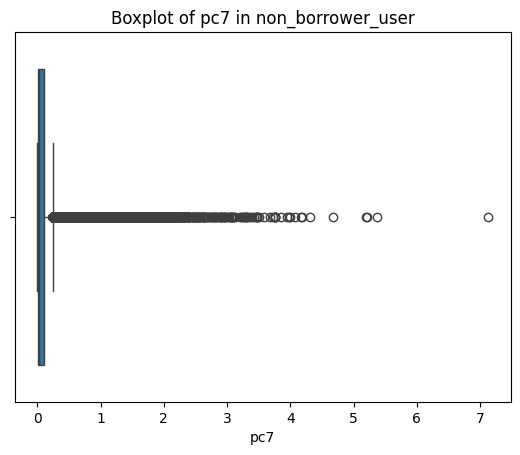

Outliers in non_borrower_user - pc8:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
7             12  1.0  5.0  0.830  0.810  0.975904  0.3  8.549  0.045  8.545   
49            67  1.0  3.0  2.575  1.625  0.631068  0.8  2.941  0.417  2.709   
98           141  1.0  1.0  1.770  1.615  0.912429  1.5  2.577  0.248  2.540   
136          189  0.0  5.0  0.820  0.790  0.963415  0.8  2.871  1.042  2.859   
139          192  1.0  5.0  2.290  2.050  0.895197  3.2  3.924  0.388  3.861   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048201  1567747  1.0  8.0  7.625  7.310  0.958689  1.5  4.695  0.038  4.622   
1048243  1567815  NaN  NaN  2.625  2.415  0.920000  2.1  4.294  0.358  4.118   
1048430  1568088  1.0  3.0  0.905  0.660  0.729282  0.4  3.419  0.981  3.365   
1048482  1568159  1.0  5.0  1.320  1.235  0.935606  1.9  2.771  0.606  2.743   
1048513  1568206  1.0  5.0  1.415  1.400  0.989399  3.2  3.442  0.537  3.439   

 

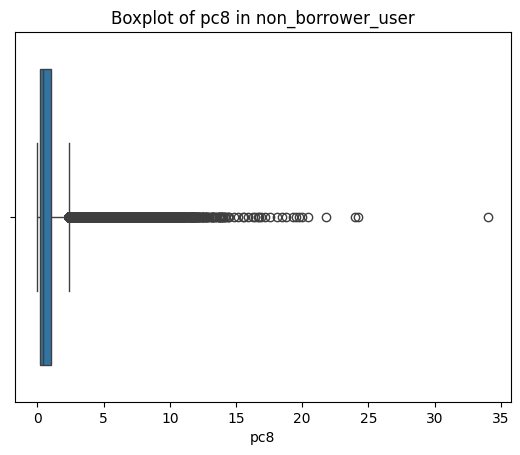

Outliers in non_borrower_user - pc9:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
70           100  1.0  6.0  0.560  0.470  0.839286  0.1  0.231  0.007  0.200   
76           112  1.0  3.0  0.605  0.440  0.727273  1.0  0.281  0.023  0.244   
84           123  1.0  8.0  1.050  0.575  0.547619  0.3  0.563  0.006  0.427   
118          163  0.0  4.0  0.905  0.765  0.845304  0.5  0.228  0.007  0.192   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048446  1568114  1.0  3.0  1.000  0.405  0.405000  0.1  0.376  0.001  0.246   
1048469  1568143  1.0  4.0  0.025  0.020  0.800000  0.1  0.007  0.001  0.006   
1048481  1568158  NaN  NaN  0.555  0.420  0.756757  NaN  0.172    NaN  0.144   
1048560  1568276  1.0  1.0  0.080  0.035  0.437500  0.2  0.040  0.003  0.031   
1048574  1568298  1.0  3.0  0.190  0.110  0.578947  0.1  0.070  0.004  0.054   

 

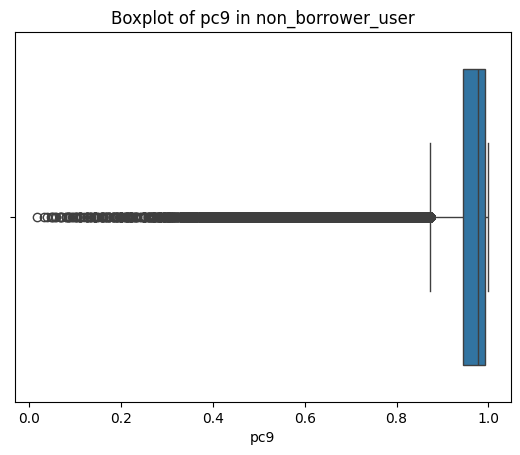

Outliers in non_borrower_user - pc10:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
1              1  0.0  8.0  0.630  0.565  0.896825  0.6  2.298  0.210  2.284   
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
11            19  1.0  3.0  0.150  0.120  0.800000  0.1  0.304  0.010  0.297   
14            23  1.0  7.0  1.960  1.955  0.997449  3.2  1.559  0.097  1.558   
17            26  NaN  NaN  0.170  0.165  0.970588  0.2  0.208  0.007  0.206   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048555  1568268  1.0  5.0  0.960  0.785  0.817708  0.8  1.318  0.422  1.267   
1048557  1568270  1.0  3.0  0.790  0.735  0.930380  1.6  1.423  0.127  1.408   
1048564  1568282  1.0  1.0  0.750  0.650  0.866667  0.2  0.797  0.013  0.773   
1048566  1568285  1.0  4.0  0.255  0.250  0.980392  0.7  0.376  0.028  0.374   
1048569  1568289  1.0  7.0  1.585  1.195  0.753943  2.2  2.402  0.350  2.291   



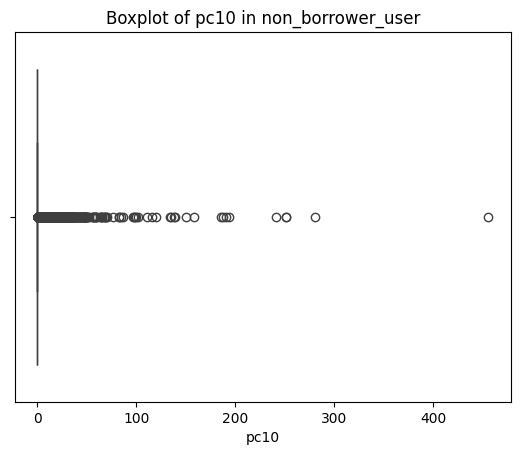

Outliers in non_borrower_user - pc11:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
84           123  1.0  8.0  1.050  0.575  0.547619  0.3  0.563  0.006  0.427   
193          266  1.0  1.0  0.265  0.150  0.566038  0.2  0.124  0.002  0.101   
292          433  1.0  5.0  0.205  0.095  0.463415  NaN  0.068    NaN  0.043   
361          540  1.0  5.0  0.275  0.150  0.545455  0.2  0.142  0.013  0.117   
573          858  1.0  0.0  0.985  0.565  0.573604  0.4  0.613  0.146  0.519   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048218  1567771  1.0  2.0  0.300  0.160  0.533333  0.3  0.137  0.009  0.104   
1048240  1567811  1.0  2.0  0.410  0.195  0.475610  0.1  0.170  0.010  0.114   
1048446  1568114  1.0  3.0  1.000  0.405  0.405000  0.1  0.376  0.001  0.246   
1048560  1568276  1.0  1.0  0.080  0.035  0.437500  0.2  0.040  0.003  0.031   
1048574  1568298  1.0  3.0  0.190  0.110  0.578947  0.1  0.070  0.004  0.054   



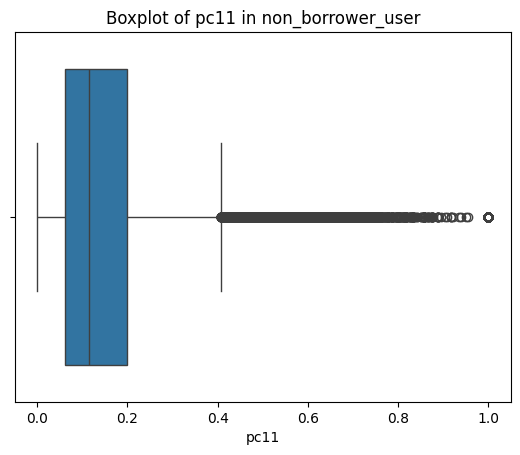

Outliers in non_borrower_user - pc12:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
84           123  1.0  8.0  1.050  0.575  0.547619  0.3  0.563  0.006  0.427   
118          163  0.0  4.0  0.905  0.765  0.845304  0.5  0.228  0.007  0.192   
188          260  1.0  3.0  0.520  0.385  0.740385  NaN  0.191    NaN  0.164   
193          266  1.0  1.0  0.265  0.150  0.566038  0.2  0.124  0.002  0.101   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048446  1568114  1.0  3.0  1.000  0.405  0.405000  0.1  0.376  0.001  0.246   
1048469  1568143  1.0  4.0  0.025  0.020  0.800000  0.1  0.007  0.001  0.006   
1048481  1568158  NaN  NaN  0.555  0.420  0.756757  NaN  0.172    NaN  0.144   
1048560  1568276  1.0  1.0  0.080  0.035  0.437500  0.2  0.040  0.003  0.031   
1048574  1568298  1.0  3.0  0.190  0.110  0.578947  0.1  0.070  0.004  0.054   



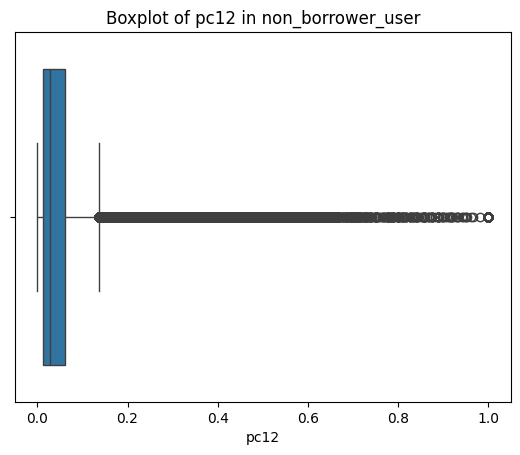

Outliers in non_borrower_user - pc13:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
78           114  1.0  8.0  0.105  0.090  0.857143  0.6  0.149  0.039  0.144   
148          207  1.0  4.0  0.170  0.165  0.970588  0.6  0.155  0.038  0.154   
184          256  1.0  3.0  0.075  0.060  0.800000  0.2  0.075  0.056  0.072   
245          346  1.0  3.0  0.380  0.300  0.789474  1.2  1.273  0.468  1.254   
253          357  1.0  3.0  1.310  1.090  0.832061  3.9  0.826  0.144  0.780   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048338  1567947  1.0  0.0  0.285  0.230  0.807018  0.8  0.135  0.039  0.122   
1048442  1568107  1.0  1.0  0.020  0.020  1.000000  0.1  0.009  0.003  0.009   
1048467  1568141  1.0  1.0  0.065  0.050  0.769231  0.3  0.047  0.024  0.044   
1048469  1568143  1.0  4.0  0.025  0.020  0.800000  0.1  0.007  0.001  0.006   
1048560  1568276  1.0  1.0  0.080  0.035  0.437500  0.2  0.040  0.003  0.031   



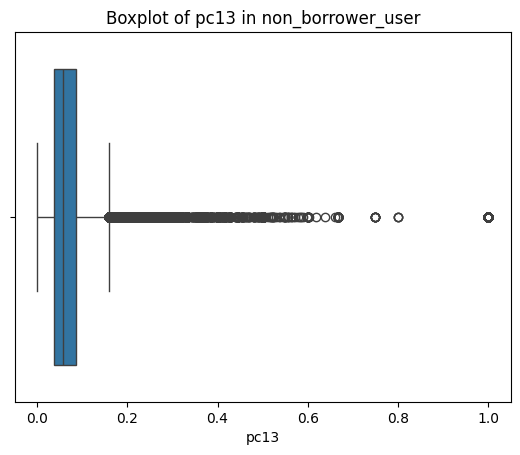

Outliers in non_borrower_user - pc14:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
635          946  0.0  5.0  0.760  0.580  0.763158  1.0  0.999  0.567  0.959   
3589        5369  1.0  5.0  1.625  1.160  0.713846  0.7  1.696  0.023  1.600   
4427        6608  1.0  1.0  0.040  0.040  1.000000  0.1  0.079  0.023  0.079   
4720        7055  1.0  3.0  0.625  0.560  0.896000  0.8  0.447  0.014  0.426   
6209        9267  0.0  8.0  0.070  0.070  1.000000  0.1  0.116  0.043  0.116   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1040383  1556124  0.0  0.0  0.080  0.080  1.000000  0.1  1.280  0.519  1.280   
1040794  1556711  0.0  8.0  0.195  0.165  0.846154  0.2  0.163  0.009  0.157   
1042930  1559913  0.0  5.0  1.285  0.895  0.696498  0.7  1.019  0.010  0.924   
1044586  1562409  1.0  8.0  0.685  0.560  0.817518  0.6  0.653  0.071  0.628   
1046686  1565502  0.0  3.0  0.240  0.165  0.687500  0.1  0.209  0.066  0.193   



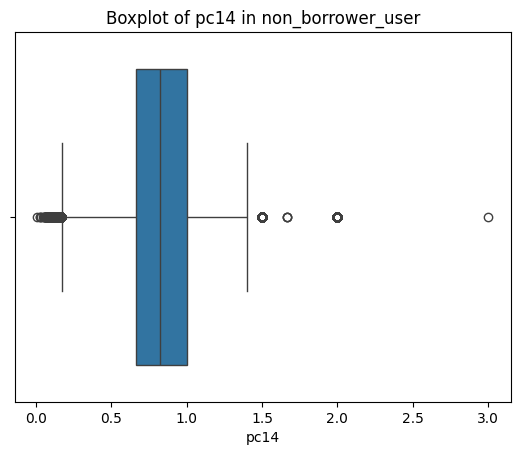

Outliers in non_borrower_user - pc15:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
74           105  0.0  7.0  0.110  0.095  0.863636  0.2  0.192  0.018  0.189   
78           114  1.0  8.0  0.105  0.090  0.857143  0.6  0.149  0.039  0.144   
163          227  1.0  5.0  0.100  0.095  0.950000  0.3  0.102  0.022  0.101   
201          277  0.0  7.0  0.060  0.060  1.000000  0.1  0.015  0.001  0.015   
245          346  1.0  3.0  0.380  0.300  0.789474  1.2  1.273  0.468  1.254   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048124  1567643  NaN  NaN  0.055  0.055  1.000000  0.4  0.024  0.010  0.024   
1048212  1567765  0.0  7.0  0.020  0.020  1.000000  0.1  0.006  0.001  0.006   
1048338  1567947  1.0  0.0  0.285  0.230  0.807018  0.8  0.135  0.039  0.122   
1048372  1568000  1.0  3.0  0.140  0.140  1.000000  0.4  0.228  0.013  0.228   
1048487  1568167  1.0  2.0  0.685  0.610  0.890511  1.2  1.568  0.287  1.547   



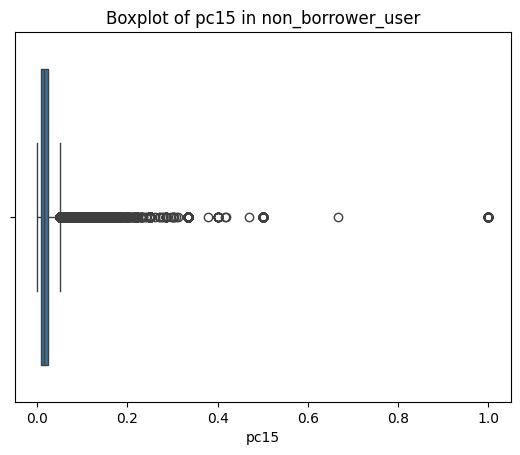

Outliers in non_borrower_user - pc16:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
11            19  1.0  3.0  0.150  0.120  0.800000  0.1  0.304  0.010  0.297   
74           105  0.0  7.0  0.110  0.095  0.863636  0.2  0.192  0.018  0.189   
201          277  0.0  7.0  0.060  0.060  1.000000  0.1  0.015  0.001  0.015   
334          505  1.0  5.0  0.070  0.070  1.000000  0.1  0.053  0.003  0.053   
394          586  0.0  0.0  0.450  0.400  0.888889  0.1  0.203  0.015  0.192   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048145  1567671  1.0  3.0  0.170  0.170  1.000000  0.1  0.191  0.001  0.191   
1048212  1567765  0.0  7.0  0.020  0.020  1.000000  0.1  0.006  0.001  0.006   
1048309  1567906  0.0  3.0  0.115  0.115  1.000000  0.1  0.204  0.006  0.204   
1048406  1568051  0.0  4.0  0.130  0.110  0.846154  0.1  0.143  0.030  0.139   
1048446  1568114  1.0  3.0  1.000  0.405  0.405000  0.1  0.376  0.001  0.246   



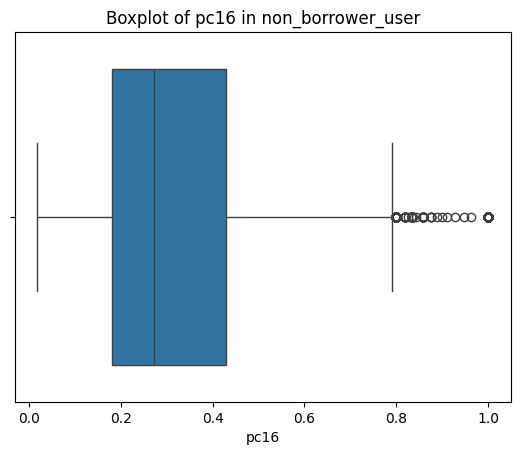

Outliers in train - pc0:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
1             5  0.0  0.0  0.430  0.365  0.848837  0.4  1.253  0.210  1.235   
3            10  0.0  5.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
6            22  0.0  6.0  1.365  1.255  0.919414  1.5  4.450  0.048  4.425   
12           54  0.0  8.0  0.065  0.055  0.846154  0.2  0.059  0.002  0.057   
13           68  0.0  4.0  0.120  0.120  1.000000  0.4  0.233  0.028  0.233   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857881  3700472  0.0  2.0  0.395  0.305  0.772152  0.6  0.480  0.029  0.451   
857882  3700474  0.0  4.0  7.170  5.860  0.817294  5.0  7.597  0.138  7.282   
857889  3700501  0.0  5.0  0.910  0.860  0.945055  0.5  1.935  0.019  1.923   
857891  3700506  0.0  5.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
857898  3700548  0.0  4.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   

             pc9  pc10   

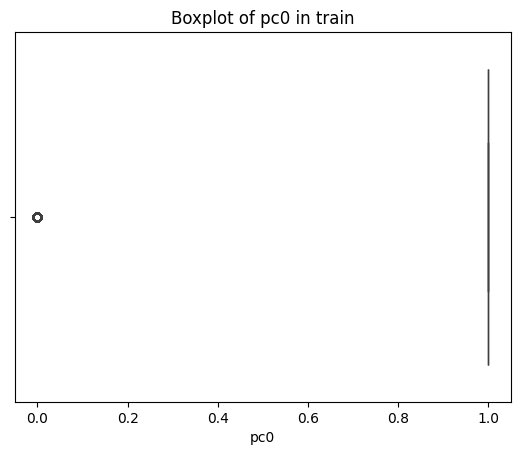

Outliers in train - pc2:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
8            32  1.0  4.0  5.735  2.520  0.439407  1.1   2.404  0.075   1.525   
63          309  1.0  6.0  5.855  5.155  0.880444  4.7   2.668  0.115   2.429   
71          341  1.0  5.0  3.990  3.885  0.973684  2.6   1.795  0.316   1.767   
78          367  0.0  2.0  5.240  4.240  0.809160  3.3  10.074  1.508   9.857   
125         524  1.0  5.0  3.745  2.665  0.711615  1.7   6.786  0.214   6.526   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
857725  3699821  1.0  3.0  5.815  5.400  0.928633  3.4   4.698  0.136   4.607   
857749  3699930  0.0  6.0  6.280  4.850  0.772293  5.0  11.607  2.875  11.200   
857848  3700357  1.0  1.0  4.700  4.385  0.932979  3.3   2.151  0.250   2.077   
857860  3700401  1.0  5.0  5.430  4.635  0.853591  4.3   4.460  0.523   4.277   
857882  3700474  0.0  4.0  7.170  5.860  0.817294  5.0   7.597  0.138   7.282   

 

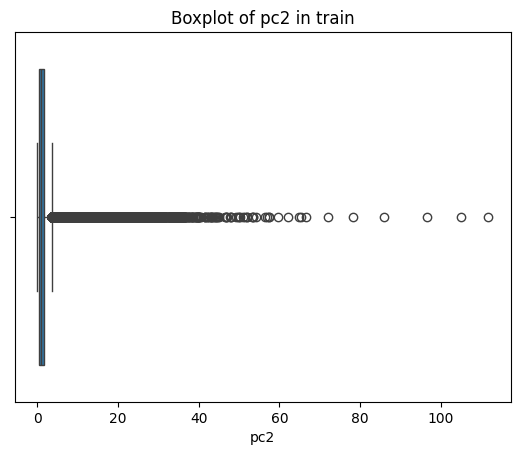

Outliers in train - pc3:
         user_id  pc0  pc1    pc2    pc3       pc4   pc5     pc6    pc7  \
63          309  1.0  6.0  5.855  5.155  0.880444   4.7   2.668  0.115   
71          341  1.0  5.0  3.990  3.885  0.973684   2.6   1.795  0.316   
78          367  0.0  2.0  5.240  4.240  0.809160   3.3  10.074  1.508   
141         602  1.0  4.0  4.110  3.315  0.806569   4.1  14.960  3.617   
177         735  1.0  6.0  7.460  7.160  0.959786   3.9   4.006  0.661   
...         ...  ...  ...    ...    ...       ...   ...     ...    ...   
857749  3699930  0.0  6.0  6.280  4.850  0.772293   5.0  11.607  2.875   
857814  3700243  0.0  2.0  3.230  3.015  0.933437  10.7   1.918  0.126   
857848  3700357  1.0  1.0  4.700  4.385  0.932979   3.3   2.151  0.250   
857860  3700401  1.0  5.0  5.430  4.635  0.853591   4.3   4.460  0.523   
857882  3700474  0.0  4.0  7.170  5.860  0.817294   5.0   7.597  0.138   

           pc8       pc9  pc10      pc11      pc12      pc13      pc14  \
63       2.

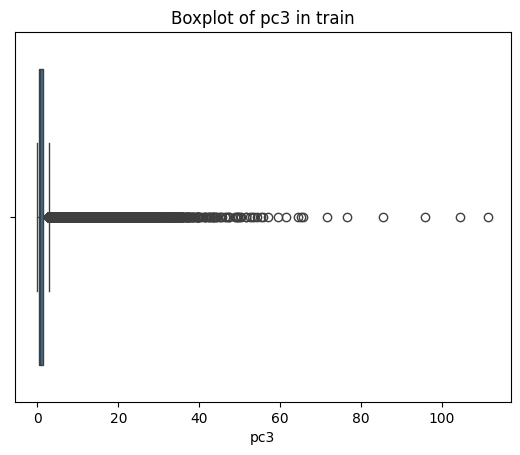

Outliers in train - pc4:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
8            32  1.0  4.0  5.735  2.520  0.439407  1.1  2.404  0.075  1.525   
171         712  0.0  3.0  1.130  0.535  0.473451  0.2  1.085  0.002  0.850   
210         890  1.0  5.0  0.430  0.195  0.453488  NaN  0.279    NaN  0.229   
308        1324  1.0  6.0  3.005  1.475  0.490849  1.5  3.664  0.066  3.149   
322        1363  1.0  5.0  1.400  0.570  0.407143  0.2  1.774  0.078  1.598   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857667  3699579  0.0  3.0  0.165  0.055  0.333333  0.1  0.035  0.001  0.013   
857674  3699615  1.0  7.0  1.175  0.240  0.204255  0.1  0.541  0.003  0.345   
857700  3699726  1.0  6.0  1.165  0.515  0.442060  0.5  1.082  0.068  0.947   
857726  3699825  1.0  5.0  1.190  0.320  0.268908  0.3  0.305  0.005  0.119   
857857  3700387  1.0  6.0  0.930  0.305  0.327957  0.1  0.341  0.002  0.209   

             pc9  pc10   

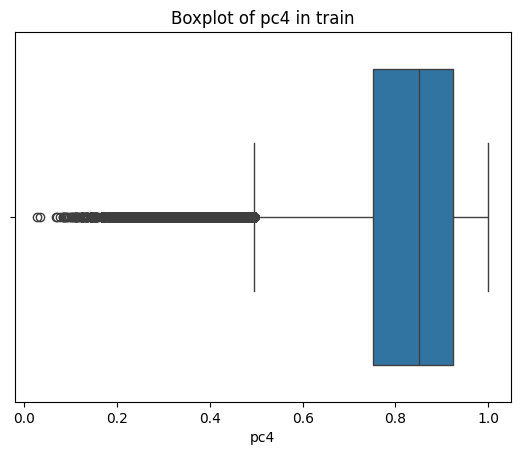

Outliers in train - pc5:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
63          309  1.0  6.0  5.855  5.155  0.880444  4.7   2.668  0.115   2.429   
65          323  1.0  8.0  2.955  2.610  0.883249  4.5  12.023  3.298  11.926   
78          367  0.0  2.0  5.240  4.240  0.809160  3.3  10.074  1.508   9.857   
141         602  1.0  4.0  4.110  3.315  0.806569  4.1  14.960  3.617  14.782   
143         613  1.0  5.0  2.890  2.190  0.757785  3.1   6.493  0.285   6.247   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
857824  3700282  1.0  3.0  2.285  2.160  0.945295  3.8   1.104  0.091   1.078   
857848  3700357  1.0  1.0  4.700  4.385  0.932979  3.3   2.151  0.250   2.077   
857860  3700401  1.0  5.0  5.430  4.635  0.853591  4.3   4.460  0.523   4.277   
857882  3700474  0.0  4.0  7.170  5.860  0.817294  5.0   7.597  0.138   7.282   
857883  3700480  1.0  3.0  2.835  2.705  0.954145  3.3   5.888  0.520   5.765   

 

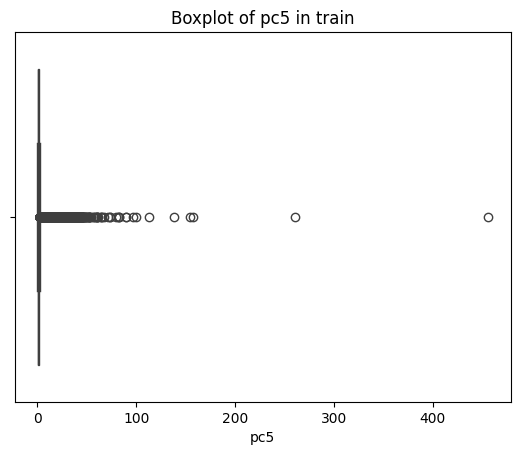

Outliers in train - pc6:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
7            29  1.0  4.0  2.445  2.115  0.865031  2.0   6.266  0.142   6.194   
10           48  1.0  8.0  2.140  1.685  0.787383  1.4   7.099  0.098   7.001   
65          323  1.0  8.0  2.955  2.610  0.883249  4.5  12.023  3.298  11.926   
78          367  0.0  2.0  5.240  4.240  0.809160  3.3  10.074  1.508   9.857   
88          405  1.0  4.0  3.275  2.855  0.871756  2.4   8.905  0.222   8.813   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
857754  3699955  0.0  4.0  1.935  1.575  0.813953  1.3   9.207  0.488   8.968   
857784  3700097  1.0  4.0  1.760  1.560  0.886364  1.5   6.406  2.119   6.362   
857882  3700474  0.0  4.0  7.170  5.860  0.817294  5.0   7.597  0.138   7.282   
857883  3700480  1.0  3.0  2.835  2.705  0.954145  3.3   5.888  0.520   5.765   
857884  3700485  1.0  5.0  1.635  1.475  0.902141  1.4   6.111  0.353   6.066   

 

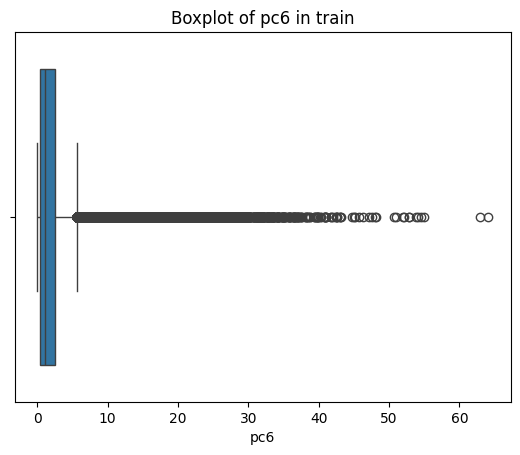

Outliers in train - pc7:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
54          267  0.0  6.0  0.540  0.540  1.000000  0.9   2.098  0.978   2.098   
65          323  1.0  8.0  2.955  2.610  0.883249  4.5  12.023  3.298  11.926   
78          367  0.0  2.0  5.240  4.240  0.809160  3.3  10.074  1.508   9.857   
103         450  0.0  4.0  2.945  2.400  0.814941  2.4   5.841  0.786   5.722   
128         547  0.0  5.0  1.415  0.980  0.692580  0.8   1.836  0.619   1.709   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
857736  3699854  1.0  3.0  1.505  1.260  0.837209  1.8   3.005  1.367   2.948   
857749  3699930  0.0  6.0  6.280  4.850  0.772293  5.0  11.607  2.875  11.200   
857784  3700097  1.0  4.0  1.760  1.560  0.886364  1.5   6.406  2.119   6.362   
857842  3700347  1.0  5.0  1.630  0.910  0.558282  1.9   2.508  0.912   2.351   
857895  3700532  1.0  3.0  1.710  1.535  0.897661  2.1   3.750  0.687   3.712   

 

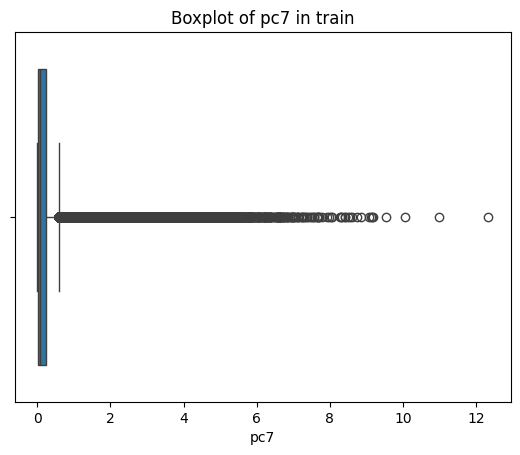

Outliers in train - pc8:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
7            29  1.0  4.0  2.445  2.115  0.865031  2.0   6.266  0.142   6.194   
10           48  1.0  8.0  2.140  1.685  0.787383  1.4   7.099  0.098   7.001   
65          323  1.0  8.0  2.955  2.610  0.883249  4.5  12.023  3.298  11.926   
78          367  0.0  2.0  5.240  4.240  0.809160  3.3  10.074  1.508   9.857   
88          405  1.0  4.0  3.275  2.855  0.871756  2.4   8.905  0.222   8.813   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
857754  3699955  0.0  4.0  1.935  1.575  0.813953  1.3   9.207  0.488   8.968   
857784  3700097  1.0  4.0  1.760  1.560  0.886364  1.5   6.406  2.119   6.362   
857882  3700474  0.0  4.0  7.170  5.860  0.817294  5.0   7.597  0.138   7.282   
857883  3700480  1.0  3.0  2.835  2.705  0.954145  3.3   5.888  0.520   5.765   
857884  3700485  1.0  5.0  1.635  1.475  0.902141  1.4   6.111  0.353   6.066   

 

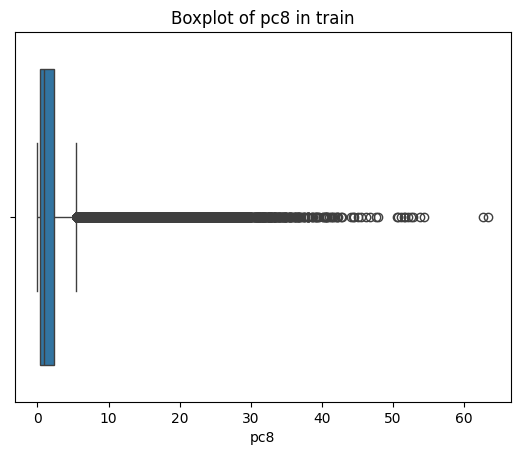

Outliers in train - pc9:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
8            32  1.0  4.0  5.735  2.520  0.439407  1.1  2.404  0.075  1.525   
21           94  0.0  3.0  0.310  0.175  0.564516  0.1  0.196  0.087  0.158   
110         472  1.0  0.0  1.585  1.175  0.741325  0.4  0.509  0.006  0.405   
130         554  0.0  1.0  0.860  0.645  0.750000  0.2  0.244  0.002  0.197   
154         659  1.0  1.0  1.580  1.060  0.670886  0.2  0.850  0.003  0.710   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857815  3700245  1.0  2.0  1.555  0.835  0.536977  0.1  0.809  0.001  0.624   
857845  3700351  1.0  2.0  1.250  0.920  0.736000  0.4  0.400  0.037  0.333   
857853  3700375  0.0  3.0  0.265  0.245  0.924528  0.2  0.265  0.015  0.170   
857857  3700387  1.0  6.0  0.930  0.305  0.327957  0.1  0.341  0.002  0.209   
857877  3700455  1.0  5.0  1.825  1.180  0.646575  0.7  0.805  0.011  0.646   

             pc9  pc10   

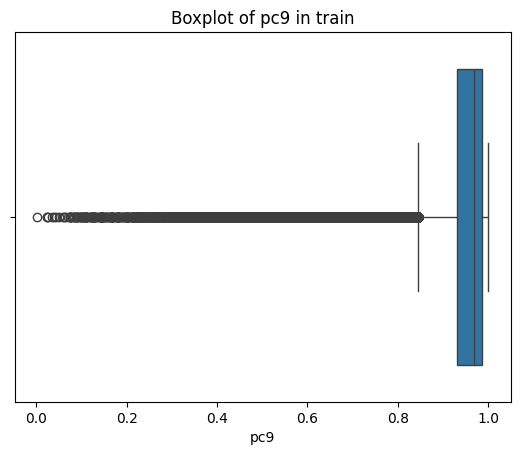

Outliers in train - pc10:
         user_id  pc0  pc1    pc2    pc3       pc4   pc5     pc6    pc7  \
63          309  1.0  6.0  5.855  5.155  0.880444   4.7   2.668  0.115   
64          314  1.0  8.0  1.415  1.315  0.929329   1.1   2.760  0.346   
65          323  1.0  8.0  2.955  2.610  0.883249   4.5  12.023  3.298   
103         450  0.0  4.0  2.945  2.400  0.814941   2.4   5.841  0.786   
142         611  1.0  2.0  1.125  0.970  0.862222   1.7   2.757  0.425   
...         ...  ...  ...    ...    ...       ...   ...     ...    ...   
857814  3700243  0.0  2.0  3.230  3.015  0.933437  10.7   1.918  0.126   
857824  3700282  1.0  3.0  2.285  2.160  0.945295   3.8   1.104  0.091   
857860  3700401  1.0  5.0  5.430  4.635  0.853591   4.3   4.460  0.523   
857882  3700474  0.0  4.0  7.170  5.860  0.817294   5.0   7.597  0.138   
857883  3700480  1.0  3.0  2.835  2.705  0.954145   3.3   5.888  0.520   

           pc8       pc9  pc10      pc11      pc12      pc13      pc14  \
63       2

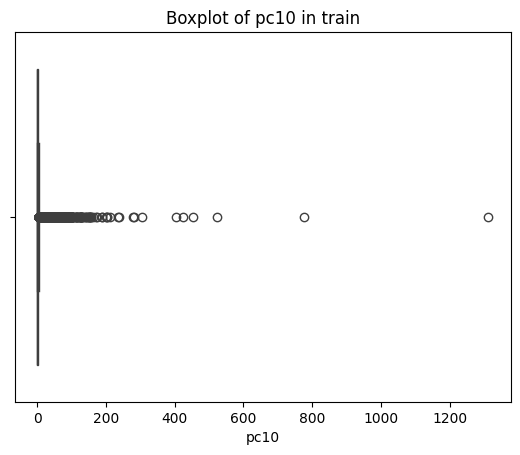

Outliers in train - pc11:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
8            32  1.0  4.0  5.735  2.520  0.439407  1.1  2.404  0.075  1.525   
171         712  0.0  3.0  1.130  0.535  0.473451  0.2  1.085  0.002  0.850   
210         890  1.0  5.0  0.430  0.195  0.453488  NaN  0.279    NaN  0.229   
308        1324  1.0  6.0  3.005  1.475  0.490849  1.5  3.664  0.066  3.149   
322        1363  1.0  5.0  1.400  0.570  0.407143  0.2  1.774  0.078  1.598   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857667  3699579  0.0  3.0  0.165  0.055  0.333333  0.1  0.035  0.001  0.013   
857674  3699615  1.0  7.0  1.175  0.240  0.204255  0.1  0.541  0.003  0.345   
857700  3699726  1.0  6.0  1.165  0.515  0.442060  0.5  1.082  0.068  0.947   
857726  3699825  1.0  5.0  1.190  0.320  0.268908  0.3  0.305  0.005  0.119   
857857  3700387  1.0  6.0  0.930  0.305  0.327957  0.1  0.341  0.002  0.209   

             pc9  pc10  

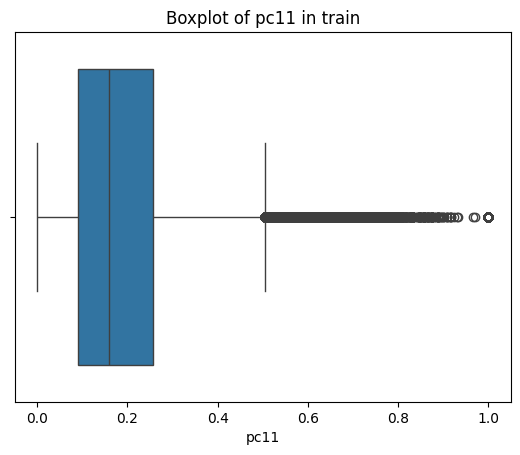

Outliers in train - pc12:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
8            32  1.0  4.0  5.735  2.520  0.439407  1.1  2.404  0.075  1.525   
21           94  0.0  3.0  0.310  0.175  0.564516  0.1  0.196  0.087  0.158   
110         472  1.0  0.0  1.585  1.175  0.741325  0.4  0.509  0.006  0.405   
130         554  0.0  1.0  0.860  0.645  0.750000  0.2  0.244  0.002  0.197   
154         659  1.0  1.0  1.580  1.060  0.670886  0.2  0.850  0.003  0.710   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857815  3700245  1.0  2.0  1.555  0.835  0.536977  0.1  0.809  0.001  0.624   
857845  3700351  1.0  2.0  1.250  0.920  0.736000  0.4  0.400  0.037  0.333   
857853  3700375  0.0  3.0  0.265  0.245  0.924528  0.2  0.265  0.015  0.170   
857857  3700387  1.0  6.0  0.930  0.305  0.327957  0.1  0.341  0.002  0.209   
857877  3700455  1.0  5.0  1.825  1.180  0.646575  0.7  0.805  0.011  0.646   

             pc9  pc10  

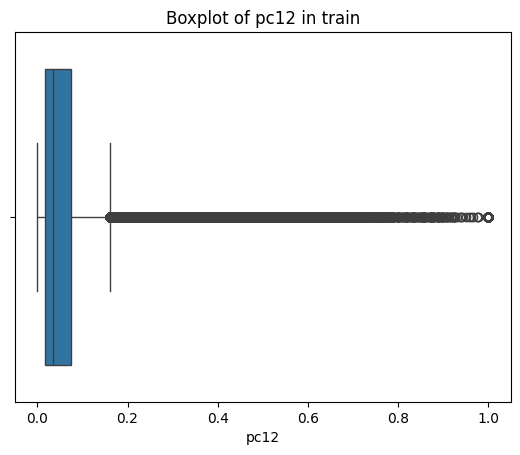

Outliers in train - pc13:
         user_id  pc0  pc1    pc2    pc3       pc4   pc5    pc6    pc7    pc8  \
12           54  0.0  8.0  0.065  0.055  0.846154   0.2  0.059  0.002  0.057   
13           68  0.0  4.0  0.120  0.120  1.000000   0.4  0.233  0.028  0.233   
32          159  1.0  6.0  0.165  0.160  0.969697   0.6  0.381  0.054  0.379   
39          181  1.0  3.0  0.030  0.030  1.000000   0.1  0.016  0.001  0.016   
40          197  0.0  2.0  0.005  0.005  1.000000   0.1  0.001  0.001  0.001   
...         ...  ...  ...    ...    ...       ...   ...    ...    ...    ...   
857774  3700041  1.0  3.0  0.355  0.290  0.816901   1.3  0.419  0.073  0.406   
857792  3700135  1.0  3.0  0.845  0.830  0.982249   2.2  0.921  0.130  0.918   
857814  3700243  0.0  2.0  3.230  3.015  0.933437  10.7  1.918  0.126  1.851   
857823  3700273  1.0  5.0  0.050  0.050  1.000000   0.4  0.035  0.025  0.035   
857863  3700408  1.0  5.0  0.180  0.170  0.944444   1.0  0.164  0.039  0.162   

            

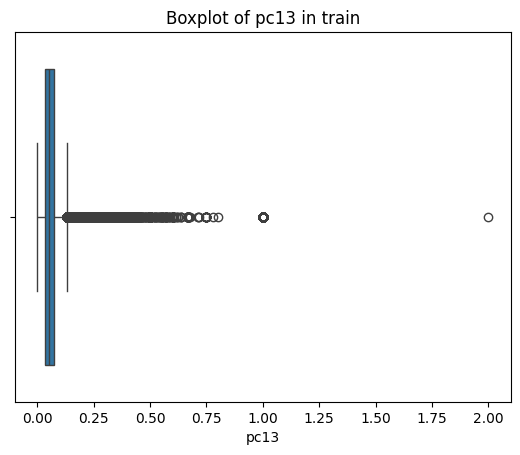

Outliers in train - pc14:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
1061       4516  1.0  2.0  0.375  0.350  0.933333  0.2  0.151  0.009  0.146   
2127       9069  1.0  4.0  0.725  0.500  0.689655  0.2  0.358  0.045  0.312   
3658      16089  0.0  7.0  3.300  2.820  0.854545  6.1  1.728  0.125  1.601   
4541      19848  0.0  3.0  3.770  1.875  0.497347  0.9  1.671  0.014  1.086   
5103      22223  1.0  5.0  0.375  0.235  0.626667  0.1  0.670  0.005  0.642   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
855257  3688959  1.0  1.0  1.015  0.910  0.896552  0.5  0.937  0.143  0.909   
855448  3689830  1.0  3.0  0.135  0.135  1.000000  0.2  0.084  0.030  0.084   
855881  3691636  1.0  3.0  0.180  0.155  0.861111  0.2  0.339  0.013  0.334   
857410  3698432  1.0  5.0  0.120  0.100  0.833333  0.2  0.228  0.021  0.224   
857822  3700272  1.0  1.0  1.000  0.565  0.565000  0.2  0.696  0.074  0.605   

             pc9  pc10  

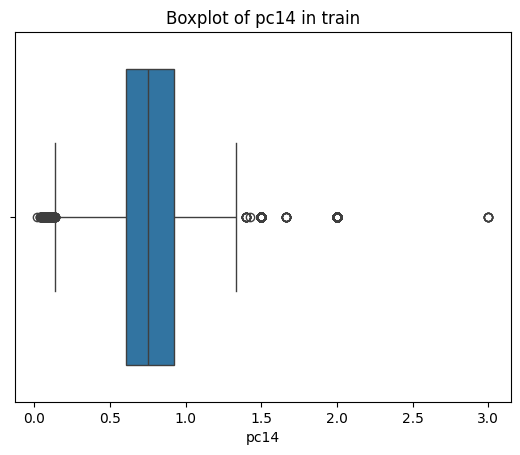

Outliers in train - pc15:
         user_id  pc0  pc1    pc2    pc3       pc4   pc5    pc6    pc7    pc8  \
12           54  0.0  8.0  0.065  0.055  0.846154   0.2  0.059  0.002  0.057   
13           68  0.0  4.0  0.120  0.120  1.000000   0.4  0.233  0.028  0.233   
74          352  1.0  5.0  0.210  0.185  0.880952   0.6  0.164  0.046  0.159   
106         461  1.0  3.0  0.145  0.135  0.931034   0.2  0.141  0.005  0.139   
127         539  1.0  4.0  0.125  0.115  0.920000   0.4  0.094  0.022  0.092   
...         ...  ...  ...    ...    ...       ...   ...    ...    ...    ...   
857643  3699458  1.0  3.0  0.230  0.155  0.673913   0.3  0.316  0.098  0.294   
857737  3699856  1.0  0.0  0.315  0.165  0.523810   0.6  0.924  0.168  0.892   
857738  3699858  0.0  4.0  0.545  0.470  0.862385   0.9  0.267  0.039  0.251   
857814  3700243  0.0  2.0  3.230  3.015  0.933437  10.7  1.918  0.126  1.851   
857863  3700408  1.0  5.0  0.180  0.170  0.944444   1.0  0.164  0.039  0.162   

            

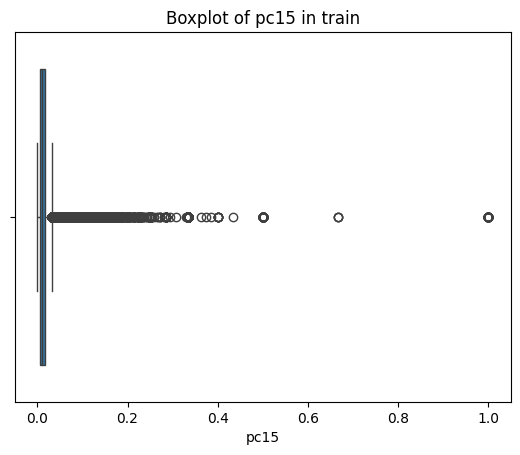

Outliers in train - pc16:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
227         981  1.0  3.0  0.120  0.110  0.916667  0.3  0.118  0.028  0.116   
233        1009  1.0  5.0  0.305  0.185  0.606557  0.1  0.247  0.012  0.199   
247        1065  1.0  5.0  0.415  0.380  0.915663  0.4  1.028  0.054  1.021   
367        1541  1.0  4.0  0.285  0.170  0.596491  0.3  0.110  0.005  0.064   
511        2115  1.0  3.0  1.105  0.925  0.837104  0.7  0.411  0.024  0.359   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857673  3699610  0.0  2.0  0.595  0.515  0.865546  0.3  0.599  0.066  0.577   
857674  3699615  1.0  7.0  1.175  0.240  0.204255  0.1  0.541  0.003  0.345   
857812  3700240  1.0  4.0  0.625  0.395  0.632000  0.3  0.991  0.148  0.944   
857857  3700387  1.0  6.0  0.930  0.305  0.327957  0.1  0.341  0.002  0.209   
857869  3700421  0.0  5.0  0.350  0.305  0.871429  0.3  0.279  0.088  0.265   

             pc9  pc10  

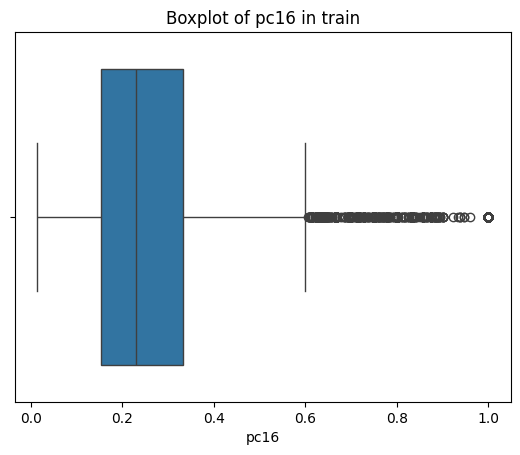

Outliers in train - label:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
252        1080  1.0  2.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
305        1307  1.0  1.0  0.295  0.285  0.966102  0.5  0.346  0.057  0.344   
481        2001  0.0  1.0  0.490  0.455  0.928571  0.4  1.046  0.126  1.036   
482        2002  1.0  1.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
515        2129  1.0  5.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857668  3699581  1.0  2.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
857678  3699636  1.0  5.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
857691  3699702  1.0  6.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
857775  3700044  1.0  6.0  0.590  0.575  0.974576  0.5  1.668  0.087  1.665   
857789  3700118  1.0  8.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   

             pc9  pc10 

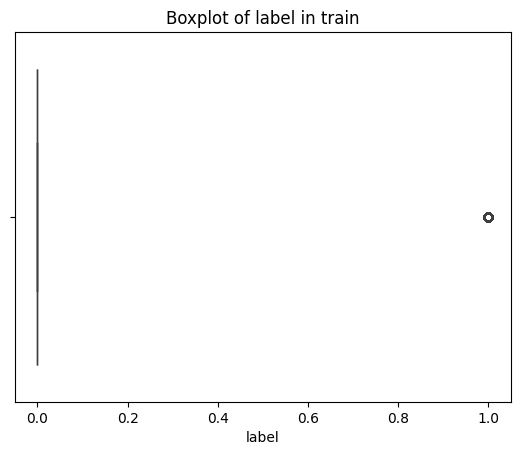

Outliers in test - pc2:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
11          135  1.0  4.0  6.165  4.495  0.729116  4.3   8.167  0.449   7.718   
28          359  1.0  5.0  4.560  3.775  0.827851  2.2   6.738  0.806   6.529   
29          360  1.0  3.0  3.850  3.080  0.800000  3.0   1.821  0.130   1.660   
37          392  1.0  2.0  7.875  7.855  0.997460  4.7   3.024  0.105   3.020   
57          609  1.0  3.0  7.110  6.875  0.966948  0.8   3.090  0.022   3.026   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
367587  3699493  1.0  4.0  4.970  4.805  0.966801  5.1   1.500  0.068   1.423   
367602  3699580  1.0  6.0  3.705  2.955  0.797571  2.2  13.732  2.816  13.566   
367627  3699779  1.0  8.0  3.755  3.385  0.901465  4.0   9.784  0.198   9.681   
367637  3699875  1.0  6.0  4.450  3.710  0.833708  2.7   8.482  0.451   8.260   
367661  3700103  1.0  3.0  7.395  7.125  0.963489  3.0   3.714  0.100   3.639   

  

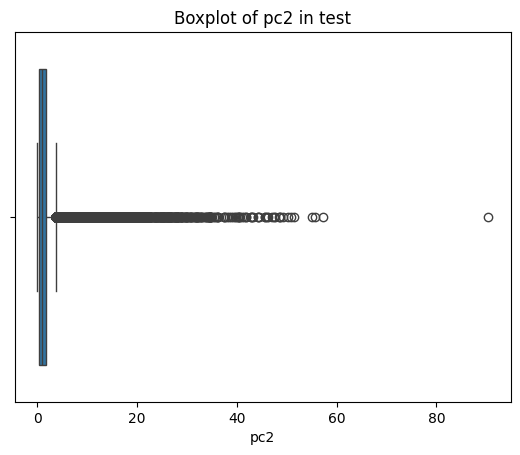

Outliers in test - pc3:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
11          135  1.0  4.0  6.165  4.495  0.729116  4.3   8.167  0.449   7.718   
28          359  1.0  5.0  4.560  3.775  0.827851  2.2   6.738  0.806   6.529   
29          360  1.0  3.0  3.850  3.080  0.800000  3.0   1.821  0.130   1.660   
37          392  1.0  2.0  7.875  7.855  0.997460  4.7   3.024  0.105   3.020   
57          609  1.0  3.0  7.110  6.875  0.966948  0.8   3.090  0.022   3.026   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
367587  3699493  1.0  4.0  4.970  4.805  0.966801  5.1   1.500  0.068   1.423   
367602  3699580  1.0  6.0  3.705  2.955  0.797571  2.2  13.732  2.816  13.566   
367627  3699779  1.0  8.0  3.755  3.385  0.901465  4.0   9.784  0.198   9.681   
367637  3699875  1.0  6.0  4.450  3.710  0.833708  2.7   8.482  0.451   8.260   
367661  3700103  1.0  3.0  7.395  7.125  0.963489  3.0   3.714  0.100   3.639   

  

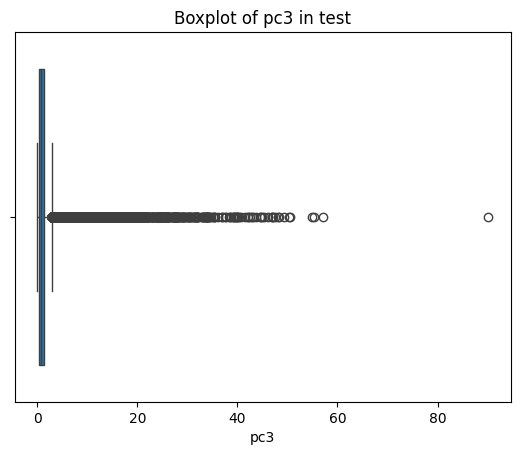

Outliers in test - pc4:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
4            66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015   
224        2339  1.0  2.0  0.080  0.035  0.437500  NaN  0.040    NaN  0.027   
229        2353  0.0  6.0  0.885  0.425  0.480226  0.3  0.306  0.012  0.190   
320        3241  1.0  5.0  2.955  1.225  0.414552  0.2  1.301  0.009  0.881   
341        3435  0.0  3.0  1.260  0.565  0.448413  0.7  0.493  0.140  0.324   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367178  3695134  1.0  2.0  0.830  0.375  0.451807  0.2  0.774  0.037  0.659   
367188  3695233  1.0  4.0  0.755  0.360  0.476821  0.4  0.474  0.007  0.390   
367248  3695907  1.0  0.0  0.265  0.130  0.490566  0.2  0.096  0.002  0.068   
367518  3698796  0.0  6.0  1.795  0.695  0.387187  0.7  0.825  0.136  0.579   
367556  3699218  1.0  4.0  1.040  0.500  0.480769  0.6  1.202  0.058  1.070   

             pc9  pc10    

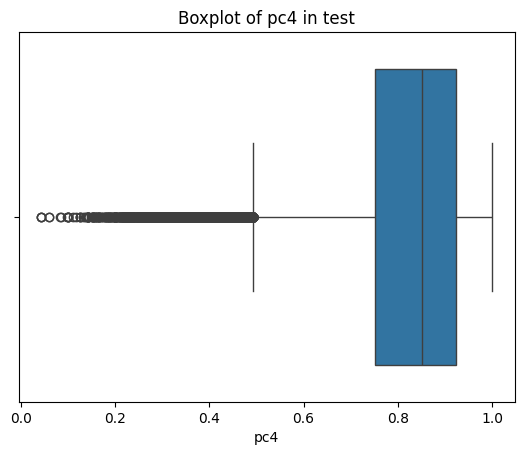

Outliers in test - pc5:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
10          129  1.0  2.0  1.780  1.420  0.797753  3.3  6.086  0.613  5.951   
11          135  1.0  4.0  6.165  4.495  0.729116  4.3  8.167  0.449  7.718   
29          360  1.0  3.0  3.850  3.080  0.800000  3.0  1.821  0.130  1.660   
37          392  1.0  2.0  7.875  7.855  0.997460  4.7  3.024  0.105  3.020   
64          685  1.0  7.0  5.375  4.760  0.885581  5.5  7.522  0.205  7.057   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367587  3699493  1.0  4.0  4.970  4.805  0.966801  5.1  1.500  0.068  1.423   
367603  3699583  1.0  4.0  2.890  2.465  0.852941  4.2  4.364  0.904  4.266   
367627  3699779  1.0  8.0  3.755  3.385  0.901465  4.0  9.784  0.198  9.681   
367629  3699790  1.0  5.0  2.315  1.915  0.827214  3.4  7.373  1.198  7.266   
367661  3700103  1.0  3.0  7.395  7.125  0.963489  3.0  3.714  0.100  3.639   

             pc9  pc10    

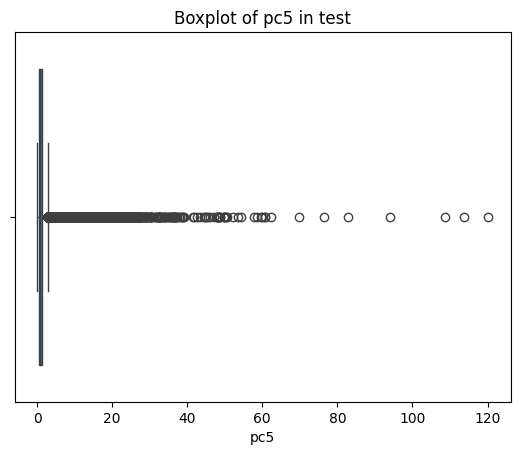

Outliers in test - pc6:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
10          129  1.0  2.0  1.780  1.420  0.797753  3.3  6.086  0.613  5.951   
11          135  1.0  4.0  6.165  4.495  0.729116  4.3  8.167  0.449  7.718   
28          359  1.0  5.0  4.560  3.775  0.827851  2.2  6.738  0.806  6.529   
46          493  1.0  7.0  1.805  1.370  0.759003  0.4  6.694  0.037  6.581   
64          685  1.0  7.0  5.375  4.760  0.885581  5.5  7.522  0.205  7.057   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367627  3699779  1.0  8.0  3.755  3.385  0.901465  4.0  9.784  0.198  9.681   
367629  3699790  1.0  5.0  2.315  1.915  0.827214  3.4  7.373  1.198  7.266   
367632  3699808  1.0  3.0  1.675  1.535  0.916418  2.2  6.068  0.660  6.040   
367637  3699875  1.0  6.0  4.450  3.710  0.833708  2.7  8.482  0.451  8.260   
367700  3700539  1.0  4.0  2.440  2.295  0.940574  1.8  5.874  0.248  5.640   

             pc9  pc10    

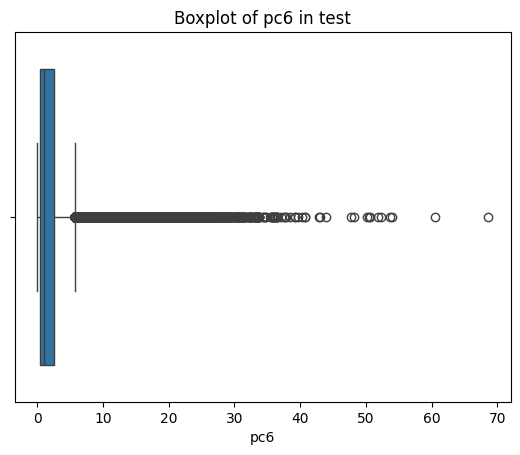

Outliers in test - pc7:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
10          129  1.0  2.0  1.780  1.420  0.797753  3.3  6.086  0.613  5.951   
28          359  1.0  5.0  4.560  3.775  0.827851  2.2  6.738  0.806  6.529   
30          363  0.0  8.0  1.075  0.995  0.925581  1.0  2.632  0.600  2.601   
33          372  0.0  7.0  2.170  2.010  0.926267  1.4  5.518  0.750  5.444   
59          633  1.0  2.0  1.590  1.145  0.720126  1.7  4.829  1.618  4.730   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367629  3699790  1.0  5.0  2.315  1.915  0.827214  3.4  7.373  1.198  7.266   
367632  3699808  1.0  3.0  1.675  1.535  0.916418  2.2  6.068  0.660  6.040   
367643  3699933  1.0  1.0  1.350  1.065  0.788889  2.5  3.472  0.984  3.415   
367674  3700249  0.0  5.0  1.215  1.140  0.938272  2.1  2.601  0.895  2.577   
367701  3700544  1.0  5.0  1.520  1.355  0.891447  1.9  4.617  1.074  4.580   

             pc9  pc10    

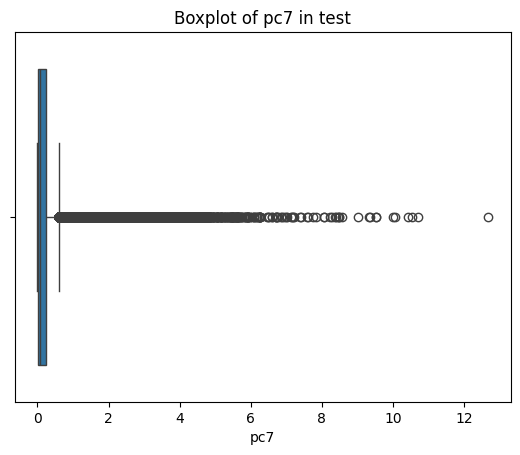

Outliers in test - pc8:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
10          129  1.0  2.0  1.780  1.420  0.797753  3.3  6.086  0.613  5.951   
11          135  1.0  4.0  6.165  4.495  0.729116  4.3  8.167  0.449  7.718   
28          359  1.0  5.0  4.560  3.775  0.827851  2.2  6.738  0.806  6.529   
46          493  1.0  7.0  1.805  1.370  0.759003  0.4  6.694  0.037  6.581   
64          685  1.0  7.0  5.375  4.760  0.885581  5.5  7.522  0.205  7.057   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367627  3699779  1.0  8.0  3.755  3.385  0.901465  4.0  9.784  0.198  9.681   
367629  3699790  1.0  5.0  2.315  1.915  0.827214  3.4  7.373  1.198  7.266   
367632  3699808  1.0  3.0  1.675  1.535  0.916418  2.2  6.068  0.660  6.040   
367637  3699875  1.0  6.0  4.450  3.710  0.833708  2.7  8.482  0.451  8.260   
367700  3700539  1.0  4.0  2.440  2.295  0.940574  1.8  5.874  0.248  5.640   

             pc9  pc10    

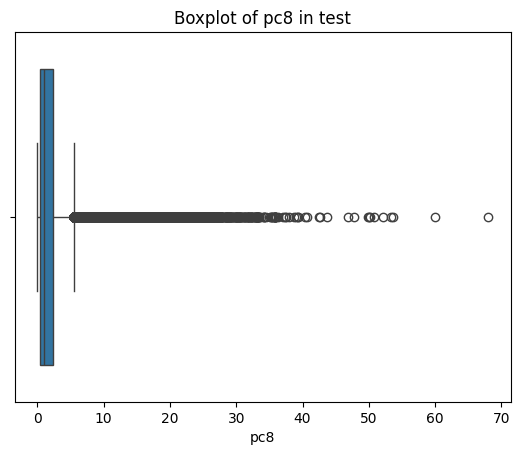

Outliers in test - pc9:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
3            61  0.0  3.0  1.505  0.875  0.581395  0.9  0.425  0.012  0.286   
4            66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015   
16          217  0.0  2.0  0.390  0.290  0.743590  0.3  0.120  0.015  0.096   
18          265  0.0  4.0  1.270  0.780  0.614173  0.7  0.489  0.026  0.357   
20          292  1.0  0.0  0.040  0.020  0.500000  0.1  0.009  0.001  0.005   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367593  3699534  1.0  3.0  0.395  0.225  0.569620  0.6  0.383  0.077  0.321   
367645  3699958  1.0  3.0  0.375  0.300  0.800000  0.1  0.181  0.001  0.151   
367647  3700001  1.0  3.0  0.215  0.130  0.604651  0.8  0.089  0.027  0.072   
367682  3700317  1.0  2.0  0.025  0.015  0.600000  0.1  0.009  0.001  0.007   
367684  3700322  0.0  2.0  0.350  0.220  0.628571  0.3  0.159  0.007  0.131   

             pc9  pc10    

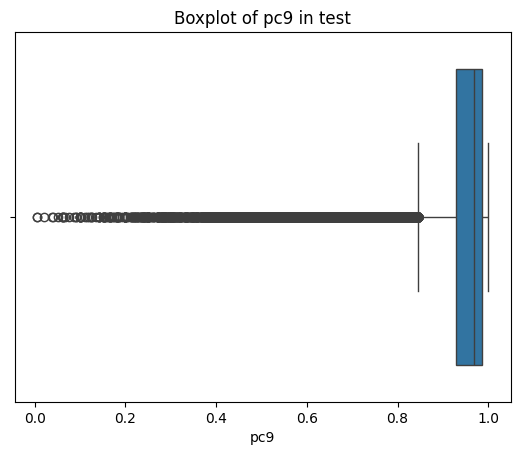

Outliers in test - pc10:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
10          129  1.0  2.0  1.780  1.420  0.797753  3.3  6.086  0.613  5.951   
11          135  1.0  4.0  6.165  4.495  0.729116  4.3  8.167  0.449  7.718   
15          208  1.0  5.0  0.425  0.340  0.800000  0.9  0.374  0.028  0.348   
29          360  1.0  3.0  3.850  3.080  0.800000  3.0  1.821  0.130  1.660   
37          392  1.0  2.0  7.875  7.855  0.997460  4.7  3.024  0.105  3.020   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367661  3700103  1.0  3.0  7.395  7.125  0.963489  3.0  3.714  0.100  3.639   
367674  3700249  0.0  5.0  1.215  1.140  0.938272  2.1  2.601  0.895  2.577   
367679  3700283  1.0  2.0  0.730  0.695  0.952055  1.4  0.783  0.093  0.776   
367691  3700411  1.0  6.0  3.075  2.200  0.715447  2.8  2.753  0.106  2.516   
367700  3700539  1.0  4.0  2.440  2.295  0.940574  1.8  5.874  0.248  5.640   

             pc9  pc10   

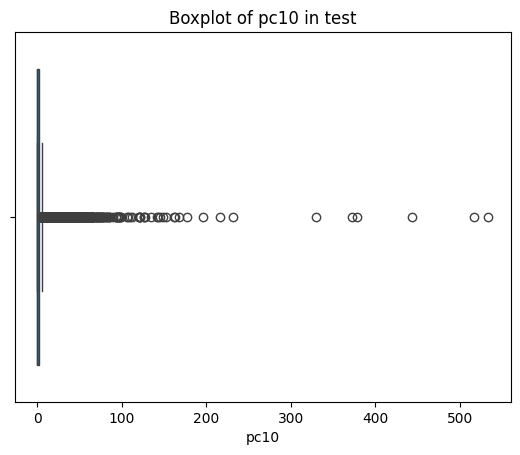

Outliers in test - pc11:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
4            66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015   
224        2339  1.0  2.0  0.080  0.035  0.437500  NaN  0.040    NaN  0.027   
229        2353  0.0  6.0  0.885  0.425  0.480226  0.3  0.306  0.012  0.190   
320        3241  1.0  5.0  2.955  1.225  0.414552  0.2  1.301  0.009  0.881   
341        3435  0.0  3.0  1.260  0.565  0.448413  0.7  0.493  0.140  0.324   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367178  3695134  1.0  2.0  0.830  0.375  0.451807  0.2  0.774  0.037  0.659   
367188  3695233  1.0  4.0  0.755  0.360  0.476821  0.4  0.474  0.007  0.390   
367248  3695907  1.0  0.0  0.265  0.130  0.490566  0.2  0.096  0.002  0.068   
367518  3698796  0.0  6.0  1.795  0.695  0.387187  0.7  0.825  0.136  0.579   
367556  3699218  1.0  4.0  1.040  0.500  0.480769  0.6  1.202  0.058  1.070   

             pc9  pc10   

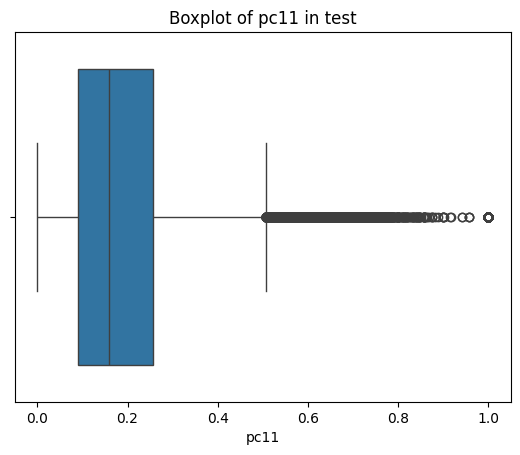

Outliers in test - pc12:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
3            61  0.0  3.0  1.505  0.875  0.581395  0.9  0.425  0.012  0.286   
4            66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015   
16          217  0.0  2.0  0.390  0.290  0.743590  0.3  0.120  0.015  0.096   
18          265  0.0  4.0  1.270  0.780  0.614173  0.7  0.489  0.026  0.357   
20          292  1.0  0.0  0.040  0.020  0.500000  0.1  0.009  0.001  0.005   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367593  3699534  1.0  3.0  0.395  0.225  0.569620  0.6  0.383  0.077  0.321   
367645  3699958  1.0  3.0  0.375  0.300  0.800000  0.1  0.181  0.001  0.151   
367647  3700001  1.0  3.0  0.215  0.130  0.604651  0.8  0.089  0.027  0.072   
367682  3700317  1.0  2.0  0.025  0.015  0.600000  0.1  0.009  0.001  0.007   
367684  3700322  0.0  2.0  0.350  0.220  0.628571  0.3  0.159  0.007  0.131   

             pc9  pc10   

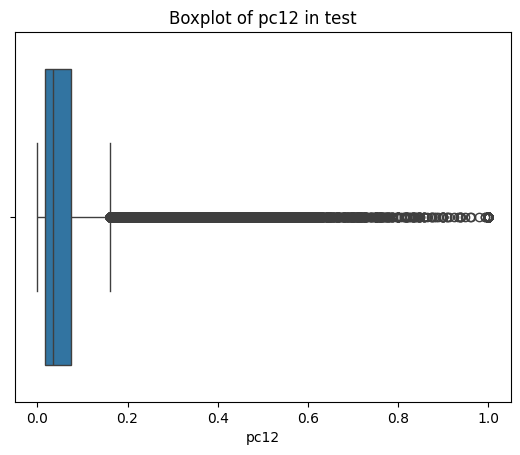

Outliers in test - pc13:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9           118  1.0  0.0  0.040  0.030  0.750000  0.1  0.013  0.003  0.011   
13          200  0.0  4.0  0.010  0.010  1.000000  0.1  0.002  0.001  0.002   
15          208  1.0  5.0  0.425  0.340  0.800000  0.9  0.374  0.028  0.348   
20          292  1.0  0.0  0.040  0.020  0.500000  0.1  0.009  0.001  0.005   
45          463  1.0  5.0  0.560  0.540  0.964286  1.5  0.715  0.099  0.704   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367540  3699045  1.0  3.0  0.485  0.295  0.608247  0.9  0.257  0.042  0.215   
367593  3699534  1.0  3.0  0.395  0.225  0.569620  0.6  0.383  0.077  0.321   
367594  3699535  1.0  0.0  0.195  0.185  0.948718  0.5  0.145  0.009  0.140   
367647  3700001  1.0  3.0  0.215  0.130  0.604651  0.8  0.089  0.027  0.072   
367682  3700317  1.0  2.0  0.025  0.015  0.600000  0.1  0.009  0.001  0.007   

             pc9  pc10   

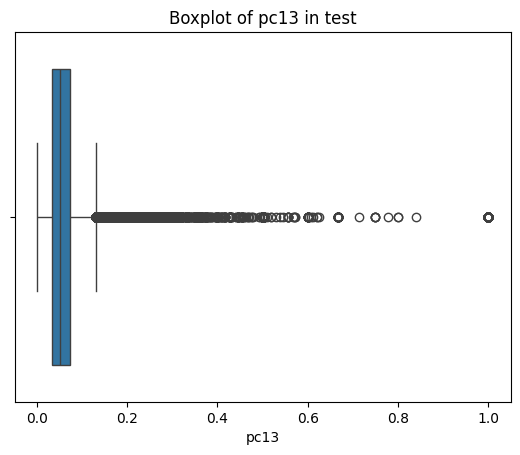

Outliers in test - pc14:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
1189      12271  0.0  8.0  1.625  1.420  0.873846  0.7  1.230  0.029  1.186   
1293      13248  0.0  3.0  0.080  0.080  1.000000  0.1  0.194  0.085  0.194   
1618      16217  0.0  5.0  0.430  0.350  0.813953  0.1  0.323  0.093  0.307   
3005      29814  0.0  5.0  2.215  1.770  0.799097  0.8  2.595  0.026  2.495   
3191      31570  0.0  5.0  1.220  0.855  0.700820  0.7  0.646  0.011  0.547   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
364947  3672643  1.0  3.0  0.205  0.150  0.731707  0.2  0.149  0.061  0.138   
365497  3678442  1.0  3.0  0.875  0.745  0.851429  0.7  1.073  0.011  1.044   
365917  3682710  1.0  4.0  0.255  0.195  0.764706  0.2  1.104  0.005  1.092   
366355  3686923  1.0  7.0  0.540  0.500  0.925926  0.7  0.540  0.012  0.525   
366819  3691714  0.0  6.0  1.940  1.345  0.693299  0.8  1.518  0.014  1.353   

             pc9  pc10   

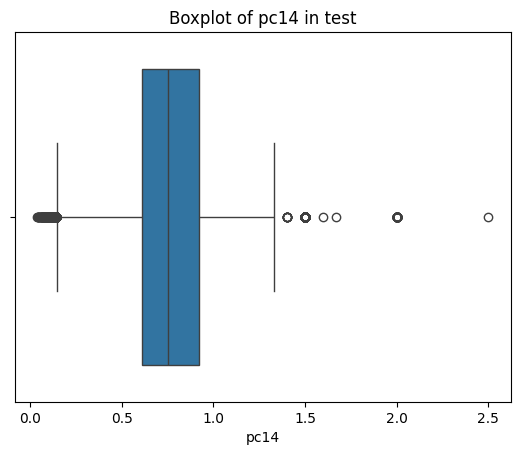

Outliers in test - pc15:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9           118  1.0  0.0  0.040  0.030  0.750000  0.1  0.013  0.003  0.011   
15          208  1.0  5.0  0.425  0.340  0.800000  0.9  0.374  0.028  0.348   
27          335  1.0  6.0  0.340  0.280  0.823529  0.7  0.391  0.059  0.369   
75          783  0.0  5.0  0.235  0.205  0.872340  0.8  1.167  0.177  1.160   
79          826  1.0  5.0  1.190  0.925  0.777311  2.7  3.830  1.073  3.760   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367610  3699638  1.0  1.0  0.250  0.220  0.880000  0.4  1.156  0.444  1.149   
367647  3700001  1.0  3.0  0.215  0.130  0.604651  0.8  0.089  0.027  0.072   
367665  3700130  1.0  5.0  0.135  0.100  0.740741  0.1  0.140  0.002  0.133   
367679  3700283  1.0  2.0  0.730  0.695  0.952055  1.4  0.783  0.093  0.776   
367682  3700317  1.0  2.0  0.025  0.015  0.600000  0.1  0.009  0.001  0.007   

             pc9  pc10   

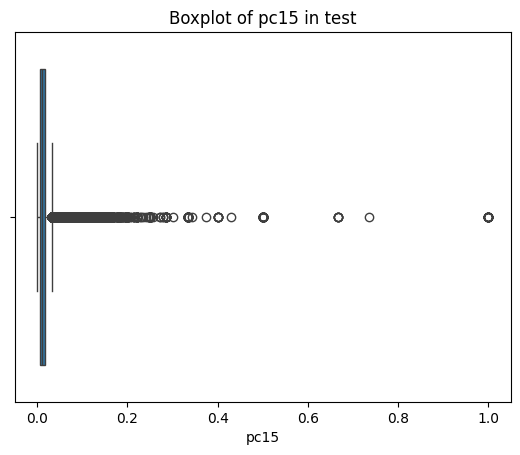

Outliers in test - pc16:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9           118  1.0  0.0  0.040  0.030  0.750000  0.1  0.013  0.003  0.011   
15          208  1.0  5.0  0.425  0.340  0.800000  0.9  0.374  0.028  0.348   
153        1513  1.0  3.0  0.135  0.095  0.703704  0.1  0.065  0.002  0.057   
167        1659  1.0  6.0  0.620  0.375  0.604839  0.4  0.271  0.026  0.215   
169        1694  0.0  8.0  0.030  0.025  0.833333  0.1  0.102  0.001  0.030   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367647  3700001  1.0  3.0  0.215  0.130  0.604651  0.8  0.089  0.027  0.072   
367665  3700130  1.0  5.0  0.135  0.100  0.740741  0.1  0.140  0.002  0.133   
367668  3700173  1.0  3.0  0.835  0.835  1.000000  0.4  1.391  0.230  1.391   
367676  3700275  1.0  5.0  2.340  2.030  0.867521  0.3  2.071  0.378  2.003   
367682  3700317  1.0  2.0  0.025  0.015  0.600000  0.1  0.009  0.001  0.007   

             pc9  pc10   

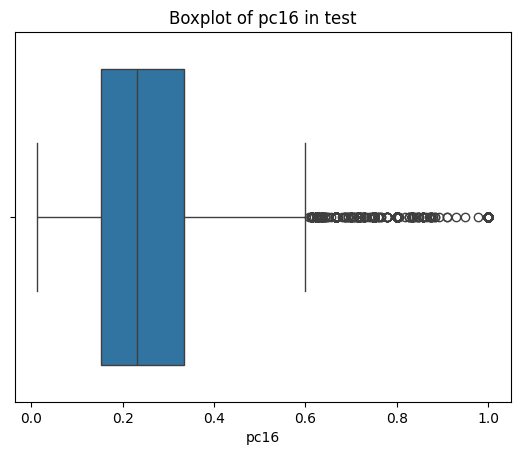

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Detect and visualize outliers for numerical columns in each dataset
for df, name in [(loan_activities, "loan_activities"), (non_borrower_user, "non_borrower_user"), (train, "train"), (test, "test")]:
    for column in df.select_dtypes(include=['number']):
        outliers = detect_outliers_iqr(df, column)
        if not outliers.empty:
            print(f"Outliers in {name} - {column}:\n", outliers)

            # Visualize outliers using boxplot
            plt.figure()
            sns.boxplot(x=df[column])
            plt.title(f"Boxplot of {column} in {name}")
            plt.show()


Outliers in loan_activities - loan_type:
          user_id  reference_contact  loan_type   ts
3950810  1152830            3452802         10    2
3950811  3598472            1889638         10   11
3950812  2527037            1688268         10   21
3950813  3172548            2045439         10  807
3950814   901273            1251581         10  363
...          ...                ...        ...  ...
4300994   468400            2004356         11  493
4300995  2844279            1657495         11  609
4300996  1071963            2316823         11    1
4300997  2803447            3513529         11  367
4300998  3342102             522089         11  427

[350189 rows x 4 columns]


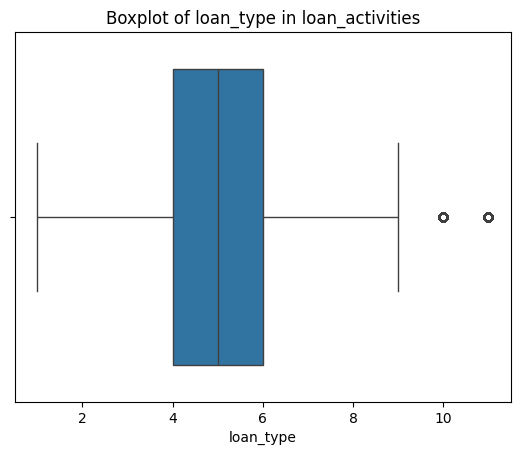

Outliers in non_borrower_user - pc0:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
1              1  0.0  8.0  0.630  0.565  0.896825  0.6  2.298  0.210  2.284   
3              6  0.0  1.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
5              8  0.0  8.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
15            24  0.0  8.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
28            40  0.0  8.0  0.040  0.040  1.000000  NaN  0.024    NaN  0.024   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048543  1568248  0.0  4.0  0.540  0.525  0.972222  1.4  0.680  0.171  0.677   
1048547  1568255  0.0  2.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
1048554  1568267  0.0  8.0  0.215  0.210  0.976744  0.1  0.259  0.055  0.258   
1048562  1568280  0.0  4.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
1048571  1568292  0.0  6.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   

 

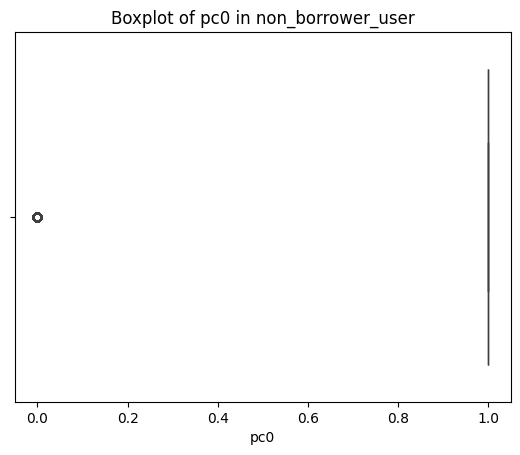

Outliers in non_borrower_user - pc2:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
14            23  1.0  7.0  1.960  1.955  0.997449  3.2  1.559  0.097  1.558   
49            67  1.0  3.0  2.575  1.625  0.631068  0.8  2.941  0.417  2.709   
88           130  1.0  0.0  3.995  3.665  0.917397  2.0  1.338  0.029  1.263   
98           141  1.0  1.0  1.770  1.615  0.912429  1.5  2.577  0.248  2.540   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048238  1567807  NaN  NaN  2.565  2.350  0.916179  0.6  2.424  0.051  2.331   
1048243  1567815  NaN  NaN  2.625  2.415  0.920000  2.1  4.294  0.358  4.118   
1048306  1567902  1.0  7.0  2.125  2.080  0.978824  2.3  2.214  0.213  2.156   
1048435  1568093  1.0  7.0  4.140  4.110  0.992754  4.9  2.378  0.601  2.372   
1048472  1568147  1.0  7.0  3.240  3.170  0.978395  1.2  1.494  0.065  1.477   

 

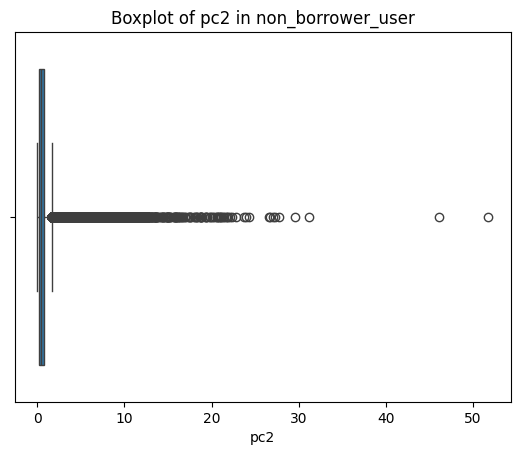

Outliers in non_borrower_user - pc3:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
14            23  1.0  7.0  1.960  1.955  0.997449  3.2  1.559  0.097  1.558   
49            67  1.0  3.0  2.575  1.625  0.631068  0.8  2.941  0.417  2.709   
88           130  1.0  0.0  3.995  3.665  0.917397  2.0  1.338  0.029  1.263   
98           141  1.0  1.0  1.770  1.615  0.912429  1.5  2.577  0.248  2.540   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048243  1567815  NaN  NaN  2.625  2.415  0.920000  2.1  4.294  0.358  4.118   
1048306  1567902  1.0  7.0  2.125  2.080  0.978824  2.3  2.214  0.213  2.156   
1048435  1568093  1.0  7.0  4.140  4.110  0.992754  4.9  2.378  0.601  2.372   
1048472  1568147  1.0  7.0  3.240  3.170  0.978395  1.2  1.494  0.065  1.477   
1048520  1568216  1.0  1.0  1.605  1.505  0.937695  0.4  0.627  0.005  0.566   

 

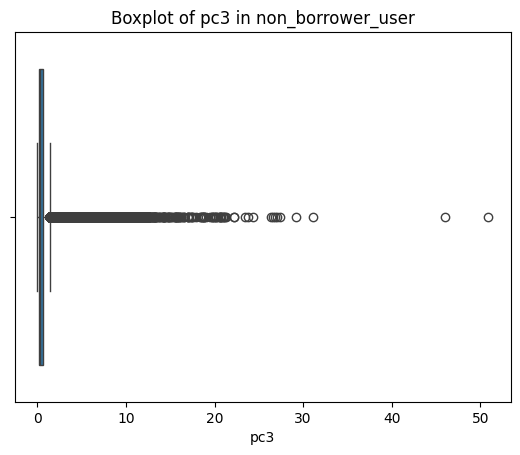

Outliers in non_borrower_user - pc4:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
84           123  1.0  8.0  1.050  0.575  0.547619  0.3  0.563  0.006  0.427   
193          266  1.0  1.0  0.265  0.150  0.566038  0.2  0.124  0.002  0.101   
199          275  1.0  5.0  0.885  0.525  0.593220  0.3  0.874  0.026  0.736   
292          433  1.0  5.0  0.205  0.095  0.463415  NaN  0.068    NaN  0.043   
361          540  1.0  5.0  0.275  0.150  0.545455  0.2  0.142  0.013  0.117   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048218  1567771  1.0  2.0  0.300  0.160  0.533333  0.3  0.137  0.009  0.104   
1048240  1567811  1.0  2.0  0.410  0.195  0.475610  0.1  0.170  0.010  0.114   
1048446  1568114  1.0  3.0  1.000  0.405  0.405000  0.1  0.376  0.001  0.246   
1048560  1568276  1.0  1.0  0.080  0.035  0.437500  0.2  0.040  0.003  0.031   
1048574  1568298  1.0  3.0  0.190  0.110  0.578947  0.1  0.070  0.004  0.054   

 

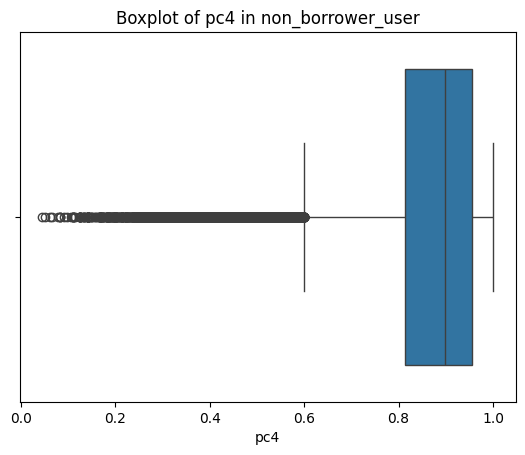

Outliers in non_borrower_user - pc5:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
14            23  1.0  7.0  1.960  1.955  0.997449  3.2  1.559  0.097  1.558   
51            70  1.0  6.0  1.100  1.080  0.981818  1.8  0.984  0.087  0.976   
88           130  1.0  0.0  3.995  3.665  0.917397  2.0  1.338  0.029  1.263   
139          192  1.0  5.0  2.290  2.050  0.895197  3.2  3.924  0.388  3.861   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048306  1567902  1.0  7.0  2.125  2.080  0.978824  2.3  2.214  0.213  2.156   
1048435  1568093  1.0  7.0  4.140  4.110  0.992754  4.9  2.378  0.601  2.372   
1048482  1568159  1.0  5.0  1.320  1.235  0.935606  1.9  2.771  0.606  2.743   
1048513  1568206  1.0  5.0  1.415  1.400  0.989399  3.2  3.442  0.537  3.439   
1048569  1568289  1.0  7.0  1.585  1.195  0.753943  2.2  2.402  0.350  2.291   

 

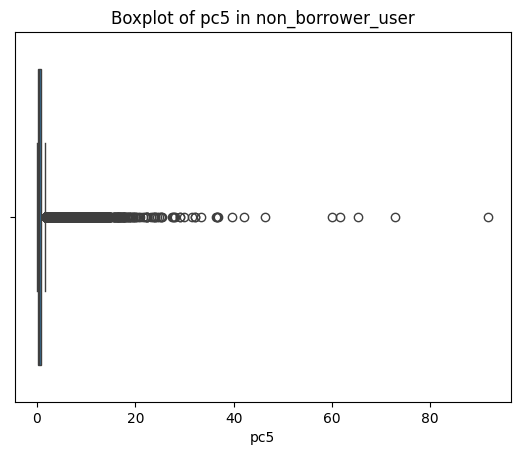

Outliers in non_borrower_user - pc6:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
7             12  1.0  5.0  0.830  0.810  0.975904  0.3  8.549  0.045  8.545   
49            67  1.0  3.0  2.575  1.625  0.631068  0.8  2.941  0.417  2.709   
98           141  1.0  1.0  1.770  1.615  0.912429  1.5  2.577  0.248  2.540   
136          189  0.0  5.0  0.820  0.790  0.963415  0.8  2.871  1.042  2.859   
139          192  1.0  5.0  2.290  2.050  0.895197  3.2  3.924  0.388  3.861   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048201  1567747  1.0  8.0  7.625  7.310  0.958689  1.5  4.695  0.038  4.622   
1048243  1567815  NaN  NaN  2.625  2.415  0.920000  2.1  4.294  0.358  4.118   
1048430  1568088  1.0  3.0  0.905  0.660  0.729282  0.4  3.419  0.981  3.365   
1048482  1568159  1.0  5.0  1.320  1.235  0.935606  1.9  2.771  0.606  2.743   
1048513  1568206  1.0  5.0  1.415  1.400  0.989399  3.2  3.442  0.537  3.439   

 

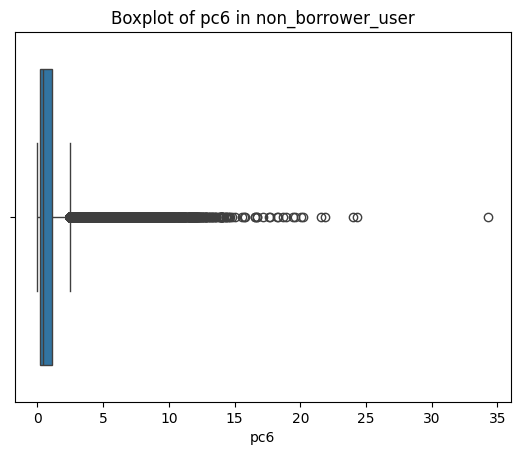

Outliers in non_borrower_user - pc7:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
37            52  1.0  4.0  1.055  0.900  0.853081  1.7  2.138  0.377  2.103   
39            55  1.0  2.0  0.515  0.445  0.864078  1.0  2.414  0.690  2.319   
49            67  1.0  3.0  2.575  1.625  0.631068  0.8  2.941  0.417  2.709   
62            84  1.0  3.0  0.540  0.510  0.944444  1.1  1.975  0.255  1.969   
125          174  1.0  1.0  0.575  0.510  0.886957  0.8  1.244  0.252  1.228   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048487  1568167  1.0  2.0  0.685  0.610  0.890511  1.2  1.568  0.287  1.547   
1048513  1568206  1.0  5.0  1.415  1.400  0.989399  3.2  3.442  0.537  3.439   
1048550  1568259  1.0  5.0  0.345  0.315  0.913043  0.3  1.011  0.654  1.005   
1048555  1568268  1.0  5.0  0.960  0.785  0.817708  0.8  1.318  0.422  1.267   
1048569  1568289  1.0  7.0  1.585  1.195  0.753943  2.2  2.402  0.350  2.291   

 

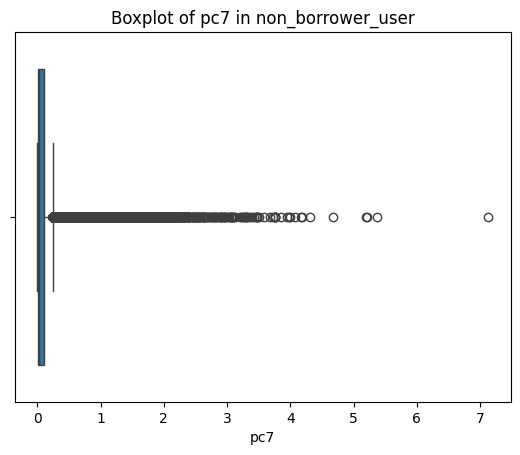

Outliers in non_borrower_user - pc8:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
7             12  1.0  5.0  0.830  0.810  0.975904  0.3  8.549  0.045  8.545   
49            67  1.0  3.0  2.575  1.625  0.631068  0.8  2.941  0.417  2.709   
98           141  1.0  1.0  1.770  1.615  0.912429  1.5  2.577  0.248  2.540   
136          189  0.0  5.0  0.820  0.790  0.963415  0.8  2.871  1.042  2.859   
139          192  1.0  5.0  2.290  2.050  0.895197  3.2  3.924  0.388  3.861   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048201  1567747  1.0  8.0  7.625  7.310  0.958689  1.5  4.695  0.038  4.622   
1048243  1567815  NaN  NaN  2.625  2.415  0.920000  2.1  4.294  0.358  4.118   
1048430  1568088  1.0  3.0  0.905  0.660  0.729282  0.4  3.419  0.981  3.365   
1048482  1568159  1.0  5.0  1.320  1.235  0.935606  1.9  2.771  0.606  2.743   
1048513  1568206  1.0  5.0  1.415  1.400  0.989399  3.2  3.442  0.537  3.439   

 

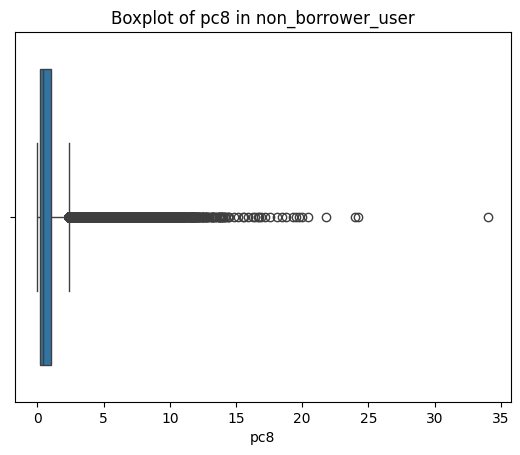

Outliers in non_borrower_user - pc9:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
70           100  1.0  6.0  0.560  0.470  0.839286  0.1  0.231  0.007  0.200   
76           112  1.0  3.0  0.605  0.440  0.727273  1.0  0.281  0.023  0.244   
84           123  1.0  8.0  1.050  0.575  0.547619  0.3  0.563  0.006  0.427   
118          163  0.0  4.0  0.905  0.765  0.845304  0.5  0.228  0.007  0.192   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048446  1568114  1.0  3.0  1.000  0.405  0.405000  0.1  0.376  0.001  0.246   
1048469  1568143  1.0  4.0  0.025  0.020  0.800000  0.1  0.007  0.001  0.006   
1048481  1568158  NaN  NaN  0.555  0.420  0.756757  NaN  0.172    NaN  0.144   
1048560  1568276  1.0  1.0  0.080  0.035  0.437500  0.2  0.040  0.003  0.031   
1048574  1568298  1.0  3.0  0.190  0.110  0.578947  0.1  0.070  0.004  0.054   

 

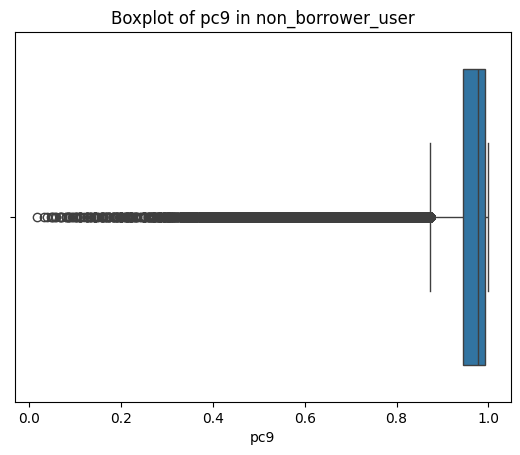

Outliers in non_borrower_user - pc10:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
1              1  0.0  8.0  0.630  0.565  0.896825  0.6  2.298  0.210  2.284   
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
11            19  1.0  3.0  0.150  0.120  0.800000  0.1  0.304  0.010  0.297   
14            23  1.0  7.0  1.960  1.955  0.997449  3.2  1.559  0.097  1.558   
17            26  NaN  NaN  0.170  0.165  0.970588  0.2  0.208  0.007  0.206   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048555  1568268  1.0  5.0  0.960  0.785  0.817708  0.8  1.318  0.422  1.267   
1048557  1568270  1.0  3.0  0.790  0.735  0.930380  1.6  1.423  0.127  1.408   
1048564  1568282  1.0  1.0  0.750  0.650  0.866667  0.2  0.797  0.013  0.773   
1048566  1568285  1.0  4.0  0.255  0.250  0.980392  0.7  0.376  0.028  0.374   
1048569  1568289  1.0  7.0  1.585  1.195  0.753943  2.2  2.402  0.350  2.291   



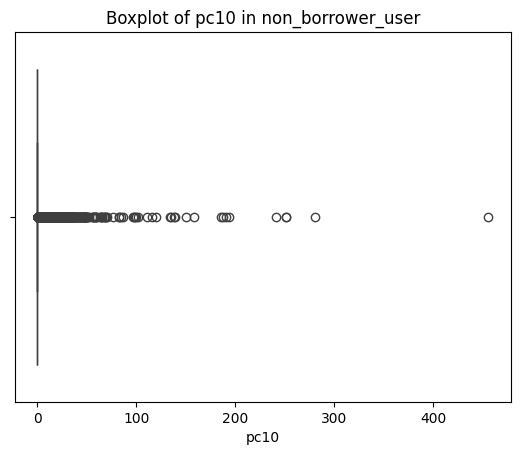

Outliers in non_borrower_user - pc11:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
84           123  1.0  8.0  1.050  0.575  0.547619  0.3  0.563  0.006  0.427   
193          266  1.0  1.0  0.265  0.150  0.566038  0.2  0.124  0.002  0.101   
292          433  1.0  5.0  0.205  0.095  0.463415  NaN  0.068    NaN  0.043   
361          540  1.0  5.0  0.275  0.150  0.545455  0.2  0.142  0.013  0.117   
573          858  1.0  0.0  0.985  0.565  0.573604  0.4  0.613  0.146  0.519   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048218  1567771  1.0  2.0  0.300  0.160  0.533333  0.3  0.137  0.009  0.104   
1048240  1567811  1.0  2.0  0.410  0.195  0.475610  0.1  0.170  0.010  0.114   
1048446  1568114  1.0  3.0  1.000  0.405  0.405000  0.1  0.376  0.001  0.246   
1048560  1568276  1.0  1.0  0.080  0.035  0.437500  0.2  0.040  0.003  0.031   
1048574  1568298  1.0  3.0  0.190  0.110  0.578947  0.1  0.070  0.004  0.054   



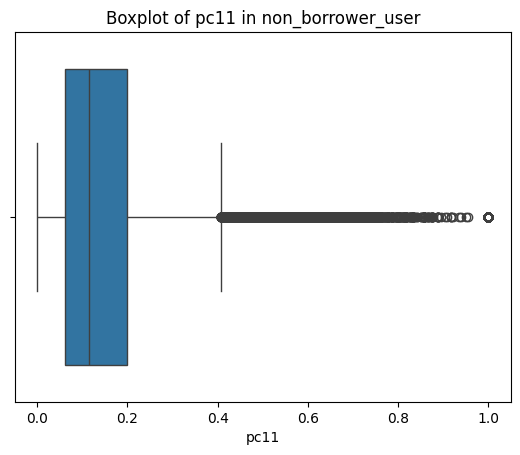

Outliers in non_borrower_user - pc12:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9             15  1.0  3.0  2.190  2.145  0.979452  1.8  1.415  0.025  0.847   
84           123  1.0  8.0  1.050  0.575  0.547619  0.3  0.563  0.006  0.427   
118          163  0.0  4.0  0.905  0.765  0.845304  0.5  0.228  0.007  0.192   
188          260  1.0  3.0  0.520  0.385  0.740385  NaN  0.191    NaN  0.164   
193          266  1.0  1.0  0.265  0.150  0.566038  0.2  0.124  0.002  0.101   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048446  1568114  1.0  3.0  1.000  0.405  0.405000  0.1  0.376  0.001  0.246   
1048469  1568143  1.0  4.0  0.025  0.020  0.800000  0.1  0.007  0.001  0.006   
1048481  1568158  NaN  NaN  0.555  0.420  0.756757  NaN  0.172    NaN  0.144   
1048560  1568276  1.0  1.0  0.080  0.035  0.437500  0.2  0.040  0.003  0.031   
1048574  1568298  1.0  3.0  0.190  0.110  0.578947  0.1  0.070  0.004  0.054   



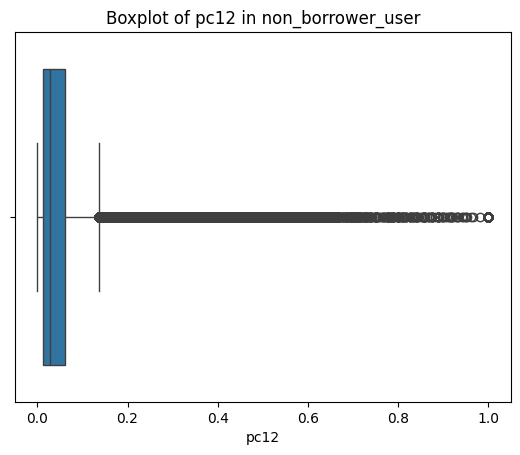

Outliers in non_borrower_user - pc13:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
78           114  1.0  8.0  0.105  0.090  0.857143  0.6  0.149  0.039  0.144   
148          207  1.0  4.0  0.170  0.165  0.970588  0.6  0.155  0.038  0.154   
184          256  1.0  3.0  0.075  0.060  0.800000  0.2  0.075  0.056  0.072   
245          346  1.0  3.0  0.380  0.300  0.789474  1.2  1.273  0.468  1.254   
253          357  1.0  3.0  1.310  1.090  0.832061  3.9  0.826  0.144  0.780   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048338  1567947  1.0  0.0  0.285  0.230  0.807018  0.8  0.135  0.039  0.122   
1048442  1568107  1.0  1.0  0.020  0.020  1.000000  0.1  0.009  0.003  0.009   
1048467  1568141  1.0  1.0  0.065  0.050  0.769231  0.3  0.047  0.024  0.044   
1048469  1568143  1.0  4.0  0.025  0.020  0.800000  0.1  0.007  0.001  0.006   
1048560  1568276  1.0  1.0  0.080  0.035  0.437500  0.2  0.040  0.003  0.031   



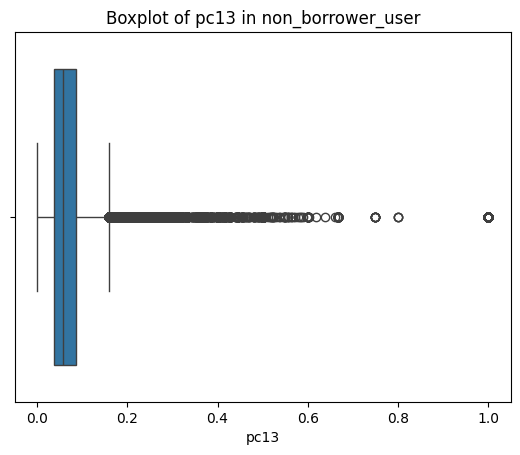

Outliers in non_borrower_user - pc14:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
635          946  0.0  5.0  0.760  0.580  0.763158  1.0  0.999  0.567  0.959   
3589        5369  1.0  5.0  1.625  1.160  0.713846  0.7  1.696  0.023  1.600   
4427        6608  1.0  1.0  0.040  0.040  1.000000  0.1  0.079  0.023  0.079   
4720        7055  1.0  3.0  0.625  0.560  0.896000  0.8  0.447  0.014  0.426   
6209        9267  0.0  8.0  0.070  0.070  1.000000  0.1  0.116  0.043  0.116   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1040383  1556124  0.0  0.0  0.080  0.080  1.000000  0.1  1.280  0.519  1.280   
1040794  1556711  0.0  8.0  0.195  0.165  0.846154  0.2  0.163  0.009  0.157   
1042930  1559913  0.0  5.0  1.285  0.895  0.696498  0.7  1.019  0.010  0.924   
1044586  1562409  1.0  8.0  0.685  0.560  0.817518  0.6  0.653  0.071  0.628   
1046686  1565502  0.0  3.0  0.240  0.165  0.687500  0.1  0.209  0.066  0.193   



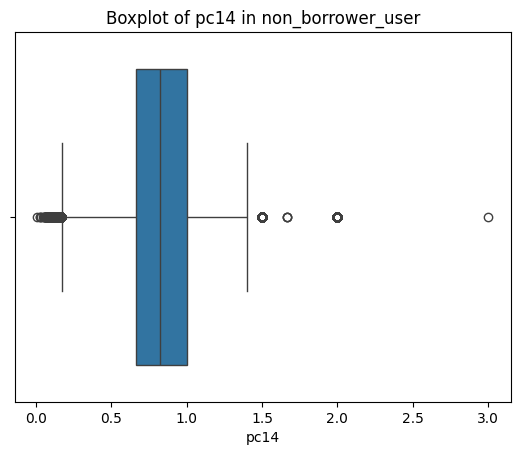

Outliers in non_borrower_user - pc15:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
74           105  0.0  7.0  0.110  0.095  0.863636  0.2  0.192  0.018  0.189   
78           114  1.0  8.0  0.105  0.090  0.857143  0.6  0.149  0.039  0.144   
163          227  1.0  5.0  0.100  0.095  0.950000  0.3  0.102  0.022  0.101   
201          277  0.0  7.0  0.060  0.060  1.000000  0.1  0.015  0.001  0.015   
245          346  1.0  3.0  0.380  0.300  0.789474  1.2  1.273  0.468  1.254   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048124  1567643  NaN  NaN  0.055  0.055  1.000000  0.4  0.024  0.010  0.024   
1048212  1567765  0.0  7.0  0.020  0.020  1.000000  0.1  0.006  0.001  0.006   
1048338  1567947  1.0  0.0  0.285  0.230  0.807018  0.8  0.135  0.039  0.122   
1048372  1568000  1.0  3.0  0.140  0.140  1.000000  0.4  0.228  0.013  0.228   
1048487  1568167  1.0  2.0  0.685  0.610  0.890511  1.2  1.568  0.287  1.547   



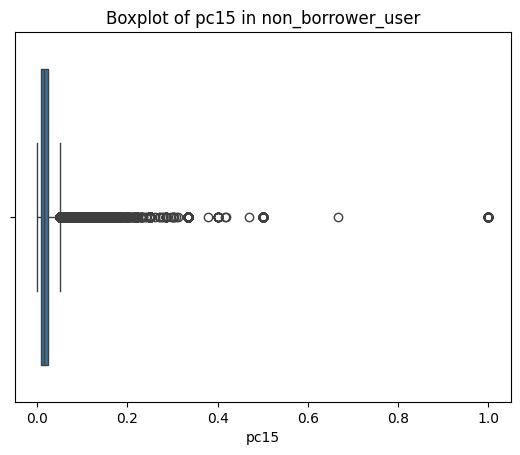

Outliers in non_borrower_user - pc16:
          user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
11            19  1.0  3.0  0.150  0.120  0.800000  0.1  0.304  0.010  0.297   
74           105  0.0  7.0  0.110  0.095  0.863636  0.2  0.192  0.018  0.189   
201          277  0.0  7.0  0.060  0.060  1.000000  0.1  0.015  0.001  0.015   
334          505  1.0  5.0  0.070  0.070  1.000000  0.1  0.053  0.003  0.053   
394          586  0.0  0.0  0.450  0.400  0.888889  0.1  0.203  0.015  0.192   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
1048145  1567671  1.0  3.0  0.170  0.170  1.000000  0.1  0.191  0.001  0.191   
1048212  1567765  0.0  7.0  0.020  0.020  1.000000  0.1  0.006  0.001  0.006   
1048309  1567906  0.0  3.0  0.115  0.115  1.000000  0.1  0.204  0.006  0.204   
1048406  1568051  0.0  4.0  0.130  0.110  0.846154  0.1  0.143  0.030  0.139   
1048446  1568114  1.0  3.0  1.000  0.405  0.405000  0.1  0.376  0.001  0.246   



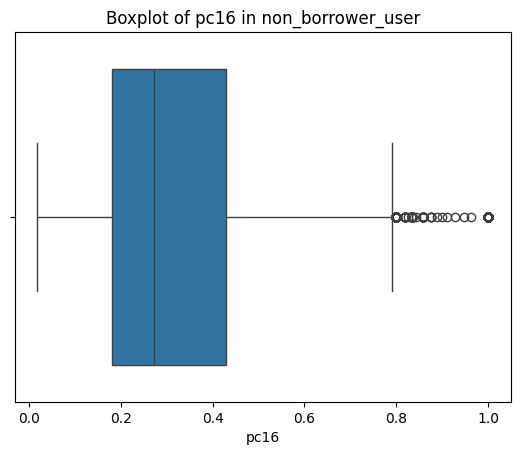

Outliers in train - pc0:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
1             5  0.0  0.0  0.430  0.365  0.848837  0.4  1.253  0.210  1.235   
3            10  0.0  5.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
6            22  0.0  6.0  1.365  1.255  0.919414  1.5  4.450  0.048  4.425   
12           54  0.0  8.0  0.065  0.055  0.846154  0.2  0.059  0.002  0.057   
13           68  0.0  4.0  0.120  0.120  1.000000  0.4  0.233  0.028  0.233   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857881  3700472  0.0  2.0  0.395  0.305  0.772152  0.6  0.480  0.029  0.451   
857882  3700474  0.0  4.0  7.170  5.860  0.817294  5.0  7.597  0.138  7.282   
857889  3700501  0.0  5.0  0.910  0.860  0.945055  0.5  1.935  0.019  1.923   
857891  3700506  0.0  5.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
857898  3700548  0.0  4.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   

             pc9  pc10   

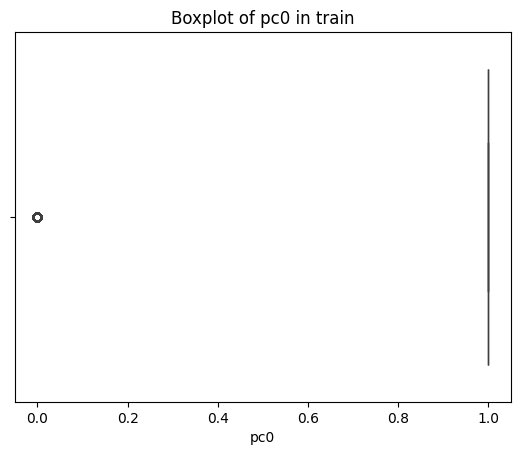

Outliers in train - pc2:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
8            32  1.0  4.0  5.735  2.520  0.439407  1.1   2.404  0.075   1.525   
63          309  1.0  6.0  5.855  5.155  0.880444  4.7   2.668  0.115   2.429   
71          341  1.0  5.0  3.990  3.885  0.973684  2.6   1.795  0.316   1.767   
78          367  0.0  2.0  5.240  4.240  0.809160  3.3  10.074  1.508   9.857   
125         524  1.0  5.0  3.745  2.665  0.711615  1.7   6.786  0.214   6.526   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
857725  3699821  1.0  3.0  5.815  5.400  0.928633  3.4   4.698  0.136   4.607   
857749  3699930  0.0  6.0  6.280  4.850  0.772293  5.0  11.607  2.875  11.200   
857848  3700357  1.0  1.0  4.700  4.385  0.932979  3.3   2.151  0.250   2.077   
857860  3700401  1.0  5.0  5.430  4.635  0.853591  4.3   4.460  0.523   4.277   
857882  3700474  0.0  4.0  7.170  5.860  0.817294  5.0   7.597  0.138   7.282   

 

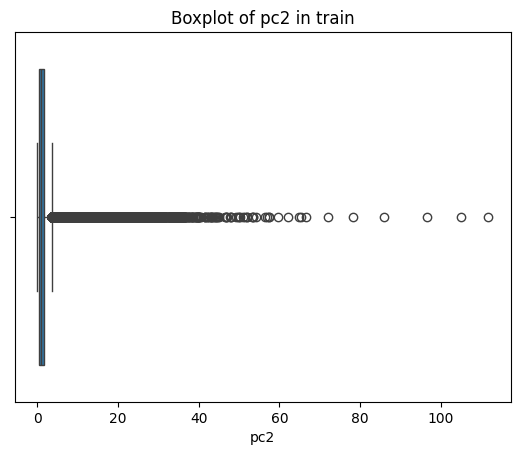

Outliers in train - pc3:
         user_id  pc0  pc1    pc2    pc3       pc4   pc5     pc6    pc7  \
63          309  1.0  6.0  5.855  5.155  0.880444   4.7   2.668  0.115   
71          341  1.0  5.0  3.990  3.885  0.973684   2.6   1.795  0.316   
78          367  0.0  2.0  5.240  4.240  0.809160   3.3  10.074  1.508   
141         602  1.0  4.0  4.110  3.315  0.806569   4.1  14.960  3.617   
177         735  1.0  6.0  7.460  7.160  0.959786   3.9   4.006  0.661   
...         ...  ...  ...    ...    ...       ...   ...     ...    ...   
857749  3699930  0.0  6.0  6.280  4.850  0.772293   5.0  11.607  2.875   
857814  3700243  0.0  2.0  3.230  3.015  0.933437  10.7   1.918  0.126   
857848  3700357  1.0  1.0  4.700  4.385  0.932979   3.3   2.151  0.250   
857860  3700401  1.0  5.0  5.430  4.635  0.853591   4.3   4.460  0.523   
857882  3700474  0.0  4.0  7.170  5.860  0.817294   5.0   7.597  0.138   

           pc8       pc9  pc10      pc11      pc12      pc13      pc14  \
63       2.

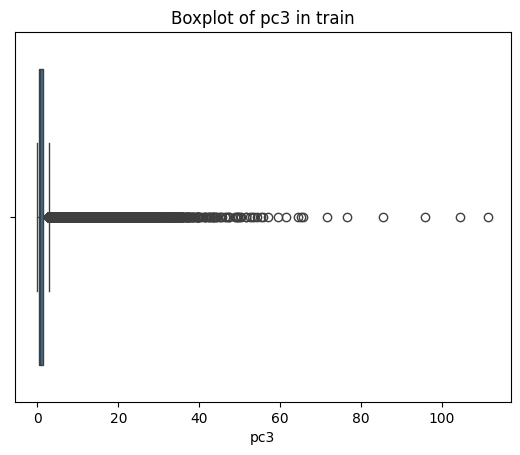

Outliers in train - pc4:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
8            32  1.0  4.0  5.735  2.520  0.439407  1.1  2.404  0.075  1.525   
171         712  0.0  3.0  1.130  0.535  0.473451  0.2  1.085  0.002  0.850   
210         890  1.0  5.0  0.430  0.195  0.453488  NaN  0.279    NaN  0.229   
308        1324  1.0  6.0  3.005  1.475  0.490849  1.5  3.664  0.066  3.149   
322        1363  1.0  5.0  1.400  0.570  0.407143  0.2  1.774  0.078  1.598   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857667  3699579  0.0  3.0  0.165  0.055  0.333333  0.1  0.035  0.001  0.013   
857674  3699615  1.0  7.0  1.175  0.240  0.204255  0.1  0.541  0.003  0.345   
857700  3699726  1.0  6.0  1.165  0.515  0.442060  0.5  1.082  0.068  0.947   
857726  3699825  1.0  5.0  1.190  0.320  0.268908  0.3  0.305  0.005  0.119   
857857  3700387  1.0  6.0  0.930  0.305  0.327957  0.1  0.341  0.002  0.209   

             pc9  pc10   

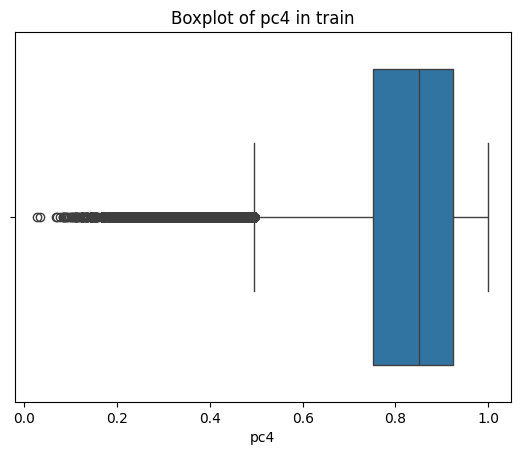

Outliers in train - pc5:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
63          309  1.0  6.0  5.855  5.155  0.880444  4.7   2.668  0.115   2.429   
65          323  1.0  8.0  2.955  2.610  0.883249  4.5  12.023  3.298  11.926   
78          367  0.0  2.0  5.240  4.240  0.809160  3.3  10.074  1.508   9.857   
141         602  1.0  4.0  4.110  3.315  0.806569  4.1  14.960  3.617  14.782   
143         613  1.0  5.0  2.890  2.190  0.757785  3.1   6.493  0.285   6.247   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
857824  3700282  1.0  3.0  2.285  2.160  0.945295  3.8   1.104  0.091   1.078   
857848  3700357  1.0  1.0  4.700  4.385  0.932979  3.3   2.151  0.250   2.077   
857860  3700401  1.0  5.0  5.430  4.635  0.853591  4.3   4.460  0.523   4.277   
857882  3700474  0.0  4.0  7.170  5.860  0.817294  5.0   7.597  0.138   7.282   
857883  3700480  1.0  3.0  2.835  2.705  0.954145  3.3   5.888  0.520   5.765   

 

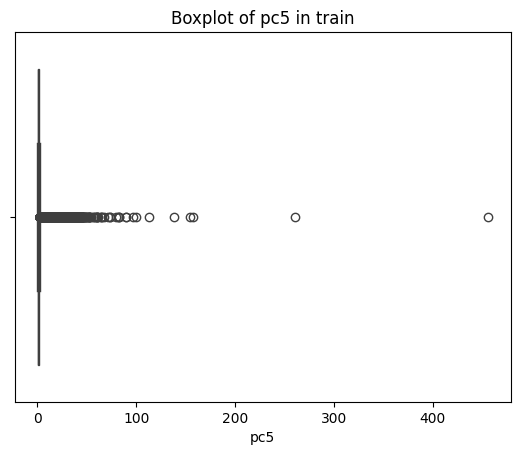

Outliers in train - pc6:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
7            29  1.0  4.0  2.445  2.115  0.865031  2.0   6.266  0.142   6.194   
10           48  1.0  8.0  2.140  1.685  0.787383  1.4   7.099  0.098   7.001   
65          323  1.0  8.0  2.955  2.610  0.883249  4.5  12.023  3.298  11.926   
78          367  0.0  2.0  5.240  4.240  0.809160  3.3  10.074  1.508   9.857   
88          405  1.0  4.0  3.275  2.855  0.871756  2.4   8.905  0.222   8.813   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
857754  3699955  0.0  4.0  1.935  1.575  0.813953  1.3   9.207  0.488   8.968   
857784  3700097  1.0  4.0  1.760  1.560  0.886364  1.5   6.406  2.119   6.362   
857882  3700474  0.0  4.0  7.170  5.860  0.817294  5.0   7.597  0.138   7.282   
857883  3700480  1.0  3.0  2.835  2.705  0.954145  3.3   5.888  0.520   5.765   
857884  3700485  1.0  5.0  1.635  1.475  0.902141  1.4   6.111  0.353   6.066   

 

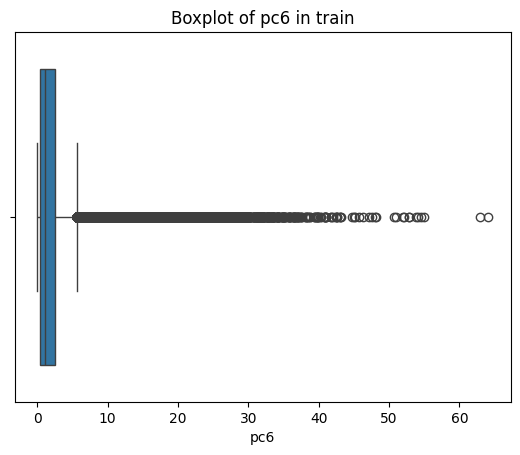

Outliers in train - pc7:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
54          267  0.0  6.0  0.540  0.540  1.000000  0.9   2.098  0.978   2.098   
65          323  1.0  8.0  2.955  2.610  0.883249  4.5  12.023  3.298  11.926   
78          367  0.0  2.0  5.240  4.240  0.809160  3.3  10.074  1.508   9.857   
103         450  0.0  4.0  2.945  2.400  0.814941  2.4   5.841  0.786   5.722   
128         547  0.0  5.0  1.415  0.980  0.692580  0.8   1.836  0.619   1.709   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
857736  3699854  1.0  3.0  1.505  1.260  0.837209  1.8   3.005  1.367   2.948   
857749  3699930  0.0  6.0  6.280  4.850  0.772293  5.0  11.607  2.875  11.200   
857784  3700097  1.0  4.0  1.760  1.560  0.886364  1.5   6.406  2.119   6.362   
857842  3700347  1.0  5.0  1.630  0.910  0.558282  1.9   2.508  0.912   2.351   
857895  3700532  1.0  3.0  1.710  1.535  0.897661  2.1   3.750  0.687   3.712   

 

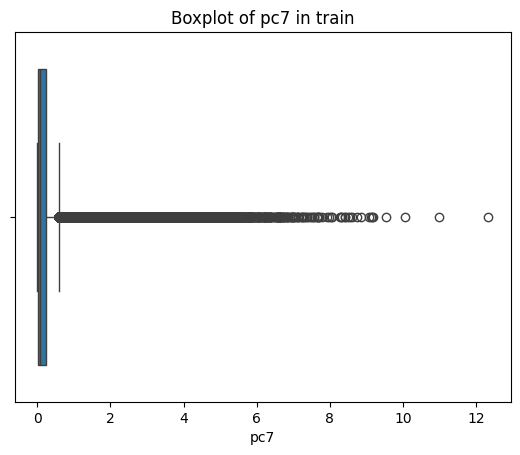

Outliers in train - pc8:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
7            29  1.0  4.0  2.445  2.115  0.865031  2.0   6.266  0.142   6.194   
10           48  1.0  8.0  2.140  1.685  0.787383  1.4   7.099  0.098   7.001   
65          323  1.0  8.0  2.955  2.610  0.883249  4.5  12.023  3.298  11.926   
78          367  0.0  2.0  5.240  4.240  0.809160  3.3  10.074  1.508   9.857   
88          405  1.0  4.0  3.275  2.855  0.871756  2.4   8.905  0.222   8.813   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
857754  3699955  0.0  4.0  1.935  1.575  0.813953  1.3   9.207  0.488   8.968   
857784  3700097  1.0  4.0  1.760  1.560  0.886364  1.5   6.406  2.119   6.362   
857882  3700474  0.0  4.0  7.170  5.860  0.817294  5.0   7.597  0.138   7.282   
857883  3700480  1.0  3.0  2.835  2.705  0.954145  3.3   5.888  0.520   5.765   
857884  3700485  1.0  5.0  1.635  1.475  0.902141  1.4   6.111  0.353   6.066   

 

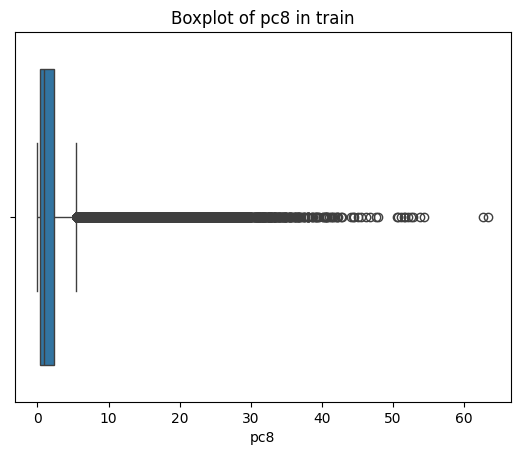

Outliers in train - pc9:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
8            32  1.0  4.0  5.735  2.520  0.439407  1.1  2.404  0.075  1.525   
21           94  0.0  3.0  0.310  0.175  0.564516  0.1  0.196  0.087  0.158   
110         472  1.0  0.0  1.585  1.175  0.741325  0.4  0.509  0.006  0.405   
130         554  0.0  1.0  0.860  0.645  0.750000  0.2  0.244  0.002  0.197   
154         659  1.0  1.0  1.580  1.060  0.670886  0.2  0.850  0.003  0.710   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857815  3700245  1.0  2.0  1.555  0.835  0.536977  0.1  0.809  0.001  0.624   
857845  3700351  1.0  2.0  1.250  0.920  0.736000  0.4  0.400  0.037  0.333   
857853  3700375  0.0  3.0  0.265  0.245  0.924528  0.2  0.265  0.015  0.170   
857857  3700387  1.0  6.0  0.930  0.305  0.327957  0.1  0.341  0.002  0.209   
857877  3700455  1.0  5.0  1.825  1.180  0.646575  0.7  0.805  0.011  0.646   

             pc9  pc10   

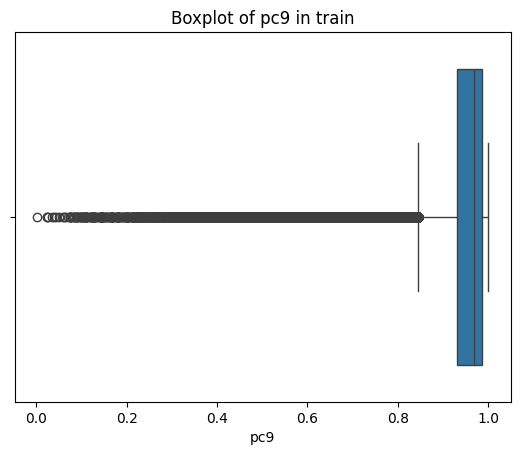

Outliers in train - pc10:
         user_id  pc0  pc1    pc2    pc3       pc4   pc5     pc6    pc7  \
63          309  1.0  6.0  5.855  5.155  0.880444   4.7   2.668  0.115   
64          314  1.0  8.0  1.415  1.315  0.929329   1.1   2.760  0.346   
65          323  1.0  8.0  2.955  2.610  0.883249   4.5  12.023  3.298   
103         450  0.0  4.0  2.945  2.400  0.814941   2.4   5.841  0.786   
142         611  1.0  2.0  1.125  0.970  0.862222   1.7   2.757  0.425   
...         ...  ...  ...    ...    ...       ...   ...     ...    ...   
857814  3700243  0.0  2.0  3.230  3.015  0.933437  10.7   1.918  0.126   
857824  3700282  1.0  3.0  2.285  2.160  0.945295   3.8   1.104  0.091   
857860  3700401  1.0  5.0  5.430  4.635  0.853591   4.3   4.460  0.523   
857882  3700474  0.0  4.0  7.170  5.860  0.817294   5.0   7.597  0.138   
857883  3700480  1.0  3.0  2.835  2.705  0.954145   3.3   5.888  0.520   

           pc8       pc9  pc10      pc11      pc12      pc13      pc14  \
63       2

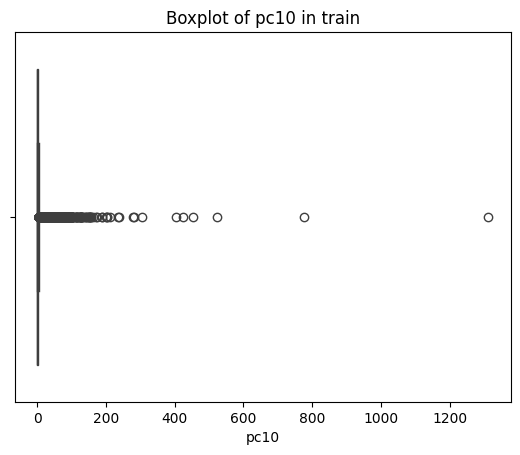

Outliers in train - pc11:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
8            32  1.0  4.0  5.735  2.520  0.439407  1.1  2.404  0.075  1.525   
171         712  0.0  3.0  1.130  0.535  0.473451  0.2  1.085  0.002  0.850   
210         890  1.0  5.0  0.430  0.195  0.453488  NaN  0.279    NaN  0.229   
308        1324  1.0  6.0  3.005  1.475  0.490849  1.5  3.664  0.066  3.149   
322        1363  1.0  5.0  1.400  0.570  0.407143  0.2  1.774  0.078  1.598   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857667  3699579  0.0  3.0  0.165  0.055  0.333333  0.1  0.035  0.001  0.013   
857674  3699615  1.0  7.0  1.175  0.240  0.204255  0.1  0.541  0.003  0.345   
857700  3699726  1.0  6.0  1.165  0.515  0.442060  0.5  1.082  0.068  0.947   
857726  3699825  1.0  5.0  1.190  0.320  0.268908  0.3  0.305  0.005  0.119   
857857  3700387  1.0  6.0  0.930  0.305  0.327957  0.1  0.341  0.002  0.209   

             pc9  pc10  

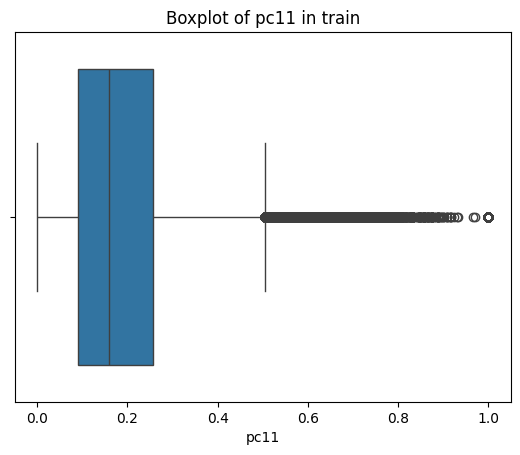

Outliers in train - pc12:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
8            32  1.0  4.0  5.735  2.520  0.439407  1.1  2.404  0.075  1.525   
21           94  0.0  3.0  0.310  0.175  0.564516  0.1  0.196  0.087  0.158   
110         472  1.0  0.0  1.585  1.175  0.741325  0.4  0.509  0.006  0.405   
130         554  0.0  1.0  0.860  0.645  0.750000  0.2  0.244  0.002  0.197   
154         659  1.0  1.0  1.580  1.060  0.670886  0.2  0.850  0.003  0.710   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857815  3700245  1.0  2.0  1.555  0.835  0.536977  0.1  0.809  0.001  0.624   
857845  3700351  1.0  2.0  1.250  0.920  0.736000  0.4  0.400  0.037  0.333   
857853  3700375  0.0  3.0  0.265  0.245  0.924528  0.2  0.265  0.015  0.170   
857857  3700387  1.0  6.0  0.930  0.305  0.327957  0.1  0.341  0.002  0.209   
857877  3700455  1.0  5.0  1.825  1.180  0.646575  0.7  0.805  0.011  0.646   

             pc9  pc10  

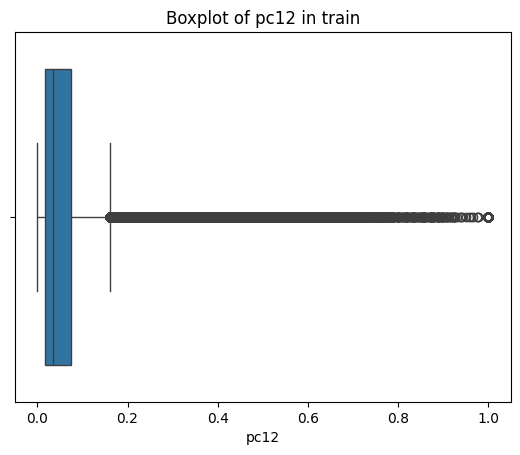

Outliers in train - pc13:
         user_id  pc0  pc1    pc2    pc3       pc4   pc5    pc6    pc7    pc8  \
12           54  0.0  8.0  0.065  0.055  0.846154   0.2  0.059  0.002  0.057   
13           68  0.0  4.0  0.120  0.120  1.000000   0.4  0.233  0.028  0.233   
32          159  1.0  6.0  0.165  0.160  0.969697   0.6  0.381  0.054  0.379   
39          181  1.0  3.0  0.030  0.030  1.000000   0.1  0.016  0.001  0.016   
40          197  0.0  2.0  0.005  0.005  1.000000   0.1  0.001  0.001  0.001   
...         ...  ...  ...    ...    ...       ...   ...    ...    ...    ...   
857774  3700041  1.0  3.0  0.355  0.290  0.816901   1.3  0.419  0.073  0.406   
857792  3700135  1.0  3.0  0.845  0.830  0.982249   2.2  0.921  0.130  0.918   
857814  3700243  0.0  2.0  3.230  3.015  0.933437  10.7  1.918  0.126  1.851   
857823  3700273  1.0  5.0  0.050  0.050  1.000000   0.4  0.035  0.025  0.035   
857863  3700408  1.0  5.0  0.180  0.170  0.944444   1.0  0.164  0.039  0.162   

            

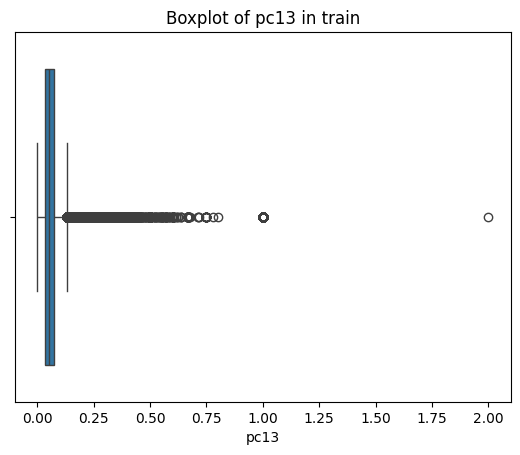

Outliers in train - pc14:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
1061       4516  1.0  2.0  0.375  0.350  0.933333  0.2  0.151  0.009  0.146   
2127       9069  1.0  4.0  0.725  0.500  0.689655  0.2  0.358  0.045  0.312   
3658      16089  0.0  7.0  3.300  2.820  0.854545  6.1  1.728  0.125  1.601   
4541      19848  0.0  3.0  3.770  1.875  0.497347  0.9  1.671  0.014  1.086   
5103      22223  1.0  5.0  0.375  0.235  0.626667  0.1  0.670  0.005  0.642   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
855257  3688959  1.0  1.0  1.015  0.910  0.896552  0.5  0.937  0.143  0.909   
855448  3689830  1.0  3.0  0.135  0.135  1.000000  0.2  0.084  0.030  0.084   
855881  3691636  1.0  3.0  0.180  0.155  0.861111  0.2  0.339  0.013  0.334   
857410  3698432  1.0  5.0  0.120  0.100  0.833333  0.2  0.228  0.021  0.224   
857822  3700272  1.0  1.0  1.000  0.565  0.565000  0.2  0.696  0.074  0.605   

             pc9  pc10  

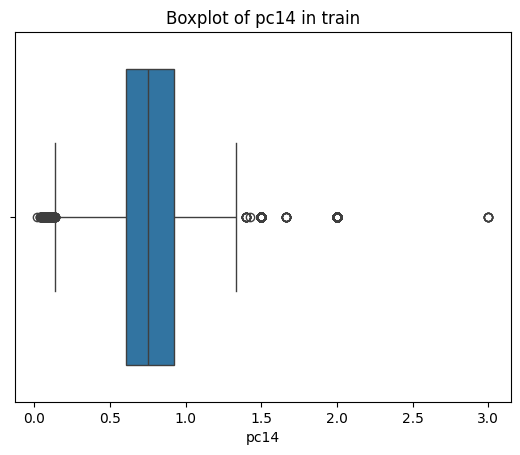

Outliers in train - pc15:
         user_id  pc0  pc1    pc2    pc3       pc4   pc5    pc6    pc7    pc8  \
12           54  0.0  8.0  0.065  0.055  0.846154   0.2  0.059  0.002  0.057   
13           68  0.0  4.0  0.120  0.120  1.000000   0.4  0.233  0.028  0.233   
74          352  1.0  5.0  0.210  0.185  0.880952   0.6  0.164  0.046  0.159   
106         461  1.0  3.0  0.145  0.135  0.931034   0.2  0.141  0.005  0.139   
127         539  1.0  4.0  0.125  0.115  0.920000   0.4  0.094  0.022  0.092   
...         ...  ...  ...    ...    ...       ...   ...    ...    ...    ...   
857643  3699458  1.0  3.0  0.230  0.155  0.673913   0.3  0.316  0.098  0.294   
857737  3699856  1.0  0.0  0.315  0.165  0.523810   0.6  0.924  0.168  0.892   
857738  3699858  0.0  4.0  0.545  0.470  0.862385   0.9  0.267  0.039  0.251   
857814  3700243  0.0  2.0  3.230  3.015  0.933437  10.7  1.918  0.126  1.851   
857863  3700408  1.0  5.0  0.180  0.170  0.944444   1.0  0.164  0.039  0.162   

            

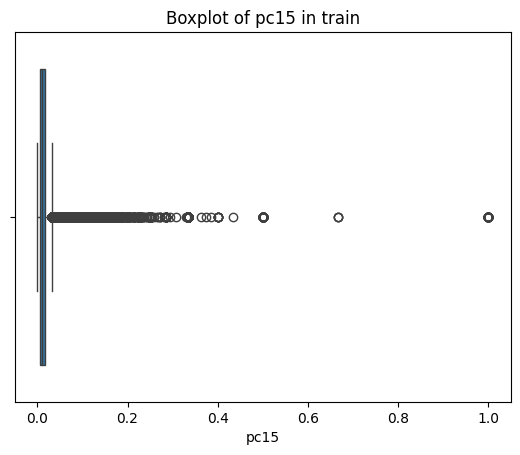

Outliers in train - pc16:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
227         981  1.0  3.0  0.120  0.110  0.916667  0.3  0.118  0.028  0.116   
233        1009  1.0  5.0  0.305  0.185  0.606557  0.1  0.247  0.012  0.199   
247        1065  1.0  5.0  0.415  0.380  0.915663  0.4  1.028  0.054  1.021   
367        1541  1.0  4.0  0.285  0.170  0.596491  0.3  0.110  0.005  0.064   
511        2115  1.0  3.0  1.105  0.925  0.837104  0.7  0.411  0.024  0.359   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857673  3699610  0.0  2.0  0.595  0.515  0.865546  0.3  0.599  0.066  0.577   
857674  3699615  1.0  7.0  1.175  0.240  0.204255  0.1  0.541  0.003  0.345   
857812  3700240  1.0  4.0  0.625  0.395  0.632000  0.3  0.991  0.148  0.944   
857857  3700387  1.0  6.0  0.930  0.305  0.327957  0.1  0.341  0.002  0.209   
857869  3700421  0.0  5.0  0.350  0.305  0.871429  0.3  0.279  0.088  0.265   

             pc9  pc10  

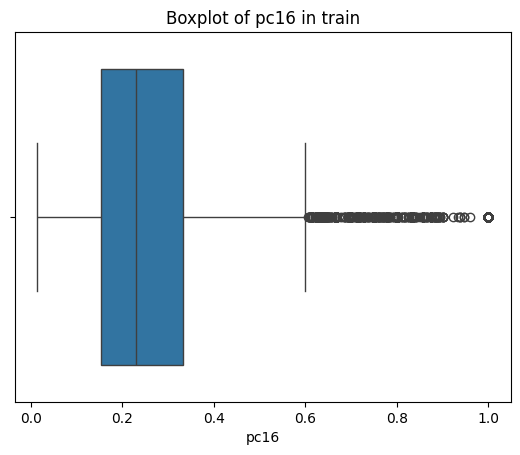

Outliers in train - label:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
252        1080  1.0  2.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
305        1307  1.0  1.0  0.295  0.285  0.966102  0.5  0.346  0.057  0.344   
481        2001  0.0  1.0  0.490  0.455  0.928571  0.4  1.046  0.126  1.036   
482        2002  1.0  1.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
515        2129  1.0  5.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857668  3699581  1.0  2.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
857678  3699636  1.0  5.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
857691  3699702  1.0  6.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   
857775  3700044  1.0  6.0  0.590  0.575  0.974576  0.5  1.668  0.087  1.665   
857789  3700118  1.0  8.0    NaN    NaN       NaN  NaN    NaN    NaN    NaN   

             pc9  pc10 

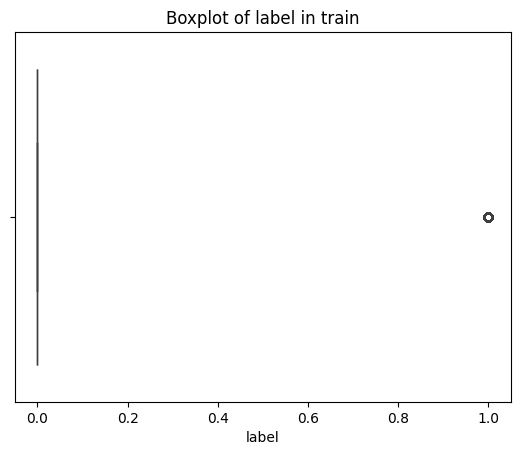

Outliers in test - pc2:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
11          135  1.0  4.0  6.165  4.495  0.729116  4.3   8.167  0.449   7.718   
28          359  1.0  5.0  4.560  3.775  0.827851  2.2   6.738  0.806   6.529   
29          360  1.0  3.0  3.850  3.080  0.800000  3.0   1.821  0.130   1.660   
37          392  1.0  2.0  7.875  7.855  0.997460  4.7   3.024  0.105   3.020   
57          609  1.0  3.0  7.110  6.875  0.966948  0.8   3.090  0.022   3.026   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
367587  3699493  1.0  4.0  4.970  4.805  0.966801  5.1   1.500  0.068   1.423   
367602  3699580  1.0  6.0  3.705  2.955  0.797571  2.2  13.732  2.816  13.566   
367627  3699779  1.0  8.0  3.755  3.385  0.901465  4.0   9.784  0.198   9.681   
367637  3699875  1.0  6.0  4.450  3.710  0.833708  2.7   8.482  0.451   8.260   
367661  3700103  1.0  3.0  7.395  7.125  0.963489  3.0   3.714  0.100   3.639   

  

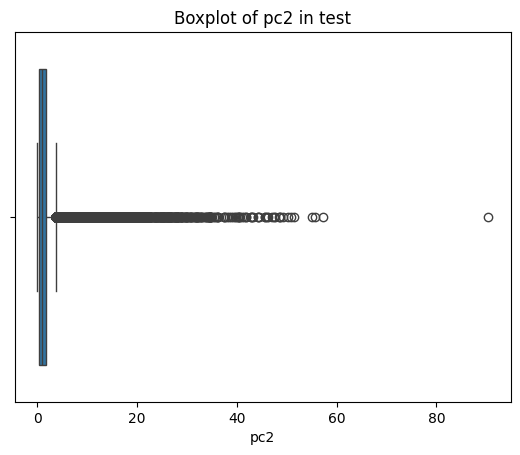

Outliers in test - pc3:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5     pc6    pc7     pc8  \
11          135  1.0  4.0  6.165  4.495  0.729116  4.3   8.167  0.449   7.718   
28          359  1.0  5.0  4.560  3.775  0.827851  2.2   6.738  0.806   6.529   
29          360  1.0  3.0  3.850  3.080  0.800000  3.0   1.821  0.130   1.660   
37          392  1.0  2.0  7.875  7.855  0.997460  4.7   3.024  0.105   3.020   
57          609  1.0  3.0  7.110  6.875  0.966948  0.8   3.090  0.022   3.026   
...         ...  ...  ...    ...    ...       ...  ...     ...    ...     ...   
367587  3699493  1.0  4.0  4.970  4.805  0.966801  5.1   1.500  0.068   1.423   
367602  3699580  1.0  6.0  3.705  2.955  0.797571  2.2  13.732  2.816  13.566   
367627  3699779  1.0  8.0  3.755  3.385  0.901465  4.0   9.784  0.198   9.681   
367637  3699875  1.0  6.0  4.450  3.710  0.833708  2.7   8.482  0.451   8.260   
367661  3700103  1.0  3.0  7.395  7.125  0.963489  3.0   3.714  0.100   3.639   

  

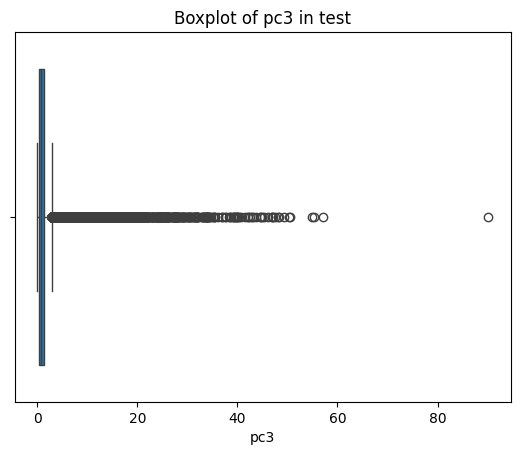

Outliers in test - pc4:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
4            66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015   
224        2339  1.0  2.0  0.080  0.035  0.437500  NaN  0.040    NaN  0.027   
229        2353  0.0  6.0  0.885  0.425  0.480226  0.3  0.306  0.012  0.190   
320        3241  1.0  5.0  2.955  1.225  0.414552  0.2  1.301  0.009  0.881   
341        3435  0.0  3.0  1.260  0.565  0.448413  0.7  0.493  0.140  0.324   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367178  3695134  1.0  2.0  0.830  0.375  0.451807  0.2  0.774  0.037  0.659   
367188  3695233  1.0  4.0  0.755  0.360  0.476821  0.4  0.474  0.007  0.390   
367248  3695907  1.0  0.0  0.265  0.130  0.490566  0.2  0.096  0.002  0.068   
367518  3698796  0.0  6.0  1.795  0.695  0.387187  0.7  0.825  0.136  0.579   
367556  3699218  1.0  4.0  1.040  0.500  0.480769  0.6  1.202  0.058  1.070   

             pc9  pc10    

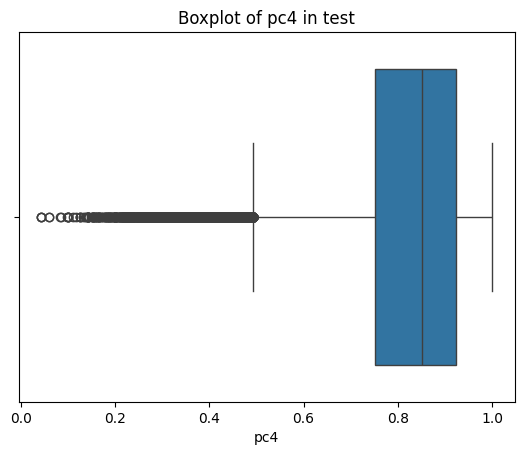

Outliers in test - pc5:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
10          129  1.0  2.0  1.780  1.420  0.797753  3.3  6.086  0.613  5.951   
11          135  1.0  4.0  6.165  4.495  0.729116  4.3  8.167  0.449  7.718   
29          360  1.0  3.0  3.850  3.080  0.800000  3.0  1.821  0.130  1.660   
37          392  1.0  2.0  7.875  7.855  0.997460  4.7  3.024  0.105  3.020   
64          685  1.0  7.0  5.375  4.760  0.885581  5.5  7.522  0.205  7.057   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367587  3699493  1.0  4.0  4.970  4.805  0.966801  5.1  1.500  0.068  1.423   
367603  3699583  1.0  4.0  2.890  2.465  0.852941  4.2  4.364  0.904  4.266   
367627  3699779  1.0  8.0  3.755  3.385  0.901465  4.0  9.784  0.198  9.681   
367629  3699790  1.0  5.0  2.315  1.915  0.827214  3.4  7.373  1.198  7.266   
367661  3700103  1.0  3.0  7.395  7.125  0.963489  3.0  3.714  0.100  3.639   

             pc9  pc10    

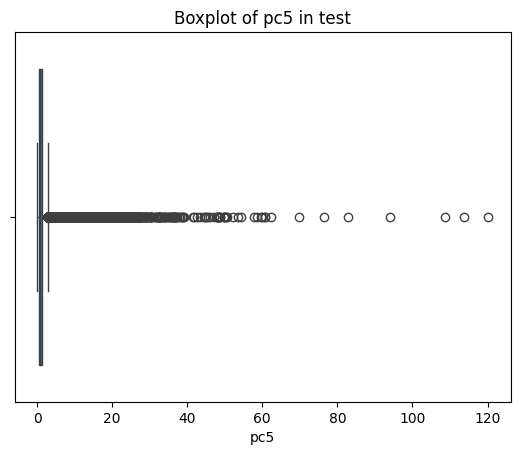

Outliers in test - pc6:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
10          129  1.0  2.0  1.780  1.420  0.797753  3.3  6.086  0.613  5.951   
11          135  1.0  4.0  6.165  4.495  0.729116  4.3  8.167  0.449  7.718   
28          359  1.0  5.0  4.560  3.775  0.827851  2.2  6.738  0.806  6.529   
46          493  1.0  7.0  1.805  1.370  0.759003  0.4  6.694  0.037  6.581   
64          685  1.0  7.0  5.375  4.760  0.885581  5.5  7.522  0.205  7.057   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367627  3699779  1.0  8.0  3.755  3.385  0.901465  4.0  9.784  0.198  9.681   
367629  3699790  1.0  5.0  2.315  1.915  0.827214  3.4  7.373  1.198  7.266   
367632  3699808  1.0  3.0  1.675  1.535  0.916418  2.2  6.068  0.660  6.040   
367637  3699875  1.0  6.0  4.450  3.710  0.833708  2.7  8.482  0.451  8.260   
367700  3700539  1.0  4.0  2.440  2.295  0.940574  1.8  5.874  0.248  5.640   

             pc9  pc10    

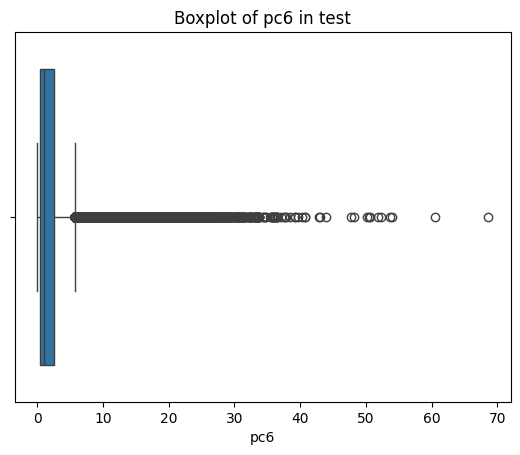

Outliers in test - pc7:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
10          129  1.0  2.0  1.780  1.420  0.797753  3.3  6.086  0.613  5.951   
28          359  1.0  5.0  4.560  3.775  0.827851  2.2  6.738  0.806  6.529   
30          363  0.0  8.0  1.075  0.995  0.925581  1.0  2.632  0.600  2.601   
33          372  0.0  7.0  2.170  2.010  0.926267  1.4  5.518  0.750  5.444   
59          633  1.0  2.0  1.590  1.145  0.720126  1.7  4.829  1.618  4.730   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367629  3699790  1.0  5.0  2.315  1.915  0.827214  3.4  7.373  1.198  7.266   
367632  3699808  1.0  3.0  1.675  1.535  0.916418  2.2  6.068  0.660  6.040   
367643  3699933  1.0  1.0  1.350  1.065  0.788889  2.5  3.472  0.984  3.415   
367674  3700249  0.0  5.0  1.215  1.140  0.938272  2.1  2.601  0.895  2.577   
367701  3700544  1.0  5.0  1.520  1.355  0.891447  1.9  4.617  1.074  4.580   

             pc9  pc10    

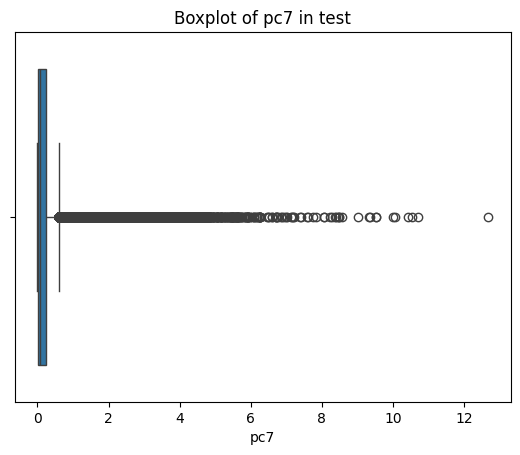

Outliers in test - pc8:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
10          129  1.0  2.0  1.780  1.420  0.797753  3.3  6.086  0.613  5.951   
11          135  1.0  4.0  6.165  4.495  0.729116  4.3  8.167  0.449  7.718   
28          359  1.0  5.0  4.560  3.775  0.827851  2.2  6.738  0.806  6.529   
46          493  1.0  7.0  1.805  1.370  0.759003  0.4  6.694  0.037  6.581   
64          685  1.0  7.0  5.375  4.760  0.885581  5.5  7.522  0.205  7.057   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367627  3699779  1.0  8.0  3.755  3.385  0.901465  4.0  9.784  0.198  9.681   
367629  3699790  1.0  5.0  2.315  1.915  0.827214  3.4  7.373  1.198  7.266   
367632  3699808  1.0  3.0  1.675  1.535  0.916418  2.2  6.068  0.660  6.040   
367637  3699875  1.0  6.0  4.450  3.710  0.833708  2.7  8.482  0.451  8.260   
367700  3700539  1.0  4.0  2.440  2.295  0.940574  1.8  5.874  0.248  5.640   

             pc9  pc10    

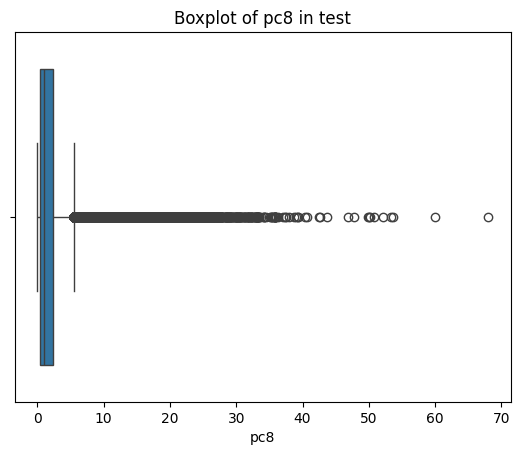

Outliers in test - pc9:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
3            61  0.0  3.0  1.505  0.875  0.581395  0.9  0.425  0.012  0.286   
4            66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015   
16          217  0.0  2.0  0.390  0.290  0.743590  0.3  0.120  0.015  0.096   
18          265  0.0  4.0  1.270  0.780  0.614173  0.7  0.489  0.026  0.357   
20          292  1.0  0.0  0.040  0.020  0.500000  0.1  0.009  0.001  0.005   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367593  3699534  1.0  3.0  0.395  0.225  0.569620  0.6  0.383  0.077  0.321   
367645  3699958  1.0  3.0  0.375  0.300  0.800000  0.1  0.181  0.001  0.151   
367647  3700001  1.0  3.0  0.215  0.130  0.604651  0.8  0.089  0.027  0.072   
367682  3700317  1.0  2.0  0.025  0.015  0.600000  0.1  0.009  0.001  0.007   
367684  3700322  0.0  2.0  0.350  0.220  0.628571  0.3  0.159  0.007  0.131   

             pc9  pc10    

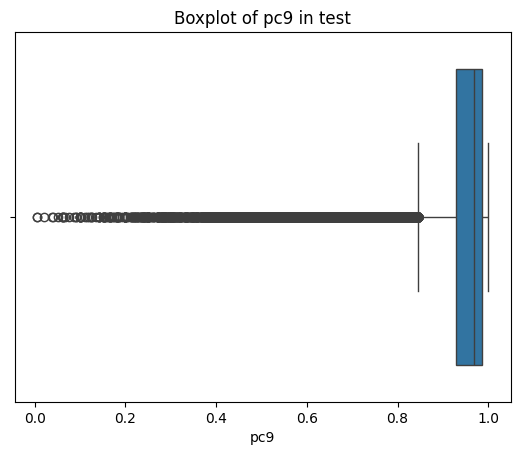

Outliers in test - pc10:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
10          129  1.0  2.0  1.780  1.420  0.797753  3.3  6.086  0.613  5.951   
11          135  1.0  4.0  6.165  4.495  0.729116  4.3  8.167  0.449  7.718   
15          208  1.0  5.0  0.425  0.340  0.800000  0.9  0.374  0.028  0.348   
29          360  1.0  3.0  3.850  3.080  0.800000  3.0  1.821  0.130  1.660   
37          392  1.0  2.0  7.875  7.855  0.997460  4.7  3.024  0.105  3.020   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367661  3700103  1.0  3.0  7.395  7.125  0.963489  3.0  3.714  0.100  3.639   
367674  3700249  0.0  5.0  1.215  1.140  0.938272  2.1  2.601  0.895  2.577   
367679  3700283  1.0  2.0  0.730  0.695  0.952055  1.4  0.783  0.093  0.776   
367691  3700411  1.0  6.0  3.075  2.200  0.715447  2.8  2.753  0.106  2.516   
367700  3700539  1.0  4.0  2.440  2.295  0.940574  1.8  5.874  0.248  5.640   

             pc9  pc10   

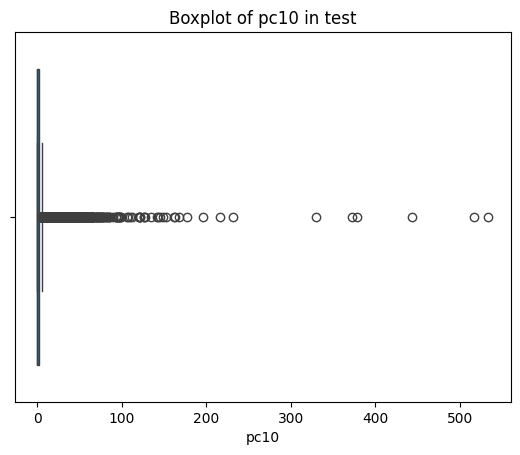

Outliers in test - pc11:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
4            66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015   
224        2339  1.0  2.0  0.080  0.035  0.437500  NaN  0.040    NaN  0.027   
229        2353  0.0  6.0  0.885  0.425  0.480226  0.3  0.306  0.012  0.190   
320        3241  1.0  5.0  2.955  1.225  0.414552  0.2  1.301  0.009  0.881   
341        3435  0.0  3.0  1.260  0.565  0.448413  0.7  0.493  0.140  0.324   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367178  3695134  1.0  2.0  0.830  0.375  0.451807  0.2  0.774  0.037  0.659   
367188  3695233  1.0  4.0  0.755  0.360  0.476821  0.4  0.474  0.007  0.390   
367248  3695907  1.0  0.0  0.265  0.130  0.490566  0.2  0.096  0.002  0.068   
367518  3698796  0.0  6.0  1.795  0.695  0.387187  0.7  0.825  0.136  0.579   
367556  3699218  1.0  4.0  1.040  0.500  0.480769  0.6  1.202  0.058  1.070   

             pc9  pc10   

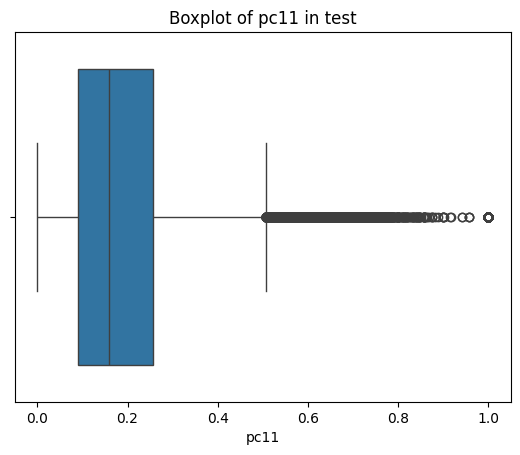

Outliers in test - pc12:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
3            61  0.0  3.0  1.505  0.875  0.581395  0.9  0.425  0.012  0.286   
4            66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015   
16          217  0.0  2.0  0.390  0.290  0.743590  0.3  0.120  0.015  0.096   
18          265  0.0  4.0  1.270  0.780  0.614173  0.7  0.489  0.026  0.357   
20          292  1.0  0.0  0.040  0.020  0.500000  0.1  0.009  0.001  0.005   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367593  3699534  1.0  3.0  0.395  0.225  0.569620  0.6  0.383  0.077  0.321   
367645  3699958  1.0  3.0  0.375  0.300  0.800000  0.1  0.181  0.001  0.151   
367647  3700001  1.0  3.0  0.215  0.130  0.604651  0.8  0.089  0.027  0.072   
367682  3700317  1.0  2.0  0.025  0.015  0.600000  0.1  0.009  0.001  0.007   
367684  3700322  0.0  2.0  0.350  0.220  0.628571  0.3  0.159  0.007  0.131   

             pc9  pc10   

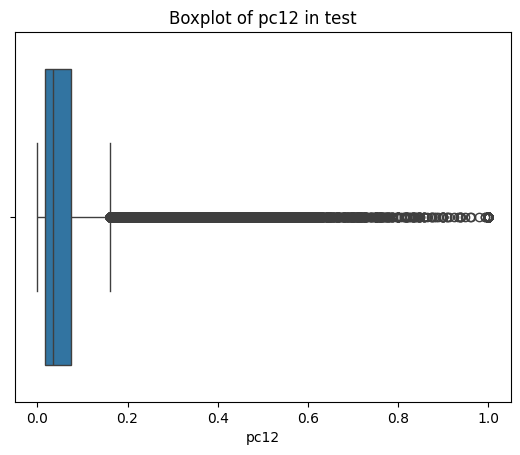

Outliers in test - pc13:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9           118  1.0  0.0  0.040  0.030  0.750000  0.1  0.013  0.003  0.011   
13          200  0.0  4.0  0.010  0.010  1.000000  0.1  0.002  0.001  0.002   
15          208  1.0  5.0  0.425  0.340  0.800000  0.9  0.374  0.028  0.348   
20          292  1.0  0.0  0.040  0.020  0.500000  0.1  0.009  0.001  0.005   
45          463  1.0  5.0  0.560  0.540  0.964286  1.5  0.715  0.099  0.704   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367540  3699045  1.0  3.0  0.485  0.295  0.608247  0.9  0.257  0.042  0.215   
367593  3699534  1.0  3.0  0.395  0.225  0.569620  0.6  0.383  0.077  0.321   
367594  3699535  1.0  0.0  0.195  0.185  0.948718  0.5  0.145  0.009  0.140   
367647  3700001  1.0  3.0  0.215  0.130  0.604651  0.8  0.089  0.027  0.072   
367682  3700317  1.0  2.0  0.025  0.015  0.600000  0.1  0.009  0.001  0.007   

             pc9  pc10   

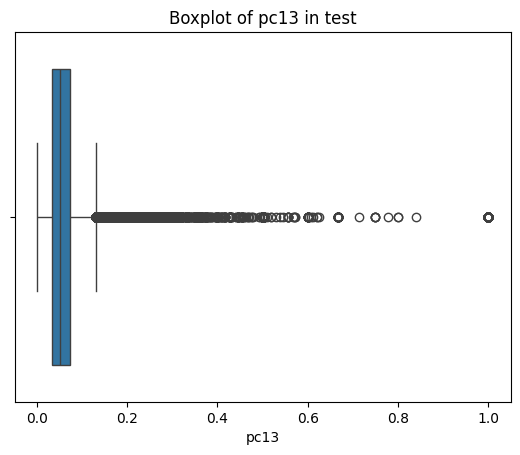

Outliers in test - pc14:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
1189      12271  0.0  8.0  1.625  1.420  0.873846  0.7  1.230  0.029  1.186   
1293      13248  0.0  3.0  0.080  0.080  1.000000  0.1  0.194  0.085  0.194   
1618      16217  0.0  5.0  0.430  0.350  0.813953  0.1  0.323  0.093  0.307   
3005      29814  0.0  5.0  2.215  1.770  0.799097  0.8  2.595  0.026  2.495   
3191      31570  0.0  5.0  1.220  0.855  0.700820  0.7  0.646  0.011  0.547   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
364947  3672643  1.0  3.0  0.205  0.150  0.731707  0.2  0.149  0.061  0.138   
365497  3678442  1.0  3.0  0.875  0.745  0.851429  0.7  1.073  0.011  1.044   
365917  3682710  1.0  4.0  0.255  0.195  0.764706  0.2  1.104  0.005  1.092   
366355  3686923  1.0  7.0  0.540  0.500  0.925926  0.7  0.540  0.012  0.525   
366819  3691714  0.0  6.0  1.940  1.345  0.693299  0.8  1.518  0.014  1.353   

             pc9  pc10   

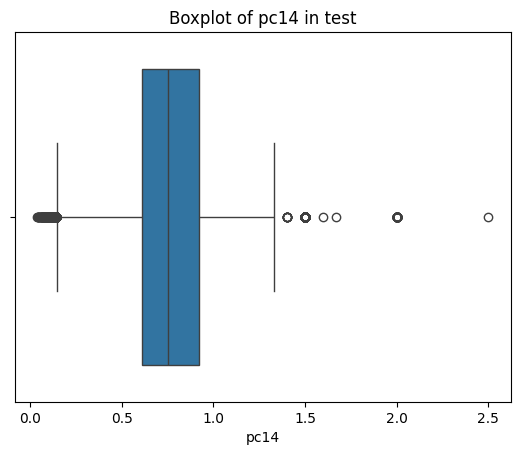

Outliers in test - pc15:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9           118  1.0  0.0  0.040  0.030  0.750000  0.1  0.013  0.003  0.011   
15          208  1.0  5.0  0.425  0.340  0.800000  0.9  0.374  0.028  0.348   
27          335  1.0  6.0  0.340  0.280  0.823529  0.7  0.391  0.059  0.369   
75          783  0.0  5.0  0.235  0.205  0.872340  0.8  1.167  0.177  1.160   
79          826  1.0  5.0  1.190  0.925  0.777311  2.7  3.830  1.073  3.760   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367610  3699638  1.0  1.0  0.250  0.220  0.880000  0.4  1.156  0.444  1.149   
367647  3700001  1.0  3.0  0.215  0.130  0.604651  0.8  0.089  0.027  0.072   
367665  3700130  1.0  5.0  0.135  0.100  0.740741  0.1  0.140  0.002  0.133   
367679  3700283  1.0  2.0  0.730  0.695  0.952055  1.4  0.783  0.093  0.776   
367682  3700317  1.0  2.0  0.025  0.015  0.600000  0.1  0.009  0.001  0.007   

             pc9  pc10   

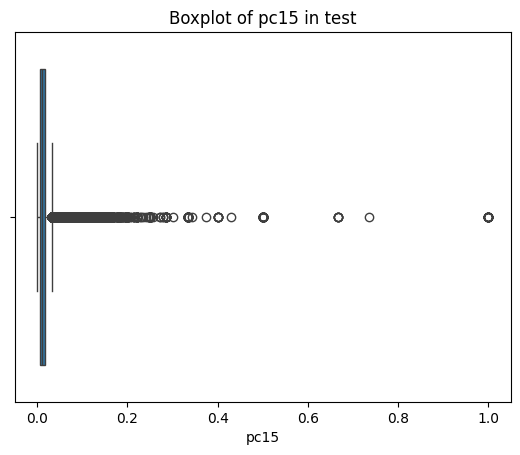

Outliers in test - pc16:
         user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
9           118  1.0  0.0  0.040  0.030  0.750000  0.1  0.013  0.003  0.011   
15          208  1.0  5.0  0.425  0.340  0.800000  0.9  0.374  0.028  0.348   
153        1513  1.0  3.0  0.135  0.095  0.703704  0.1  0.065  0.002  0.057   
167        1659  1.0  6.0  0.620  0.375  0.604839  0.4  0.271  0.026  0.215   
169        1694  0.0  8.0  0.030  0.025  0.833333  0.1  0.102  0.001  0.030   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367647  3700001  1.0  3.0  0.215  0.130  0.604651  0.8  0.089  0.027  0.072   
367665  3700130  1.0  5.0  0.135  0.100  0.740741  0.1  0.140  0.002  0.133   
367668  3700173  1.0  3.0  0.835  0.835  1.000000  0.4  1.391  0.230  1.391   
367676  3700275  1.0  5.0  2.340  2.030  0.867521  0.3  2.071  0.378  2.003   
367682  3700317  1.0  2.0  0.025  0.015  0.600000  0.1  0.009  0.001  0.007   

             pc9  pc10   

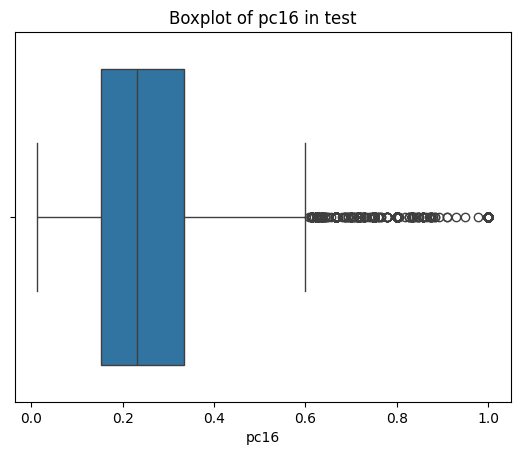

In [ ]:
import matplotlib.pyplot as plt
# Function to detect outliers using IQR method, ignoring NaN values
def detect_outliers_iqr_ignore_nan(data, column):
    # Drop NaN values before calculating quantiles
    data_non_nan = data[column].dropna()

    Q1 = data_non_nan.quantile(0.25)
    Q3 = data_non_nan.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers considering NaN values
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Detect and visualize outliers for numerical columns in each dataset, ignoring NaN values
for df, name in [(loan_activities, "loan_activities"), (non_borrower_user, "non_borrower_user"), (train, "train"), (test, "test")]:
    for column in df.select_dtypes(include=['number']):
        outliers = detect_outliers_iqr_ignore_nan(df, column)
        if not outliers.empty:
            print(f"Outliers in {name} - {column}:\n", outliers)

            # Visualize outliers using boxplot
            plt.figure()
            sns.boxplot(x=df[column])
            plt.title(f"Boxplot of {column} in {name}")
            plt.show()


# 6. Feature Selecting

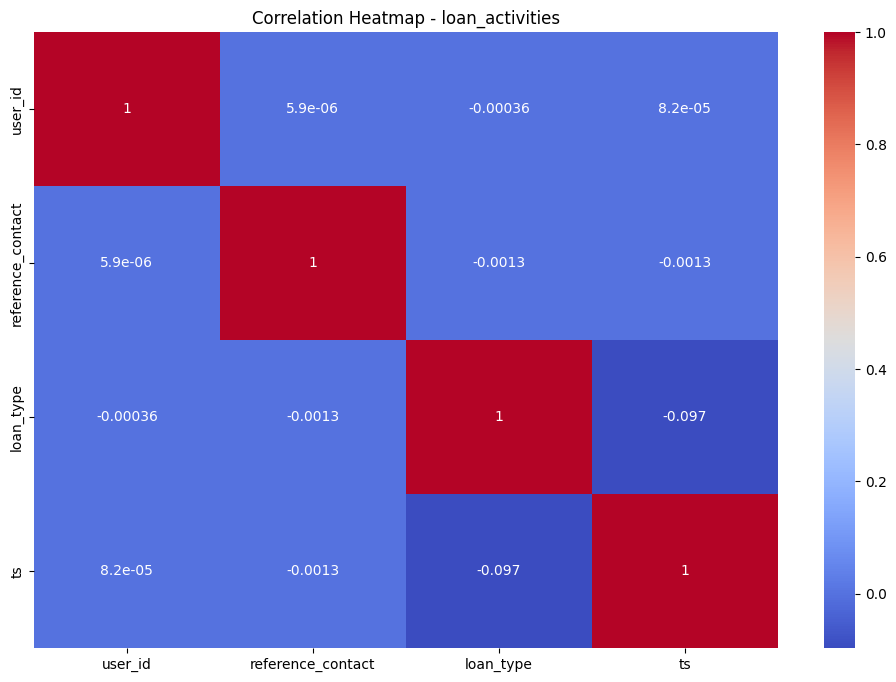

In [ ]:
# prompt: Heatmap setiap dataset untuk melihat corelasinya

import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap for loan_activities
plt.figure(figsize=(12, 8))
sns.heatmap(loan_activities.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap - loan_activities")
plt.show()

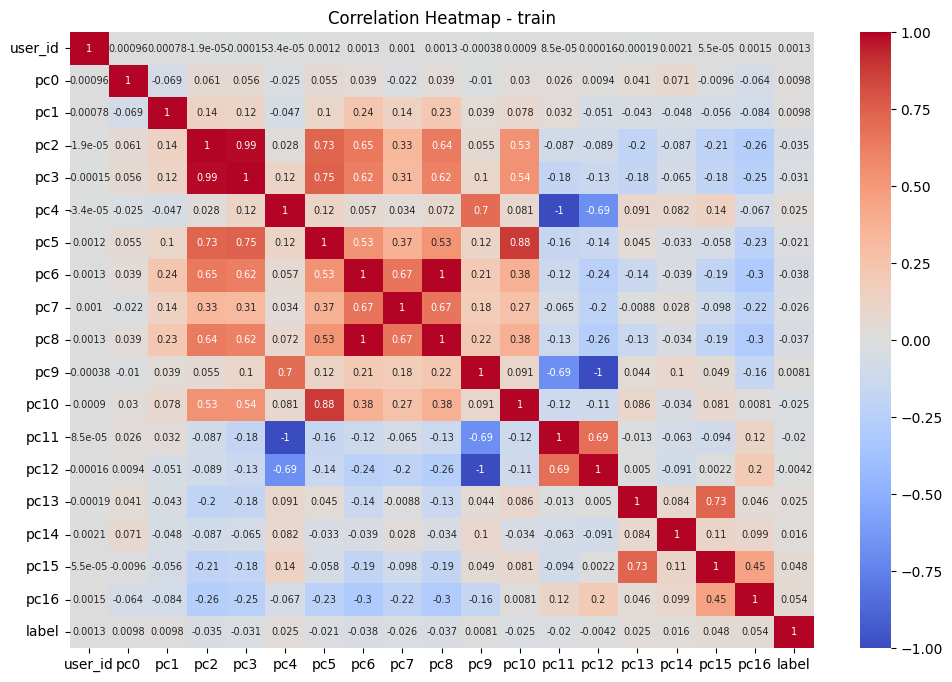

In [ ]:
# prompt: corelasi data train

import matplotlib.pyplot as plt
# Heatmap for train
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 7})
plt.title("Correlation Heatmap - train")
plt.show()


In [ ]:
train.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label
0,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.750000,0.018182,0.250000,0
1,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,0.985634,1.0,0.151163,0.014366,0.054795,0.500000,0.011628,0.250000,0
2,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,0.951782,1.0,0.372624,0.048218,0.054545,0.777778,0.003802,0.111111,0
3,10,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,17,1.0,1.0,0.235,0.160,0.680851,0.1,0.120,0.002,0.104,0.866667,0.0,0.319149,0.133333,0.031250,NaN,NaN,NaN,0


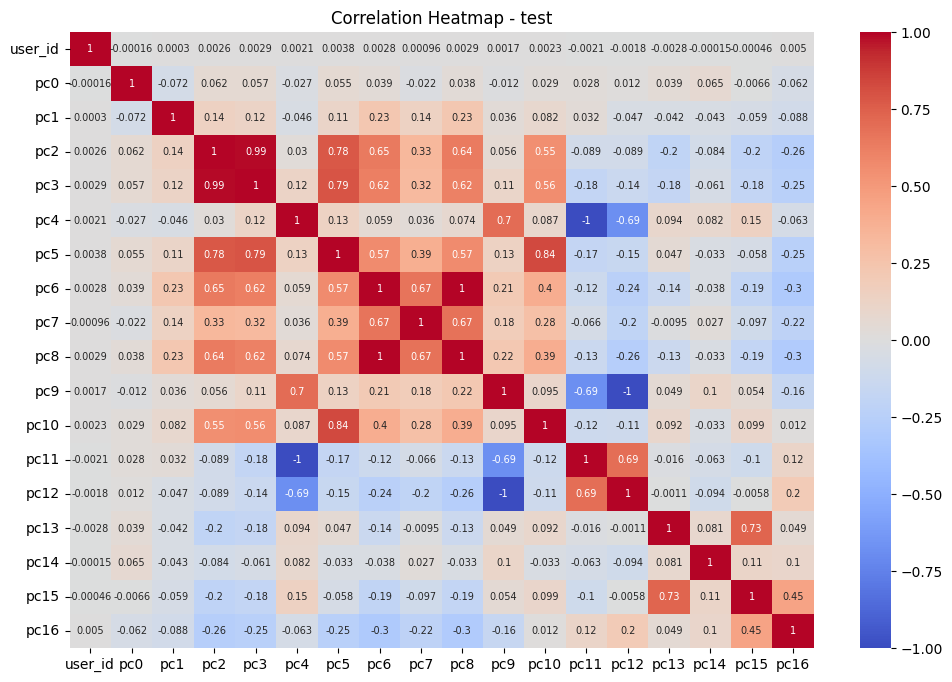

In [ ]:
# Heatmap for test
plt.figure(figsize=(12, 8))
sns.heatmap(test.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 7})
plt.title("Correlation Heatmap - test")
plt.show()


In [ ]:
test.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,4,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,13,1.0,5.0,0.445,0.420,0.943820,0.8,0.783,0.234,0.778,0.993614,2.0,0.056180,0.006386,0.095238,0.750000,0.022472,0.250000
2,37,1.0,6.0,1.680,1.080,0.642857,0.6,1.167,0.046,1.007,0.862896,1.0,0.357143,0.137104,0.027778,0.500000,0.002976,0.166667
3,61,0.0,3.0,1.505,0.875,0.581395,0.9,0.425,0.012,0.286,0.672941,1.0,0.418605,0.327059,0.051429,0.333333,0.003322,0.111111
4,66,1.0,5.0,2.210,1.075,0.486425,1.0,1.349,0.087,1.015,0.752409,2.0,0.513575,0.247591,0.046512,0.800000,0.004525,0.200000


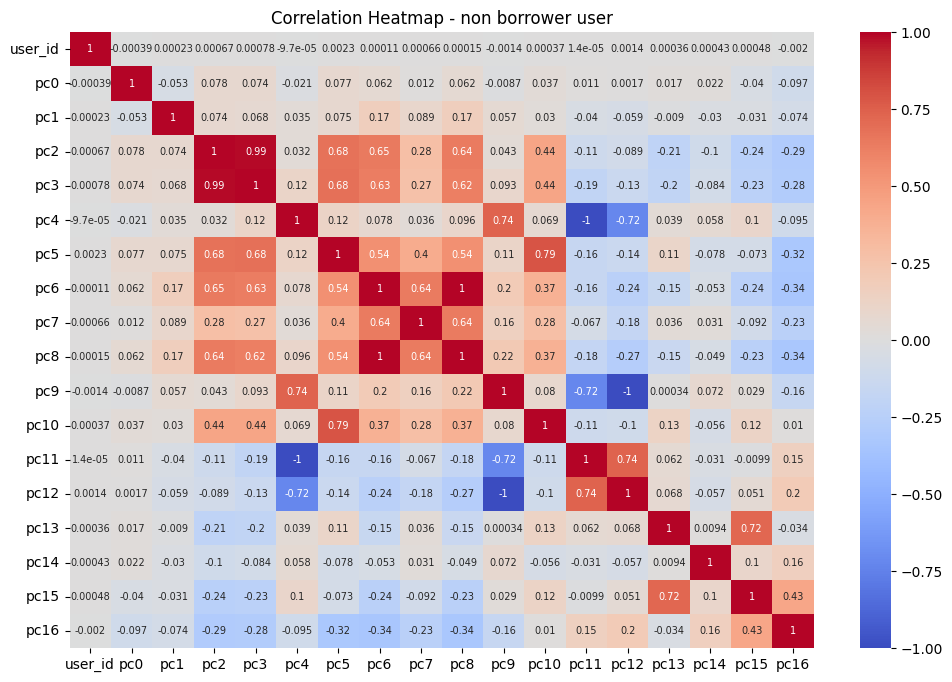

In [ ]:

# Heatmap for non_borrower_user
plt.figure(figsize=(12, 8))
sns.heatmap(non_borrower_user.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 7})
plt.title("Correlation Heatmap - non borrower user")
plt.show()


In [ ]:
non_borrower_user.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,8.0,0.63,0.565,0.896825,0.6,2.298,0.21,2.284,0.993908,1,0.103175,0.006092,0.053097,1.0,0.007937,0.166667
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
3,6,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4,7,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


when viewed from all correlation graphs, there are several features that have very high or influential correlation values. therefore, before doing feature engineering we will first eliminate these columns.

# Feature Engineering


Feature engineering is an important process in machine learning that involves creating new features or modifying existing features to improve model performance. In this case, we are working with user data and loan activity to detect potential fraud. The steps taken include merging data from multiple sources, mapping user identities to an index, and creating additional features based on relationship graphs between users. This process helped prepare the data for use in the LightGBM model. By extracting features using this graph, it can maximize the prediction results of the LightGBM model.

In this section, we concatenate several DataFrames while removing some columns  that are not needed for the feature nodes. The result is a feature matrix that is concatenated and converted into a numpy array.

In [ ]:
# Create node feature matrix
node_features = pd.concat([
    train.drop(columns=['user_id', 'label','pc2', 'pc4', 'pc5', 'pc6', 'pc9']),
    non_borrower_user.drop(columns=['user_id','pc2', 'pc4', 'pc5', 'pc6', 'pc9']),
    test.drop(columns=['user_id','pc2', 'pc4', 'pc5', 'pc6', 'pc9'])
], ignore_index=True).to_numpy()

Here, we will combine all the user_ids from the three DataFrames and store their unique values. Then, we create a map (dictionary) that maps each user_id to an index.

In [ ]:
# Mapping user_id to index
user_ids = pd.concat([train['user_id'], non_borrower_user['user_id'], test['user_id']]).unique()
user_id_map = {user_id: idx for idx, user_id in enumerate(user_ids)}


In this section, we will take the user_id and reference_contact columns from loan_activities and map them to the index we previously created.

In [ ]:
#Create edge_index from loan_activities
edge_index = loan_activities[['user_id', 'reference_contact']].applymap(user_id_map.get).dropna().astype(int).to_numpy().T


Here, we will create a Data object from PyTorch Geometric by inputting the node feature matrix as a tensor and edge_index as a tensor.

In [ ]:
# Create object Data from PyTorch Geometric
data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))


In this section, we will create a directed graph using NetworkX from loan_activities with user_id and reference_contact as pairs of connected nodes.

In [ ]:
# Create a directed graph for centrality calculations
G = nx.from_pandas_edgelist(loan_activities, 'user_id', 'reference_contact', create_using=nx.DiGraph())

In this section, we will calculate the in-degree and out-degree of the graph we created, which indicates the number of connections going to and coming from each node. Then, we add these degree features into the node feature tensor by concatenating them (torch.cat) in the second dimension (dim=1). The goal is to enrich the representation of each node in the graph-based model, helping the model understand the connectedness and importance of each node in the network, thus improving the accuracy in detecting complex patterns and anomalies, such as fraud.

In [ ]:
# Calculate degree features
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

data.x = torch.cat([data.x, torch.tensor([[in_degree[user], out_degree[user]] for user in user_ids], dtype=torch.float)], dim=1)

Here, we will calculate betweenness centrality by approximation using sampling. The parameter k=100 specifies the number of nodes to be sampled to speed up the calculation process, while seed=42 is used to ensure reproducible results. Betweenness centrality provides information on how often a node is a bridge in the shortest path between two other nodes. and we will also calculate closeness centrality for each node in the graph. Closeness centrality measures the average distance from a node to all other nodes, which indicates how quickly the node can reach other nodes in the network. It gives an idea about the accessibility of nodes.

In [ ]:
# Approximate betweenness centrality using sampling
approx_betweenness = betweenness_centrality(G, k=100, seed=42)  # k is the number of nodes to sample
closeness = closeness_centrality(G)

In this section, we will convert the betweenness and closeness centrality values into PyTorch tensors. For each user_id, we take the value from the generated dictionary. If a user_id does not exist, we use the default value of 0. Then, we use unsqueeze(1) to add a new dimension, so that this tensor can be combined with other node features.

In [ ]:
# Convert betweenness and closeness to tensors
betweenness_tensor = torch.tensor([approx_betweenness.get(user, 0) for user in user_ids], dtype=torch.float).unsqueeze(1)
closeness_tensor = torch.tensor([closeness.get(user, 0) for user in user_ids], dtype=torch.float).unsqueeze(1)

Here we will merge the existing node feature tensor (data.x) with the betweenness and closeness centrality tensors using torch.cat. The merging is done in the second dimension (dim=1), so the new features are added as new columns in the node feature tensor. With this step, we enrich the representation of each node with additional information that can help the model in detecting complex patterns and anomalies, such as fraud.

In [ ]:
# Concatenate centrality features to node features
data.x = torch.cat([data.x, betweenness_tensor, closeness_tensor], dim=1)

Here, we will add the timestamp feature to the node representation. First, we calculate the average timestamp (ts) for each user_id from the loan_activities dataset, ensuring all user_ids in user_ids are represented by filling missing values with 0. Afterwards, this timestamp feature is converted into a PyTorch tensor. Finally, the timestamp feature tensor is combined with the existing node feature tensor using torch.cat, so that each node now has additional information about the average time of loan activity, which can help improve the accuracy of the model in detecting fraud.

In [ ]:
# Encode timestamp as node features
timestamp_features = loan_activities[['user_id', 'ts']].groupby('user_id').mean().reindex(user_ids, fill_value=0)
timestamp_features = torch.tensor(timestamp_features.to_numpy(), dtype=torch.float)

# Add timestamp features to node features
data.x = torch.cat([data.x, timestamp_features], dim=1)

In this section, we will add the loan_type feature to the node representation by calculating the average loan type for each user_id from the loan_activities dataset, filling missing values with 0. This feature is then converted into a PyTorch tensor and combined with the existing node feature tensor using torch.cat. This provides additional information about the type of loan taken, which can improve the accuracy of the model in detecting fraud. This provides additional information about the type of loan taken, which can improve the accuracy of the model in detecting fraud.

In [ ]:
# Extract loan_type features
loan_type_features = loan_activities[['user_id', 'loan_type']].groupby('user_id').mean().reindex(user_ids, fill_value=0)
loan_type_features = torch.tensor(loan_type_features.to_numpy(), dtype=torch.float)

# Add loan_type features to node features
data.x = torch.cat([data.x, loan_type_features], dim=1)

we will add the loan amount feature to the node representation by counting the frequency of occurrence of each user_id in the loan_activities dataset using value_counts. Missing values are filled with 0 via reindex(user_ids). The loan amount feature is then converted into a PyTorch tensor and a new dimension is added with unsqueeze(1). Finally, the loan amount feature tensor is combined with the existing node feature tensor using torch.cat, so that each node now has additional information about the loan amount taken, which can improve the accuracy of the model in detecting fraud.

In [ ]:
# Add loan count features to node features
loan_count_features = loan_activities['user_id'].value_counts().reindex(user_ids, fill_value=0).values
loan_count_features = torch.tensor(loan_count_features, dtype=torch.float).unsqueeze(1)

data.x = torch.cat([data.x, loan_count_features], dim=1)


#Extract Feature and Split Data


In [ ]:
# Extract features and labels for training
train_features = data.x[:len(train)].numpy()
train_labels = train['label'].values

# Extract test features
test_features = data.x[-len(test):].numpy()

# Split the training data
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

#Training Model

Here we will train the LightGBM model on the training dataset. First, training and validation datasets are created using lgb.Dataset. Model parameters are specified, including the binary objective, binary_logloss metric, and other settings such as num_leaves and learning_rate. To prevent overfitting, an early stopping callback with 10 iterations is used. The model will be trained using lgb.train, with validation on the training and validation datasets. After training, predictions are generated for the validation set, and evaluation is done by calculating Average Precision and ROC AUC. The evaluation results are printed to provide an overview of the model's performance.

In [ ]:
# Train LightGBM model
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Use early stopping callback
callbacks = [lgb.early_stopping(stopping_rounds=10)]
lgb_model = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_train, lgb_val], callbacks=callbacks)

# Predictions on validation set
lgb_val_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

# Evaluation
lgb_val_ap = average_precision_score(y_val, lgb_val_pred)
lgb_val_roc_auc = roc_auc_score(y_val, lgb_val_pred)

print(f"LightGBM Validation Average Precision: {lgb_val_ap}, ROC AUC: {lgb_val_roc_auc}")

[LightGBM] [Info] Number of positive: 8681, number of negative: 677638
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2967
[LightGBM] [Info] Number of data points in the train set: 686319, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012649 -> initscore=-4.357476
[LightGBM] [Info] Start training from score -4.357476
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[97]	training's binary_logloss: 0.056989	valid_1's binary_logloss: 0.0597365
LightGBM Validation Average Precision: 0.044240877655060136, ROC AUC: 0.8080476407143486


#Prediction

In [ ]:
# Predictions on test set
lgb_test_pred = lgb_model.predict(test_features, num_iteration=lgb_model.best_iteration)

# Save predictions to CSV
submission_df = pd.DataFrame({
    'user_id': test['user_id'],
    'label': lgb_test_pred
})

submission_df.to_csv('test_predictions(4).csv', index=False)

In [ ]:
import joblib
# Save the best model
joblib.dump(lgb_model, 'finally_model.pkl')

['finally_model.pkl']

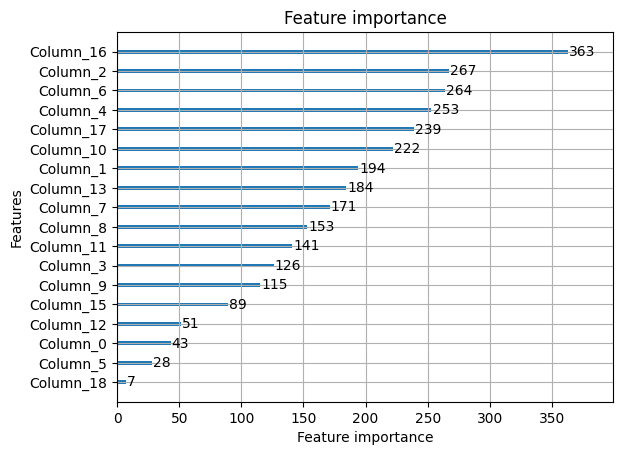

In [ ]:
#visualization of important features
lgb.plot_importance(lgb_model)
plt.show()

#**Conclusion**


# **Model's Performance**
The model's performance indicates that the **average precision score of 0.0044** suggests the model struggles to accurately detect fraud cases. However, the **ROC AUC score of 0.8080** shows a fairly good ability to distinguish between fraud and non-fraud users. This implies that while the model can differentiate the classes well, its precision in detecting fraud needs improvement.

# **Feature Important**
Feature analysis reveals that the most influential features in detecting fraud are **column_16**, **column_2**, and **column_6**, followed by other features in the specified order of importance. Understanding why these features are significant through further analysis can help identify more specific fraud behavior patterns.

# **Handling unbalanced data**
the latter involves trying other techniques or further tuning to increase the average precision. Specifically, you have tried undersampling, oversampling, and SMOTE on imbalanced data, but these approaches do not produce optimal results. Additionally, validating the model with different datasets is also necessary to ensure that the model not only performs well on the training data but also on other data.


# **Result**
The importance of model interpretation cannot be ignored. Understanding key features and their contribution to fraud detection is critical to improving the security of fintech platforms. Therefore, although current models are quite good at distinguishing fraud from non-fraud, there is still room for improvement, especially in detecting fraud cases accurately.